# Imports and Configurations

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm
from util.StringObjectParser import StringObjectParser
from util.src.snails_naturalness_classifier import CanineIdentifierClassifier

/data/kluoma/skalpel-subsetting-evaluation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style="whitegrid")

# Load Data

## Subsetting Performance

In [134]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df["subsetting_method"] = xf.split("-")[1]
    df["benchmark"] = xf.split("-")[2]
    df["comments"] = xf.split("-")[4].replace(".xlsx", "")
    dataframes.append(df)
performance_df = pd.concat(dataframes, ignore_index=True)
for column in performance_df.columns:
    performance_df[column] = performance_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/subsetting_results


/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:59: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")


## Subsetting Diagnosis

Subsetting diagnosis contains the results of the subsetting_diagnosis.py script. 

Columns:
- **database** (str): benchmark database associated with question
- **question_number** (int): benchmark database NL-SQL question number
- **gold_query_tables** (set): minimum tables required for a correct query
- **missing_tables** (set): gold_query_tables - tables in predicted subset
- **hidden_tables** (set): missing tables that are not semantically similar to any n-grams in the natural language question
- **ambiguous_extra_tables** (dict): a dict of natural language words that are semantically similar to tables in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of table names.
- **gold_query_columns** (set): minimum columns required for a correct query, formatted as table.column
- **missing_columns** (set): gold_query_columns - columns in predicted subset
- **value_reference_problem_columns** (dict): Missing columns where a word in the natural language question is semantically similar to a value in the required column, but there is no NL word match to the required column.
-- **ambiguous_extra_columns** (dict):  a dict of natural language words that are semantically similar to columns in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of column names formatted as table.column.

In [4]:
current_directory = f"{os.getcwd()}/diagnosis"
xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df = df.rename(columns={
        "hidden_relations": "hidden_tables",
        "value_reference_problem_attributes": "value_reference_problem_columns",
        "gold_query_attributes": "gold_query_columns",
        "missing_attributes": "missing_columns"
        })
    df = df.drop(columns=["value_reference_problem_relations"], errors="ignore")
    df["subsetting_method"] = xf.split("-")[2]
    df["benchmark"] = xf.split("-")[3]
    df["comments"] = xf.split("-")[-1].replace(".xlsx", "")
    dataframes.append(df)
diagnosis_df = pd.concat(dataframes, ignore_index=True)
for column in diagnosis_df.columns:
    diagnosis_df[column] = diagnosis_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:59: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")


## Preprocessing Times

In [5]:
current_directory = f"{os.getcwd()}/preprocessing_times"
json_files = [file for file in os.listdir(current_directory) if file.endswith('_processing.json')]
df_dict = {"subsetting_method": [], "benchmark": [], "database": [], "processing_time": [], "comment": []}
for filename in json_files:
    fn_split = filename.split("_")
    if "not_for_performance_evaluation" in filename or "abstract" in filename:
        continue
    time_dict = json.loads(open(f"{current_directory}/{filename}", "r").read())
    for k in time_dict:
        if k in ["total", "ga360", "bls", "irs_990"]:
            continue
        df_dict["subsetting_method"].append(fn_split[0])
        df_dict["benchmark"].append(fn_split[1])
        df_dict["database"].append(k)
        df_dict["processing_time"].append(time_dict[k])
        df_dict["comment"].append(fn_split[-2])
processing_time_df = pd.DataFrame(df_dict)
for column in processing_time_df.columns:
    processing_time_df[column] = processing_time_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

## Schema Stats

In [6]:
current_directory = f"{os.getcwd()}/benchmark_schema_stats"
json_files = [file for file in os.listdir(current_directory) if file.endswith('_stats.json')]
df_dict = {"benchmark": [], "database": [], "table_count": [], "column_count": []}
for filename in json_files:
    fn_split = filename.split("_")
    stat_dict = json.loads(open(f"{current_directory}/{filename}", "r").read())
    for k in stat_dict:
        df_dict["benchmark"].append(fn_split[0])
        df_dict["database"].append(k)
        df_dict["table_count"].append(stat_dict[k]["table_count"])
        df_dict["column_count"].append(stat_dict[k]["column_count"])
schema_stat_df = pd.DataFrame(df_dict).query("benchmark!='abstract'")
for column in schema_stat_df.columns:
    schema_stat_df[column] = schema_stat_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

# Generate Data

## Naturalness Generation

In [7]:
identifier_naturalness_path = os.path.join(os.getcwd(), "identifier_naturalness_labels", "identifier_naturalness.xlsx")
if os.path.exists(identifier_naturalness_path):
    identifier_naturalness_df = pd.read_excel(identifier_naturalness_path)

else:
    snails_classifier = CanineIdentifierClassifier()
    label_level_lookup = {"N1": "Regular", "N2": "Low", "N3": "Least", "error": "Classification Error"}

    naturalness_dict = {"identifier": [], "label": []}
    for row in tqdm(performance_df.itertuples(), total=performance_df.shape[0]):
        all_identifiers = row.correct_tables.union(
            row.missing_tables
            ).union(row.extra_tables).union(row.correct_columns).union(
                row.missing_columns
                ).union(row.extra_columns)
        for identifier in all_identifiers:
            if not identifier:
                continue
            if "." in identifier:
                identifier = identifier.split(".")[-1]
            if identifier in naturalness_dict["identifier"]:
                continue
            try:
                result = snails_classifier.classify_identifier(identifier)
            except Exception as e:
                result = [{"label": "error"}]
            naturalness_dict["identifier"].append(identifier)
            naturalness_dict["label"].append(label_level_lookup[result[0]["label"]])
    identifier_naturalness_df = pd.DataFrame(naturalness_dict)
    identifier_naturalness_df.to_excel(identifier_naturalness_path, index=False)

# Process Data

## Model Filter

In [48]:
comment_model_filter = {
    "CodeS": "lambda1_sic_merged",
    "DINSQL": "gpt41",
    "chess": "gpt4o",
    "crush4sql": "lambda1",
    "dtssql": "lambda1",
    "rslsql": "gpt4o",
    "tasql": "gpt41",
    "skalpel": "60perc_retrieved_100tpt_llm_selected_gptoss120b"
}

## Display Data Maps

In [9]:
performance_df.subsetting_method.unique()

array(['skalpel', 'crush4sql', 'rslsql', 'dtssql', 'CodeS', 'tasql',
       'chess', 'DINSQL'], dtype=object)

In [10]:
subsetting_display_names = {
    "crush4sql": "Crush",
    "rslsql": "RSLSQL",
    "tasql": "TASQL",
    "CodeS": "CodeS",
    "dtssql": "DTSSQL",
    "chess": "CHESS",
    "DINSQL": "DINSQL",
    "skalpel": "Skalpel"
}

In [11]:
subsetting_classifications = {
    "crush4sql": "Hyb",
    "rslsql": "LLM",
    "tasql": "LLM",
    "CodeS": "ML",
    "dtssql": "LLM",
    "chess": "Hyb",
    "DINSQL": "LLM",
    "Skalpel": "Hyb"
}

## Process Performance Data

In [135]:
# Annotate (True, False) if all models were able to handle a specific schema (e.g., it fit inside the context window)
# We can recognize databases where some models failed if the inference time is -1
too_big_schemas = list(performance_df.query("inference_time<0").database.unique())
performance_df["all_models_compatible"] = performance_df.database.apply(lambda x: x not in too_big_schemas)

In [136]:
performance_df["Subsetting Method"] = performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [137]:
performance_df["eval_model"] = performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )

In [138]:
performance_df["empty_guess"] = performance_df.apply(
    lambda row: len(row.correct_tables) == 0 and len(row.extra_tables) == 0,
    axis=1
)

## Process Processing Time Data

In [16]:
temp_data_df = schema_stat_df.set_index(["benchmark", "database"])
processing_time_df["seconds_per_column"] = processing_time_df.apply(
    lambda row: row.processing_time / temp_data_df.loc[row.benchmark, row.database]["column_count"],
    axis=1
)
processing_time_df = processing_time_df.drop_duplicates(
    subset=["subsetting_method", "benchmark", "database"]
    ).dropna()

In [17]:
processing_time_df["Subsetting Method"] = processing_time_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [50]:
processing_time_df["eval_model"] = processing_time_df.apply(
    lambda row: row.comment == comment_model_filter[row.subsetting_method],
    axis=1
)

## Process Diagnosis Data

In [19]:
def count_missing_similar_extra(missing_set: set, already_counted: set) -> int:
    idents = set()
    for k in missing_set:
        if k not in already_counted:
            idents.add(k[0].split(".")[-1])
    return len(idents)

def get_unexplained_missing_tables(
        all_missing: set, 
        explained_missing: list[set],
        missing_sim_ext: set
        ) -> set:
    all_explained_missing = set()
    for s in explained_missing:
        all_explained_missing.union(s)
    for t in missing_sim_ext:
        all_explained_missing.add(t[0])
    all_explained_lower = [ident.lower() for ident in all_explained_missing]
    unexplained_missing = set()
    for ident in all_missing:
        if ident.lower() not in all_explained_lower:
            unexplained_missing.add(ident)
    return unexplained_missing

diagnosis_df["missing_tables_count"] = diagnosis_df.missing_tables.apply(lambda x: len(x))
diagnosis_df["all_hidden_tables_count"] = diagnosis_df.all_hidden_tables.apply(lambda x: len(x))
diagnosis_df["missing_hidden_tables_count"] = diagnosis_df.missing_hidden_tables.apply(lambda x: len(x))
diagnosis_df["missing_similar_extra_tables_count"] = diagnosis_df.apply(
    lambda x: count_missing_similar_extra(x.missing_similar_extra_tables, x.missing_hidden_tables),
    axis = 1
)
diagnosis_df["unexplained_missing_tables"] = diagnosis_df.apply(
    lambda row: get_unexplained_missing_tables(
        row.missing_tables, 
        [row.missing_hidden_tables],
        row.missing_similar_extra_tables
        ),
    axis=1
)
diagnosis_df["unexplained_missing_tables_count"] = diagnosis_df.apply(
    lambda row: row.missing_tables_count 
        - row.missing_hidden_tables_count 
        - row.missing_similar_extra_tables_count,
    axis=1
)
diagnosis_df["hidden_table_missing_proportion"] = diagnosis_df.apply(
    lambda row: row.missing_hidden_tables_count / row.all_hidden_tables_count if row.all_hidden_tables_count > 0 else -1,
    axis=1
)
def count_ambiguous(amb_dict: dict) -> int:
    idents = set()
    if type(amb_dict) == str:
        return -1
    for k in amb_dict:
        idents = idents.union(amb_dict[k])
    return len(idents)
diagnosis_df["all_ambiguous_tables_count"] = diagnosis_df.all_ambiguous_tables.apply(
    lambda x: count_ambiguous(x)
)
diagnosis_df["ambiguous_extra_tables_count"] = diagnosis_df.ambiguous_extra_tables.apply(
    lambda x: count_ambiguous(x)
)
diagnosis_df["ambiguous_extra_tables_proportion"] = diagnosis_df.apply(
    lambda row: row.ambiguous_extra_tables_count / row.all_ambiguous_tables_count 
    if row.all_ambiguous_tables_count > 0 and row.ambiguous_extra_tables_count >= 0 else -1,
    axis=1
)
diagnosis_df["missing_columns_count"] = diagnosis_df.missing_columns.apply(lambda x: len(x))
diagnosis_df["all_value_reference_problem_columns_count"] = diagnosis_df.all_value_reference_problem_columns.apply(lambda x: len(x))
diagnosis_df["missing_value_reference_problem_columns_count"] = diagnosis_df.missing_value_reference_problem_columns.apply(
    lambda x: len(x.keys())
)

diagnosis_df["missing_similar_extra_columns_count"] = diagnosis_df.apply(
    lambda x: count_missing_similar_extra(x.missing_similar_extra_columns, x.missing_value_reference_problem_columns),
    axis=1
)
def get_unexplained_missing_columns(
        all_missing: set, 
        missing_val_ref: dict,
        missing_sim_ext: set[tuple[str, str, float]]
        ) -> set:
    explained_missing = set()
    unexplained_missing = set()
    for k in missing_val_ref.keys():
        explained_missing.add(k.lower())
    for t in missing_sim_ext:
        explained_missing.add(t[0].lower())
    for col in all_missing:
        if col.lower() not in explained_missing:
            unexplained_missing.add(col)
    return unexplained_missing

diagnosis_df["missing_columns_in_missing_tables"] = diagnosis_df.apply(
    lambda row: set([
        c for c in row.missing_columns
        if ".".join(c.split(".")[:-1]) in row.missing_tables
        ]),
    axis=1
)
diagnosis_df["missing_columns_in_missing_tables_count"] = diagnosis_df.missing_columns_in_missing_tables.apply(
    lambda x: len(x)
    )

diagnosis_df["unexplained_missing_columns"] = diagnosis_df.apply(
    lambda row: get_unexplained_missing_columns(
        all_missing=row.missing_columns,
        missing_val_ref=row.missing_value_reference_problem_columns,
        missing_sim_ext=row.missing_similar_extra_columns
    ),
    axis=1
)
diagnosis_df["unexplained_missing_columns_count"] = diagnosis_df.apply(
    lambda row: row.missing_columns_count 
        - row.missing_value_reference_problem_columns_count 
        - row.missing_similar_extra_columns_count,
        # - row.missing_columns_in_missing_tables_count,
    axis=1
)
diagnosis_df["value_reference_problem_columns_proportion"] = diagnosis_df.apply(
    lambda row: row.missing_value_reference_problem_columns_count / row.all_value_reference_problem_columns_count
    if row.all_value_reference_problem_columns_count > 0 else -1,
    axis=1
)
diagnosis_df["all_ambiguous_columns_count"] = diagnosis_df.all_ambiguous_columns.apply(
    lambda x: count_ambiguous(x)
)
diagnosis_df["ambiguous_extra_columns_count"] = diagnosis_df.ambiguous_extra_columns.apply(
    lambda x: count_ambiguous(x)
)
diagnosis_df["ambiguous_extra_columns_proportion"] = diagnosis_df.apply(
    lambda row: row.ambiguous_extra_columns_count / row.all_ambiguous_columns_count
    if row.all_ambiguous_columns_count > 0 and row.ambiguous_extra_columns_count >= 0 else -1,
    axis=1
)
diagnosis_df["Subsetting Method"] = diagnosis_df.subsetting_method.apply(
    lambda x: subsetting_display_names[x]
)
diagnosis_df["eval_model"] = diagnosis_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
)

In [20]:
if True:
    diagnosis_df.to_excel("./misc_df_output/diagnosis_df.xlsx")

## Process Schema Stat Data

### Schema Size
Size is calculated in terms of the number of columns in the schema. Sizes are determined logarithmically, where size increases along powers of 10 (e.g. <= 10 columns = xs, <= 100 = s, 1000, 100000, etc.)

In [21]:
schema_sizes = {
    100: "s",
    1000: "m",
    2500: "l",
    50000: "xl",
    100000: "xxl"
}

def get_size(x: int) -> str:
    for s in schema_sizes.keys():
        if x < s:
            return schema_sizes[s]

schema_size_map = {
    schema_sizes[k] : k for k in schema_sizes.keys()
}

schema_stat_df["size_cat"] = schema_stat_df.column_count.apply(
    lambda x: get_size(x) 
    )
schema_stat_df["size_descr"] = schema_stat_df.size_cat.apply(
    lambda x: f"col<{schema_size_map[x]:,}"
)
schema_stat_df["size_sort"] = schema_stat_df.size_cat.apply(
    lambda x: schema_size_map[x]
)

schema_stat_df["mean_table_size"] = schema_stat_df.apply(
    lambda row: row.column_count / row.table_count,
    axis=1
)

## Identifier Row-Level Analysis

### Generate identifier naturalness dataframes

In [22]:
column_analysis_df = {
    "subsetting_method": [], "comments": [], "benchmark": [], "database": [], "question_number": [], "table": [], "column": [],
    "column_naturalness": [], "status": [] 
}
table_analysis_df = {
    "subsetting_method": [], "comments": [], "benchmark": [], "database": [], "question_number": [], "table": [],
    "table_naturalness": [], "status": [] 
}
identifier_naturalness_df = identifier_naturalness_df.reset_index().set_index(["identifier"])

temp_data_df = performance_df.query("inference_time > 0 and prompt_tokens >= 0")

for row in tqdm(temp_data_df.itertuples(), total=temp_data_df.shape[0]):
    for column in row.correct_columns:
        if not column:
            continue
        column_analysis_df["subsetting_method"].append(row.subsetting_method)
        table, col = (".".join(column.split(".")[:-1]), column.split(".")[-1]) if column and "." in column else (None, column)
        column_analysis_df["comments"].append(row.comments)
        column_analysis_df["benchmark"].append(row.benchmark)
        column_analysis_df["database"].append(row.database)
        column_analysis_df["question_number"].append(row.question_number)
        column_analysis_df["table"].append(table)
        column_analysis_df["column"].append(col)
        column_analysis_df["column_naturalness"].append(
            identifier_naturalness_df.loc[col, "label"] if col in identifier_naturalness_df.index else None
        )
        column_analysis_df["status"].append("correct")

    for column in row.missing_columns:
        if not column:
            continue
        column_analysis_df["subsetting_method"].append(row.subsetting_method)
        table, col = (".".join(column.split(".")[:-1]), column.split(".")[-1]) if column and "." in column else (None, column)
        column_analysis_df["comments"].append(row.comments)
        column_analysis_df["benchmark"].append(row.benchmark)
        column_analysis_df["database"].append(row.database)
        column_analysis_df["question_number"].append(row.question_number)
        column_analysis_df["table"].append(table)
        column_analysis_df["column"].append(col)
        column_analysis_df["column_naturalness"].append(
            identifier_naturalness_df.loc[col, "label"] if col in identifier_naturalness_df.index else None
        )
        column_analysis_df["status"].append("missing")

    for column in row.extra_columns:
        if not column:
            continue
        column_analysis_df["subsetting_method"].append(row.subsetting_method)
        table, col = (".".join(column.split(".")[:-1]), column.split(".")[-1]) if column and "." in column else (None, column)
        column_analysis_df["comments"].append(row.comments)
        column_analysis_df["benchmark"].append(row.benchmark)
        column_analysis_df["database"].append(row.database)
        column_analysis_df["question_number"].append(row.question_number)
        column_analysis_df["table"].append(table)
        column_analysis_df["column"].append(col)
        column_analysis_df["column_naturalness"].append(
            identifier_naturalness_df.loc[col, "label"] if col in identifier_naturalness_df.index else None
        )
        column_analysis_df["status"].append("extra")

    for table in row.correct_tables:
        if not table:
            continue
        table_analysis_df["subsetting_method"].append(row.subsetting_method)
        table_analysis_df["comments"].append(row.comments)
        table_analysis_df["benchmark"].append(row.benchmark)
        table_analysis_df["database"].append(row.database)
        table_analysis_df["question_number"].append(row.question_number)
        table_analysis_df["table"].append(table)
        table_analysis_df["table_naturalness"].append(
            identifier_naturalness_df.loc[table.split(".")[-1], "label"] if table.split(".")[-1] in identifier_naturalness_df.index else None
        )
        table_analysis_df["status"].append("correct")

    for table in row.missing_tables:
        if not table:
            continue
        table_analysis_df["subsetting_method"].append(row.subsetting_method)
        table_analysis_df["comments"].append(row.comments)
        table_analysis_df["benchmark"].append(row.benchmark)
        table_analysis_df["database"].append(row.database)
        table_analysis_df["question_number"].append(row.question_number)
        table_analysis_df["table"].append(table)
        table_analysis_df["table_naturalness"].append(
            identifier_naturalness_df.loc[table.split(".")[-1], "label"] if table.split(".")[-1] in identifier_naturalness_df.index else None
        )
        table_analysis_df["status"].append("missing")

    for table in row.extra_tables:
        if not table:
            continue
        table_analysis_df["subsetting_method"].append(row.subsetting_method)
        table_analysis_df["comments"].append(row.comments)
        table_analysis_df["benchmark"].append(row.benchmark)
        table_analysis_df["database"].append(row.database)
        table_analysis_df["question_number"].append(row.question_number)
        table_analysis_df["table"].append(table)
        table_analysis_df["table_naturalness"].append(
            identifier_naturalness_df.loc[table.split(".")[-1], "label"] if table.split(".")[-1] in identifier_naturalness_df.index else None
        )
        table_analysis_df["status"].append("extra")

column_analysis_df = pd.DataFrame(column_analysis_df)
table_analysis_df = pd.DataFrame(table_analysis_df)
identifier_naturalness_df = identifier_naturalness_df.reset_index()

100%|██████████| 29086/29086 [00:05<00:00, 5462.54it/s]


### Add diagnosis to identifier analysis dataframes

In [23]:
columns_ambiguous = []
columns_is_value_reference = []
columns_value_reference_problem = []
columns_missing_similar_extra = []
column_table_missing = []
hallucinated = []
id_column = []

temp_diagnosis_df = diagnosis_df.set_index(["subsetting_method", "comments", "benchmark", "database", "question_number"])

for row in tqdm(column_analysis_df.itertuples(), total=column_analysis_df.shape[0]):
    if (row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number) not in temp_diagnosis_df.index:
        columns_ambiguous.append(None)
        columns_is_value_reference.append(None)
        columns_value_reference_problem.append(None)
        columns_missing_similar_extra.append(None)
        column_table_missing.append(None)
        hallucinated.append(None)
        id_column.append(None)
        continue
    all_ambiguous_columns_dict = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].ambiguous_extra_columns
    all_ambiguous_columns = set()
    for k in all_ambiguous_columns_dict:
        all_ambiguous_columns = all_ambiguous_columns.union(set([c.split(".")[-1].lower() for c in all_ambiguous_columns_dict[k]]))
    columns_ambiguous.append(row.status == "extra" and row.column in all_ambiguous_columns)
   
    value_reference_problem_columns = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].all_value_reference_problem_columns
    columns_is_value_reference.append(row.column.upper() in [c.split(".")[-1] for c in value_reference_problem_columns.keys()])
    columns_value_reference_problem.append(row.status == "missing" and row.column.upper() 
                                           in [c.split(".")[-1] for c in value_reference_problem_columns.keys()]
                                           )
    
    missing_similar_extra_columns = [t[0].split(".")[-1]  for t in temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
    ].missing_similar_extra_columns]
    columns_missing_similar_extra.append(row.status == "missing" and row.column in missing_similar_extra_columns)
    
    missing_table_column_pairs = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].missing_columns_in_missing_tables
    column_table_missing.append(row.status == "missing" and f"{row.table}.{row.column}" in missing_table_column_pairs)
    
    hallucinated_extra_collumns = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
    ].hallucinated_extra_columns
    hallucinated.append(row.status == "extra" and (f"{row.table}.{row.column}" in hallucinated_extra_collumns or row.column in hallucinated_extra_collumns))

    id_column.append(row.column[-2:].lower() == "id")

column_analysis_df["ambiguous_extra"] = columns_ambiguous
column_analysis_df["is_value_reference"] = columns_is_value_reference
column_analysis_df["value_reference_problem"] = columns_value_reference_problem
column_analysis_df["missing_similar_extra"] = columns_missing_similar_extra
column_analysis_df["table_missing"] = column_table_missing
column_analysis_df["hallucinated_extra"] = hallucinated
column_analysis_df["endswith_id"] = id_column

column_analysis_df = column_analysis_df.set_index([
    "subsetting_method", "comments", "benchmark", "database", "question_number"
    ]).join(
        performance_df.set_index([
    "subsetting_method", "comments", "benchmark", "database", "question_number"
    ])[["eval_model", "empty_guess"]]
    ).reset_index().dropna(subset=["endswith_id"])
    

100%|██████████| 698762/698762 [04:20<00:00, 2683.37it/s]  


In [24]:
column_analysis_df.to_excel("./misc_df_output/column_analysis_df.xlsx", index=False)

In [25]:
temp_diagnosis_df = diagnosis_df.set_index(["subsetting_method", "comments", "benchmark", "database", "question_number"])
tables_is_hidden = []
tables_missing_hidden = []
tables_ambiguous = []
tables_missing_similar_extra = []

for row in tqdm(table_analysis_df.itertuples(), total=table_analysis_df.shape[0]):
    if (row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number) not in temp_diagnosis_df.index:
        tables_is_hidden.append(None)
        tables_missing_hidden.append(None)
        tables_ambiguous.append(None)
        tables_missing_similar_extra.append(None)
        continue
    missing_hidden_tables = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].missing_hidden_tables
    tables_missing_hidden.append(
        row.status == "missing" and row.table in missing_hidden_tables
        )
    all_hidden_tables = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].all_hidden_tables
    tables_is_hidden.append(
        row.table in all_hidden_tables
    )
    ambiguous_extra_tables = temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
        ].ambiguous_extra_tables
    tables_ambiguous.append(row.status == "extra" and row.table in ambiguous_extra_tables)
    missing_similar_extra_tables = [t[0]for t in temp_diagnosis_df.loc[
        row.subsetting_method, row.comments, row.benchmark, row.database, row.question_number
    ].missing_similar_extra_tables]
    tables_missing_similar_extra.append(row.status == "missing" and row.table in missing_similar_extra_tables)

table_analysis_df["ambiguous_extra"] = tables_ambiguous
table_analysis_df["is_hidden_table"] = tables_is_hidden
table_analysis_df["hidden_table_problem"] = tables_missing_hidden
table_analysis_df["missing_similar_extra"] = tables_missing_similar_extra

table_analysis_df = table_analysis_df.set_index([
    "subsetting_method", "comments", "benchmark", "database", "question_number"
    ]).join(
        performance_df.set_index([
    "subsetting_method", "comments", "benchmark", "database", "question_number"
    ])[["eval_model", "empty_guess"]]
    ).reset_index()

100%|██████████| 124474/124474 [00:45<00:00, 2758.11it/s] 


## Process Row Level Eval Data

In [26]:
column_analysis_df["eval_model"] = column_analysis_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method],
    axis=1
)
table_analysis_df["eval_model"] = table_analysis_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method],
    axis=1
)

# Functions

## Schema Coverage

In [27]:
def get_schema_coverage(
        subsetting_method: str, 
        performance_df: pd.DataFrame, 
        schema_stat_df: pd.DataFrame
        ) -> dict[str, float]:
    """
    Function for calculating the weighted average of schemas that a subsetting method succesfully processed.
    Provides a weighted average of schemas where each schema size is uniformly represented in the output.
    This approach avoids overstating the importance of small and medium sized schemas which are overrepresented 
    in the dataset.
    """
    temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index().query(f"eval_model and subsetting_method=='{subsetting_method}'")
    size_proportions = []
    for size in temp_data_df.size_cat.unique():
        total_schemas = len(
            temp_data_df.query(f"size_cat=='{size}'").database.unique()
            )
        processed_schemas = len(
            temp_data_df.query(f"size_cat=='{size}' and prompt_tokens>=0 and inference_time>0").database.unique()
        )
        size_proportions.append(processed_schemas / total_schemas)
    return np.mean(size_proportions)

get_schema_coverage("tasql", performance_df, schema_stat_df)

0.7714285714285715

## Decimal to Percent

In [101]:
def dec_to_percent(x: float) -> str:
    return str(int(x * 100)) + "\%"

# Scorecards

## Performance DF Scorecard

In [139]:
eval_columns = [
    "inference_time",
    "prompt_tokens",
    "total_f1",
    # "table_f1",
    # "column_f1",
    "total_recall",
    # "table_recall",
    # "column_recall",
    "total_precision",
    # "table_precision",
    # "column_precision",
    "subset_table_proportion"
]
performance_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])[["size_cat"]]
).reset_index().query(
    "prompt_tokens >= 0 and inference_time > 0 and benchmark=='snails'"
    )[["benchmark", "subsetting_method", "comments", "size_cat"] + eval_columns].pivot_table(
    index=["size_cat", "subsetting_method", "comments"],
    columns=["benchmark"],
    aggfunc="mean"
)

inference_time  \
benchmark                                                                           snails   
size_cat subsetting_method comments                                                          
l        CodeS             lambda1                                                2.931538   
                           lambda1_sic_merged                                     5.292154   
         DINSQL            gpt41                                                  8.363822   
         chess             gpt4o                                                 66.404750   
         crush4sql         lambda1                                                2.877872   
         rslsql            gpt41                                                 26.903101   
                           gpt41nano                                              5.630531   
                           gpt4o                                                 24.285711   
         skalpel           60perc_retrieved_1000tpt_llm_selected_gptoss120b      10.868769   
                           60perc_retrieved_100tpt_llm_selected_gptoss120b       13.367629   
                           60perc_retrieved_llm_selected_gpt41                    4.108709   
                           60perc_retrieved_llm_selected_llama4                   9.071232   
         tasql             gpt41                                                  2.598086   
                           gpt41nano                                              1.800233   
m        CodeS             lambda1                                                0.555118   
                           lambda1_sic_merged                                     1.258049   
         DINSQL            gpt41                                                  7.813187   
         chess             gpt4o                                                 36.906458   
         crush4sql         lambda1                                                2.560501   
         rslsql            gpt41                                                 12.053357   
                           gpt41nano                                              5.719921   
                           gpt4o                                                 16.565198   
         skalpel           60perc_retrieved_1000tpt_llm_selected_gptoss120b      11.054399   
                           60perc_retrieved_100tpt_llm_selected_gptoss120b       12.858114   
                           60perc_retrieved_llm_selected_gpt41                    4.352327   
                           60perc_retrieved_llm_selected_llama4                   9.619470   
         tasql             gpt41                                                  2.184290   
                           gpt41nano                                              1.555490   
s        CodeS             lambda1                                                0.134425   
                           lambda1_sic_merged                                     0.290105   
         DINSQL            gpt41                                                  4.626076   
         chess             gpt4o                                                 29.905738   
         crush4sql         lambda1                                                2.153798   
         rslsql            gpt41                                                  7.330794   
                           gpt41nano                                              2.275153   
                           gpt4o                                                 15.192887   
         skalpel           60perc_retrieved_1000tpt_llm_selected_gptoss120b       8.647344   
                           60perc_retrieved_100tpt_llm_selected_gptoss120b        9.485079   
                           60perc_retrieved_llm_selected_gpt41                    5.014183   
                           60perc_retrieved_llm_selected_llama4                   9.018350   
         tasql             gpt41  

# EDA

## Schema Stats

### Column Count Distribution (Log scale)

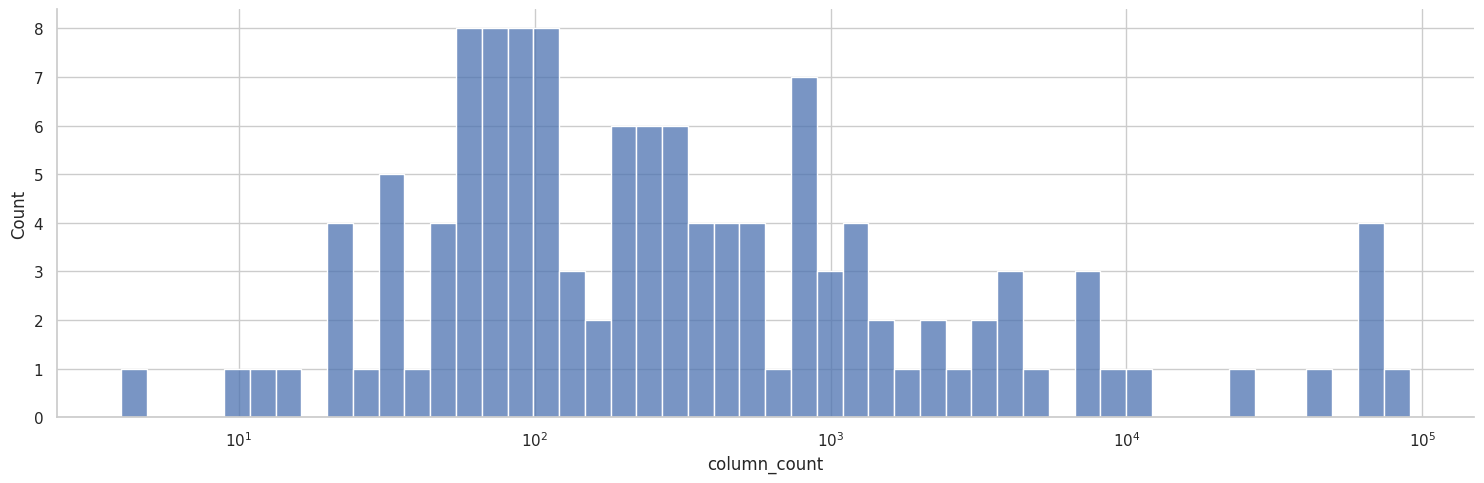

In [29]:
sns.displot(
    data=schema_stat_df,
    x="column_count",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

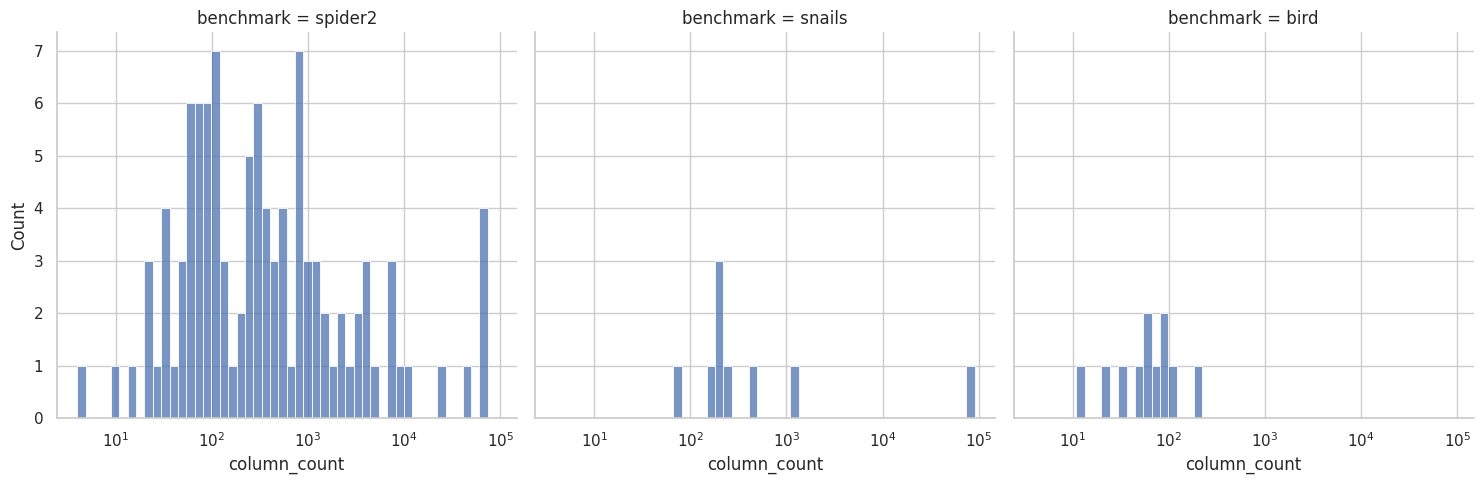

In [30]:
sns.displot(
    data=schema_stat_df,
    x="column_count",
    # hue="type",
    bins=50,
    aspect=1,
    col="benchmark",
    log_scale=[True, False]
)

### Table Count Distribution (Log scale)

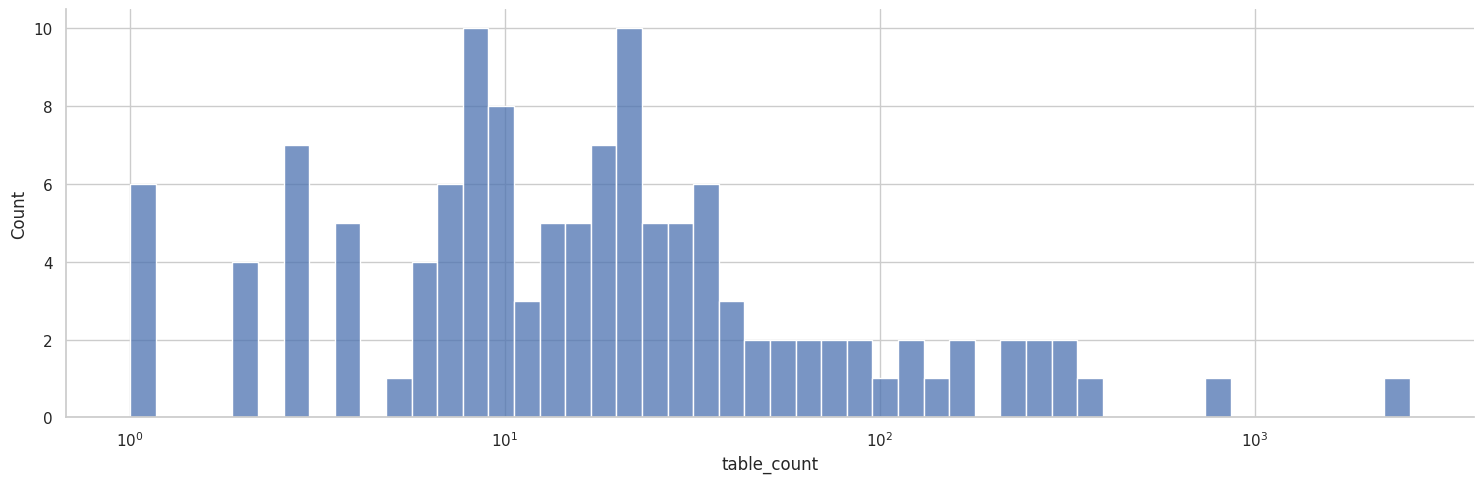

In [31]:
sns.displot(
    data=schema_stat_df,
    x="table_count",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

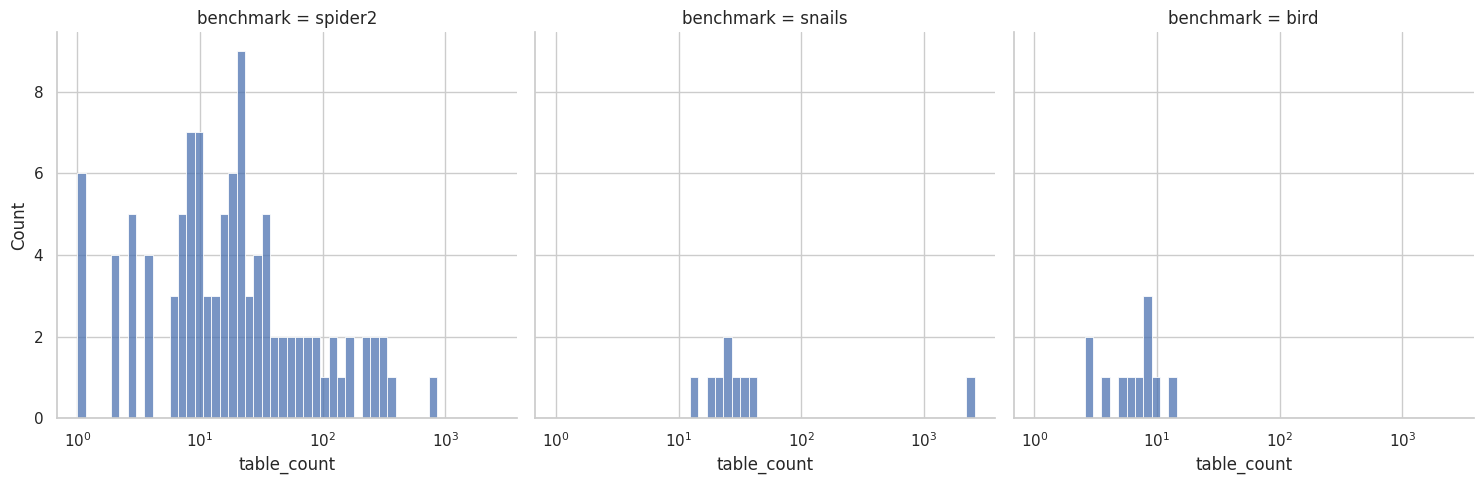

In [32]:
sns.displot(
    data=schema_stat_df,
    x="table_count",
    # hue="type",
    bins=50,
    aspect=1,
    log_scale=[True, False],
    col="benchmark"
)

### Mean Table Size (column count / table count) distribution

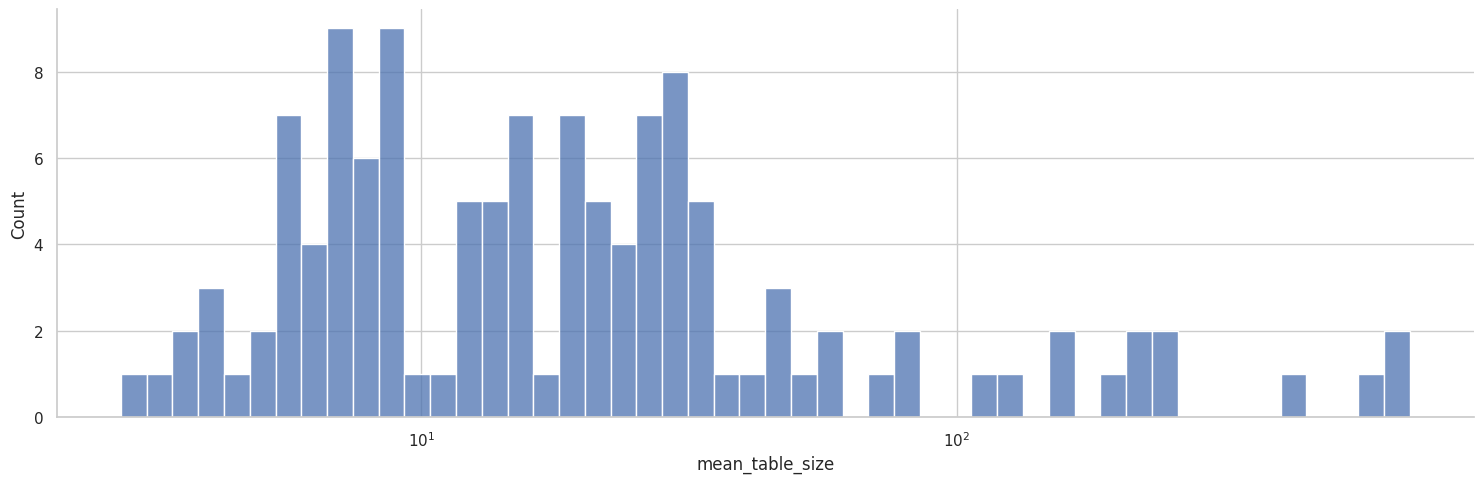

In [33]:
sns.displot(
    data=schema_stat_df,
    x="mean_table_size",
    # hue="type",
    bins=50,
    aspect=3,
    log_scale=[True, False]
)

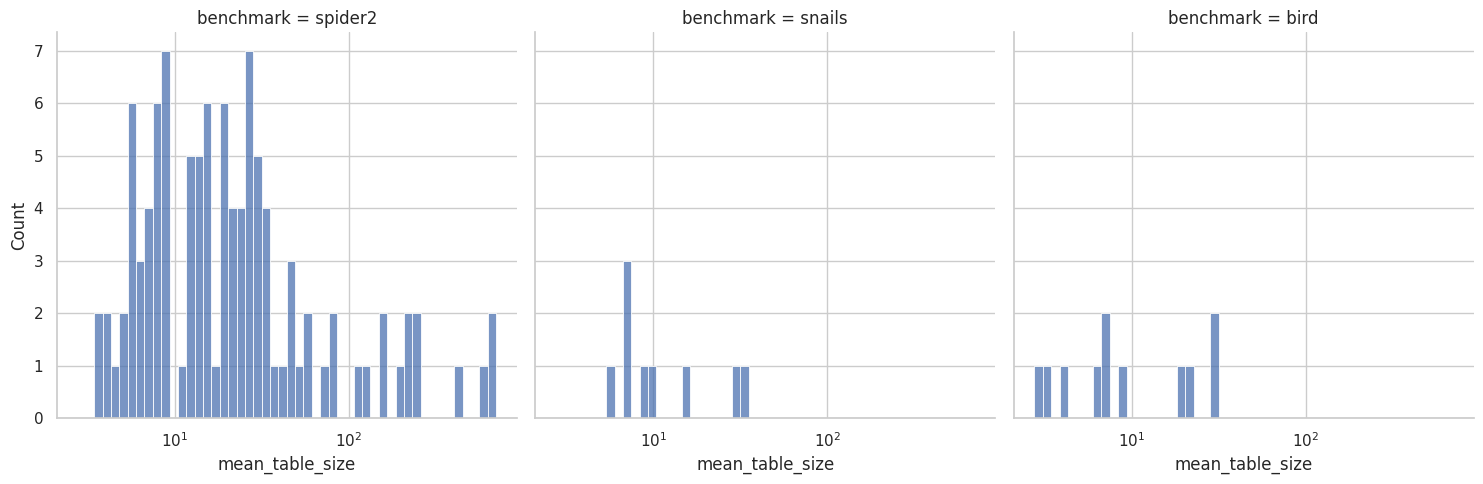

In [34]:
sns.displot(
    data=schema_stat_df,
    x="mean_table_size",
    # hue="type",
    bins=50,
    aspect=1,
    log_scale=[True, False],
    col="benchmark"
)

### Schema Size Counts Table by Benchmark 

In [35]:
temp_data_df = schema_stat_df.copy()
temp_data_df["Size"] = temp_data_df.apply(lambda row: f"{row.size_cat.upper()}", axis=1)
temp_data_df["Columns"] = temp_data_df.apply(lambda row: row.size_descr.replace("col", ""), axis=1)
temp_data_df = temp_data_df.pivot_table(
    index=["Size", "Columns", "size_sort"],
    columns="benchmark",
    values="database",
    aggfunc="count"
).fillna(0)
temp_data_df["Total"] = temp_data_df.apply(lambda row: row.bird + row.snails + row.spider2, axis=1)
temp_data_df = temp_data_df.astype(int).reset_index().sort_values(by="size_sort")
temp_data_df = temp_data_df.drop("size_sort", axis=1)
temp_data_df.to_latex(
    buf=f"{os.getcwd()}/tables/benchmark_schema_size_table.tex",
    index=False,
    header=["Size", "Columns", "Bird", "Snails", "Spider2", "Total"],
    label=f"tab:benchmark-schema-sizes",
    caption="Schema size distribution for each benchmark dataset. "
)

## Performance Distributions

### Recall, precision, and f1

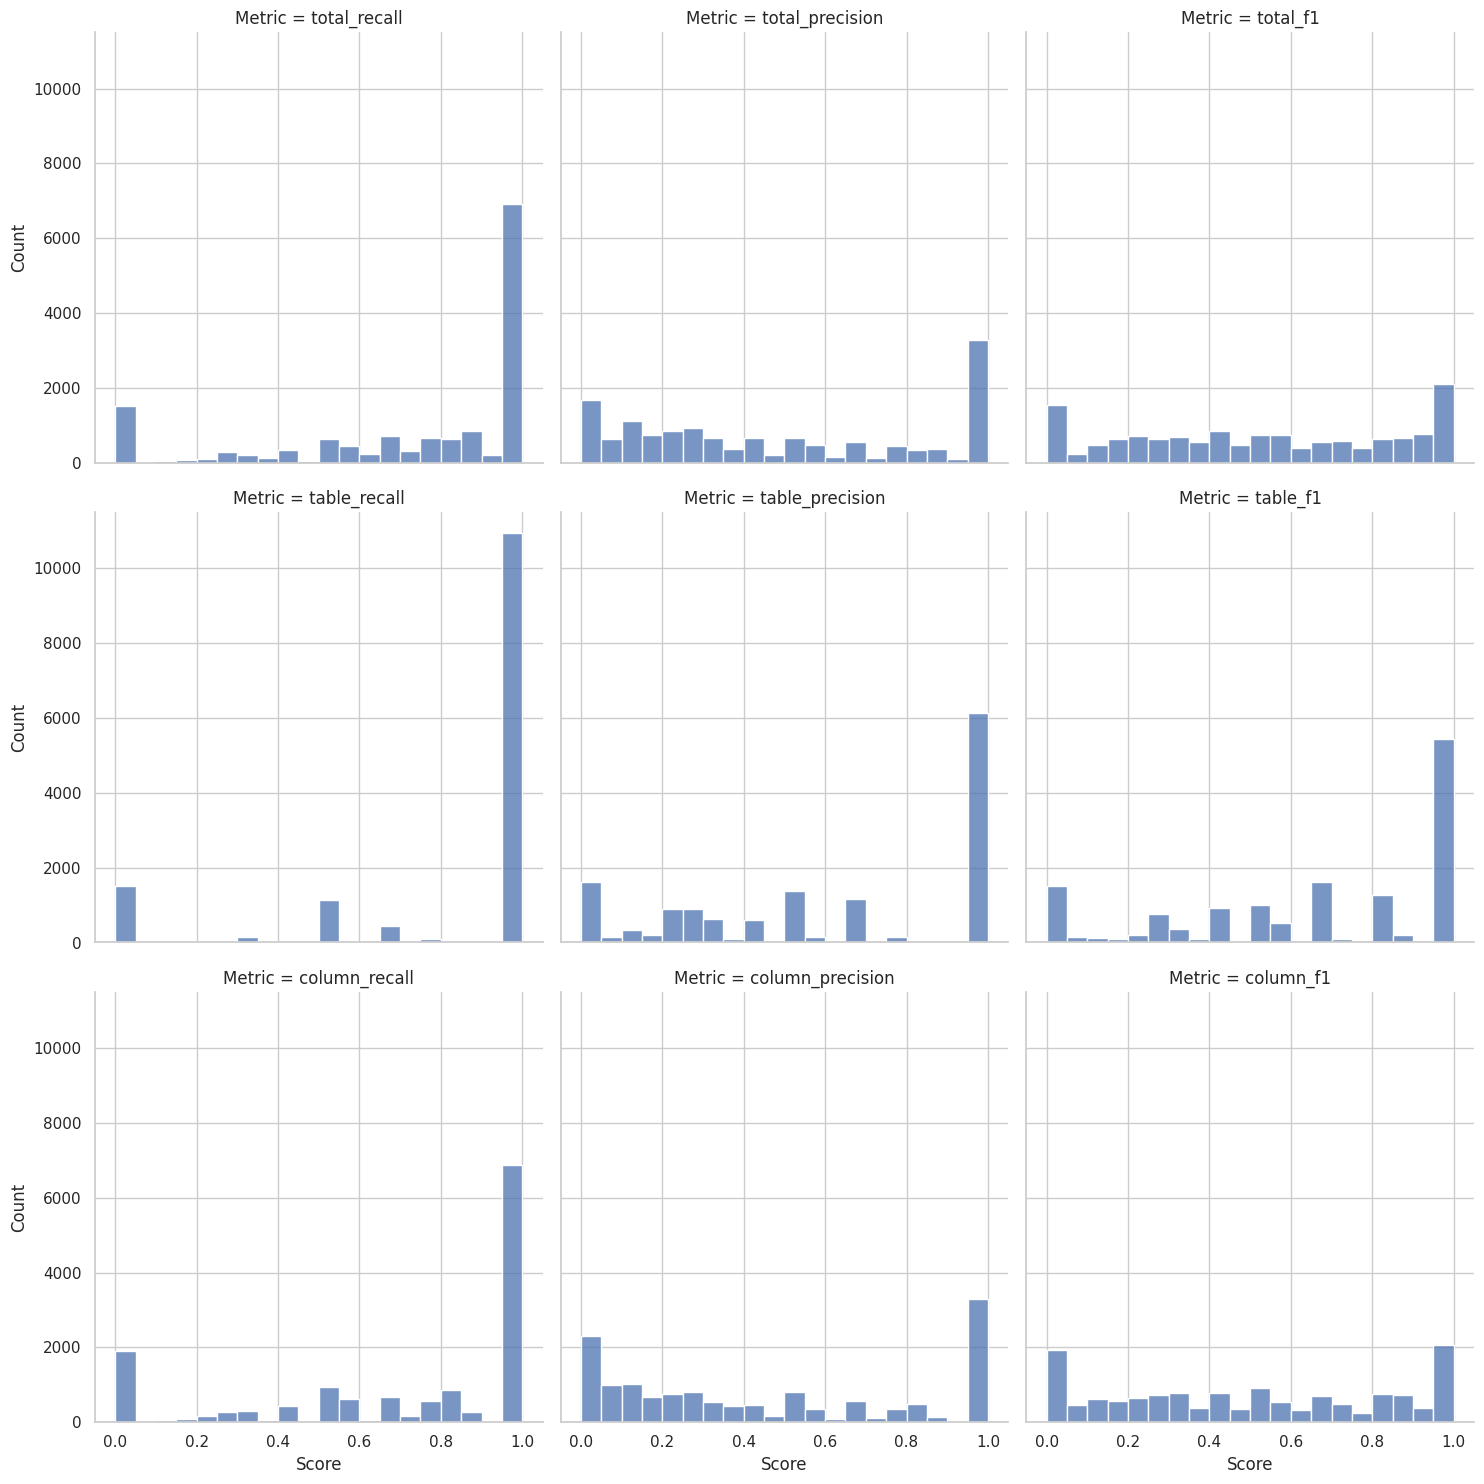

In [36]:
sns.displot(
    data=performance_df.query(
        "prompt_tokens>=0 and eval_model"
    ).melt(
        id_vars=["benchmark", "subsetting_method"],
        value_vars=[
            "total_recall", "total_precision", "total_f1", 
            "table_recall", "table_precision", "table_f1",
            "column_recall", "column_precision", "column_f1"
            ],
        value_name="Score",
        var_name="Metric"
    ),
    x="Score",
    col="Metric",
    col_wrap=3,
    bins=20
)

### Recall, precision, and f1 by benchmark

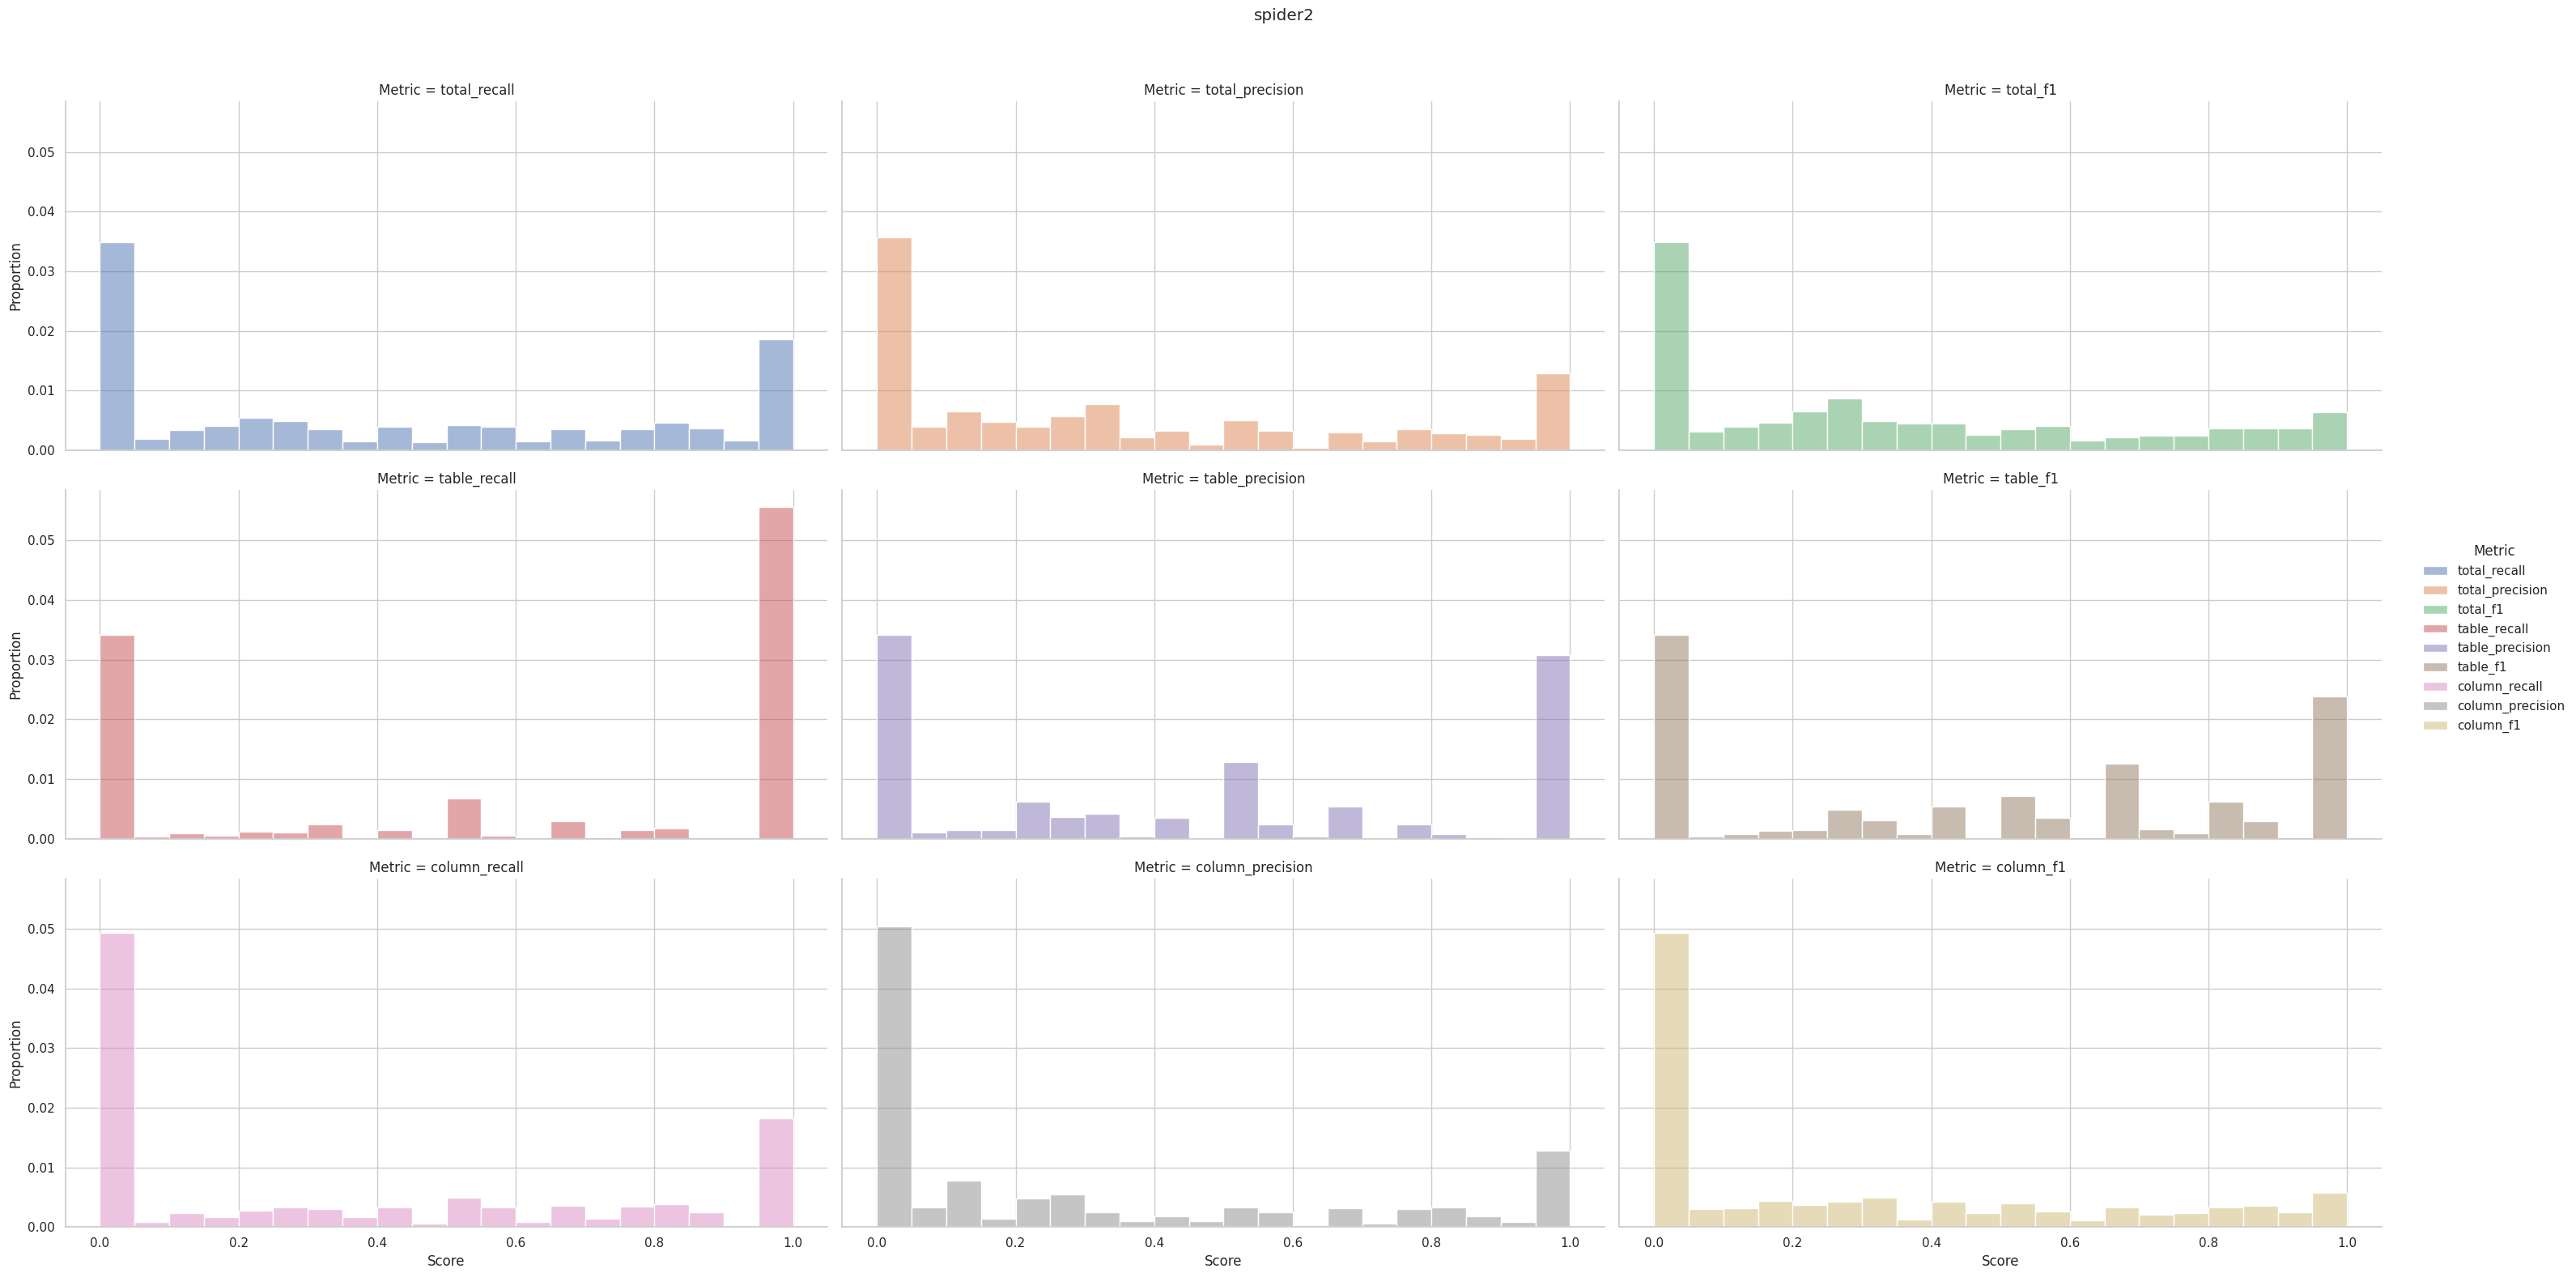

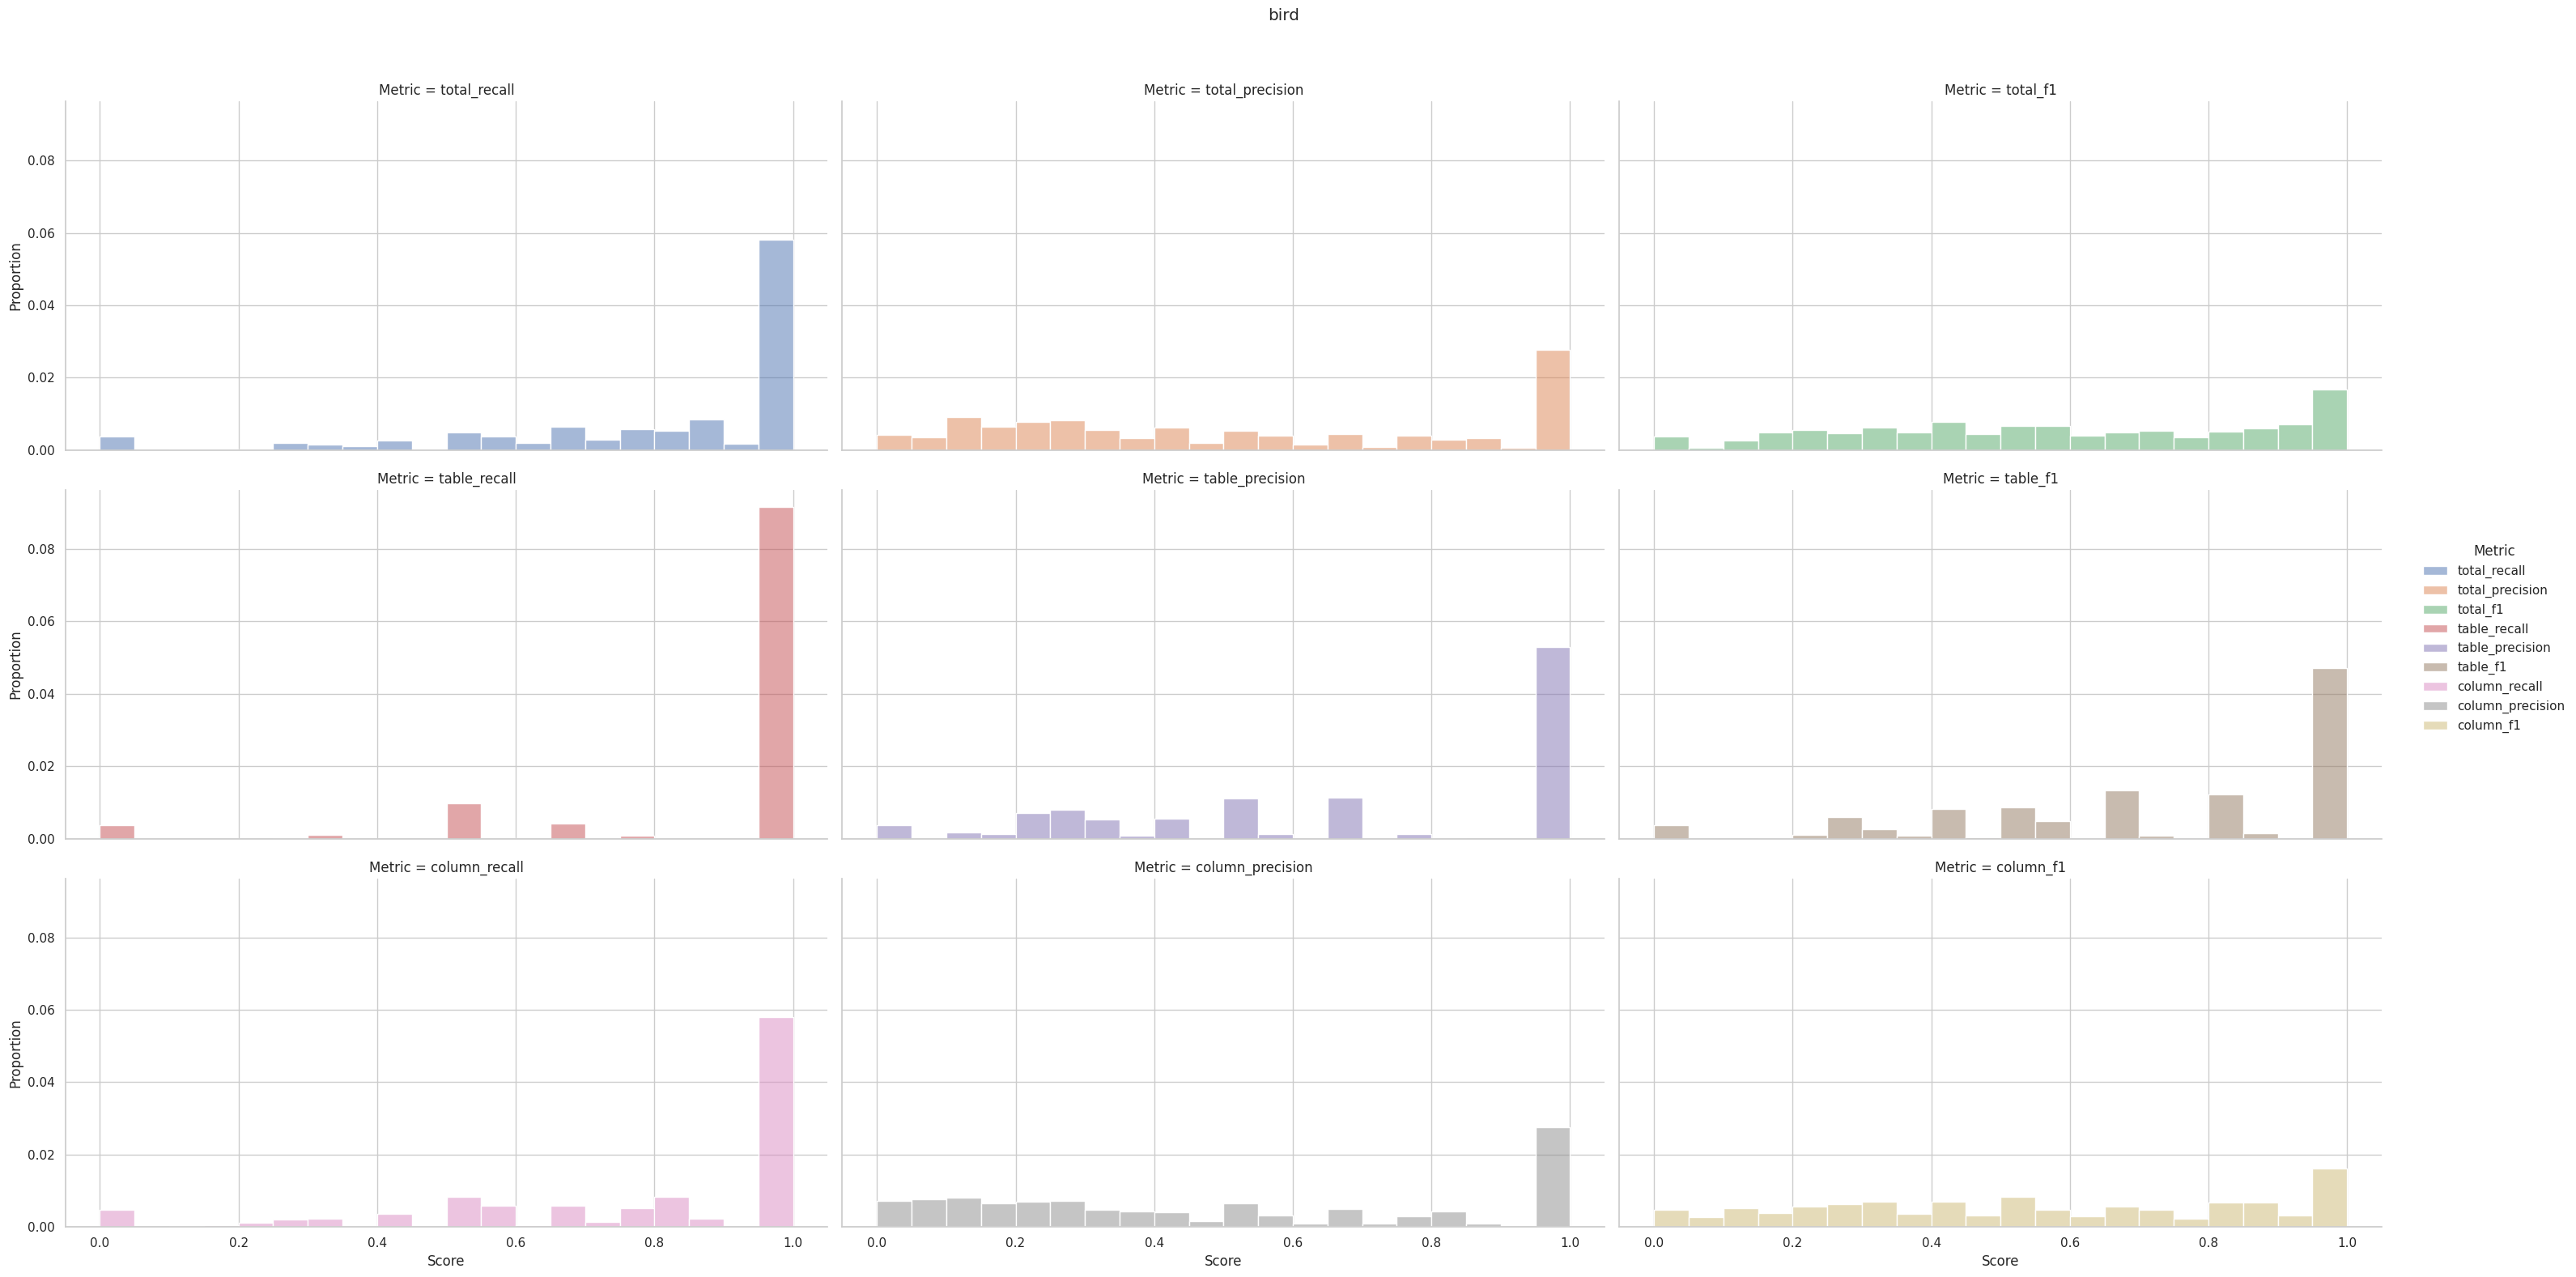

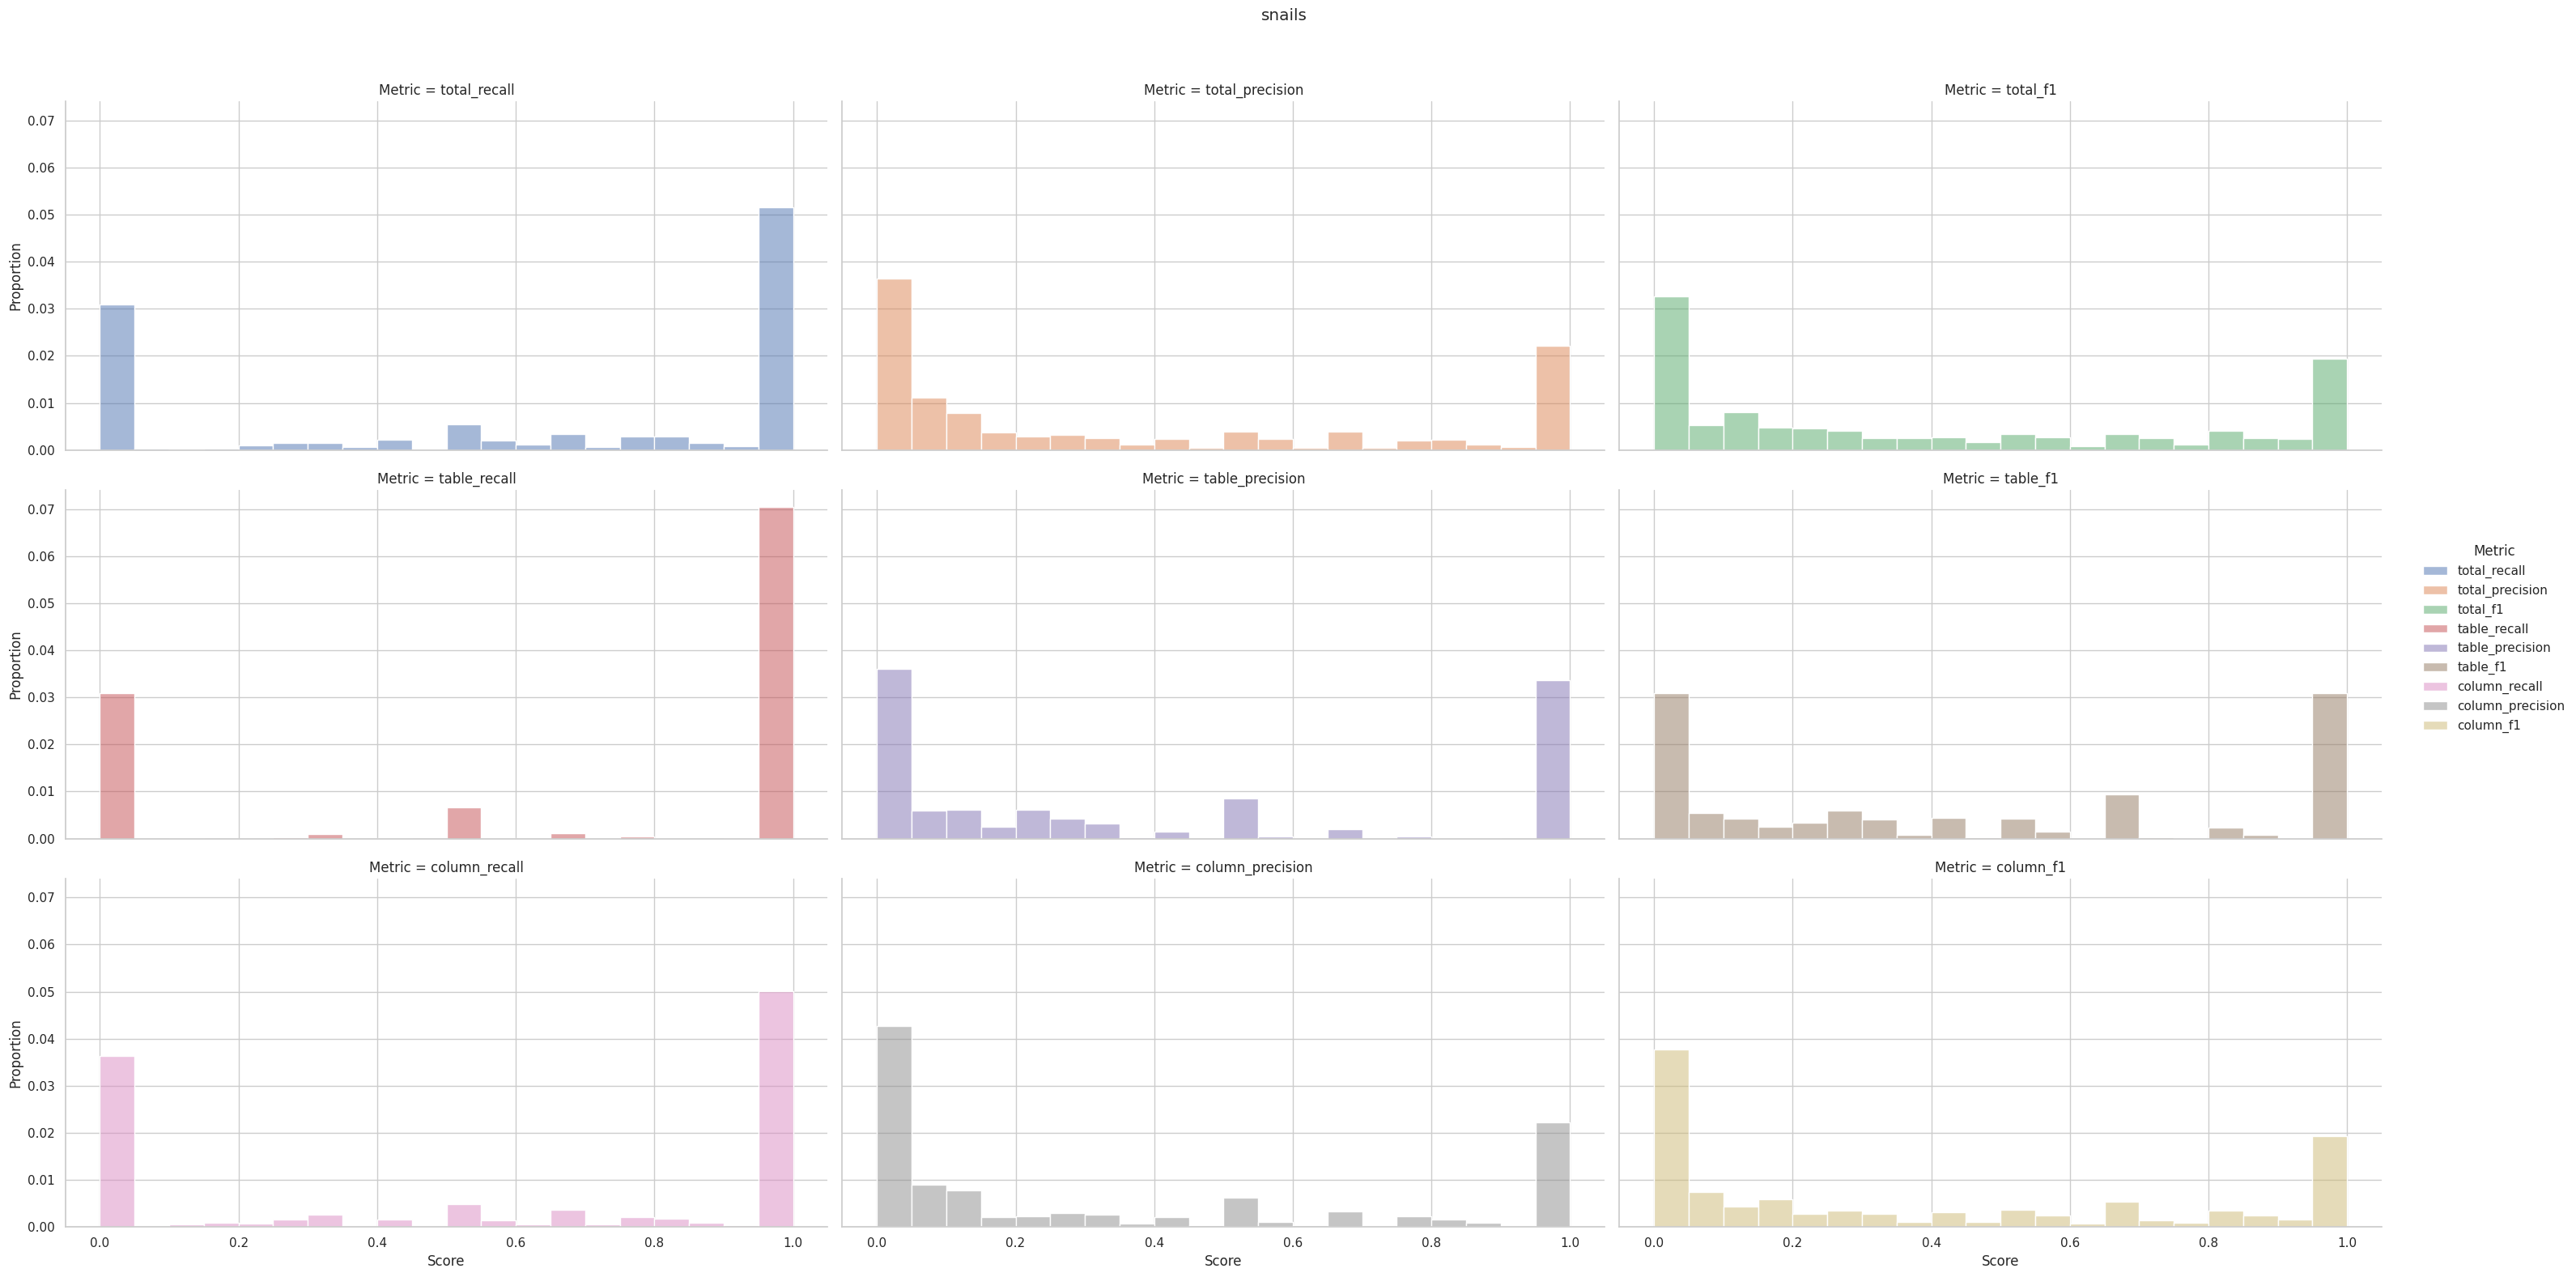

In [37]:
for bm in ["spider2", "bird", "snails"]:
    g = sns.displot(
        data=performance_df.query(f"benchmark=='{bm}' and prompt_tokens>=0 and eval_model").melt(
            id_vars=["benchmark", "subsetting_method"],
            value_vars=[
                "total_recall", "total_precision", "total_f1", 
                "table_recall", "table_precision", "table_f1",
                "column_recall", "column_precision", "column_f1"
                ],
            value_name="Score",
            var_name="Metric"
        ),
        x="Score",
        hue="Metric",
        kind="hist",
        stat="proportion",
        aspect=2,
        col="Metric",
        col_wrap=3,
        bins=20
    )
    g.figure.suptitle(bm, y=1.05)

### Recall, precision, and f1 by method and benchmark

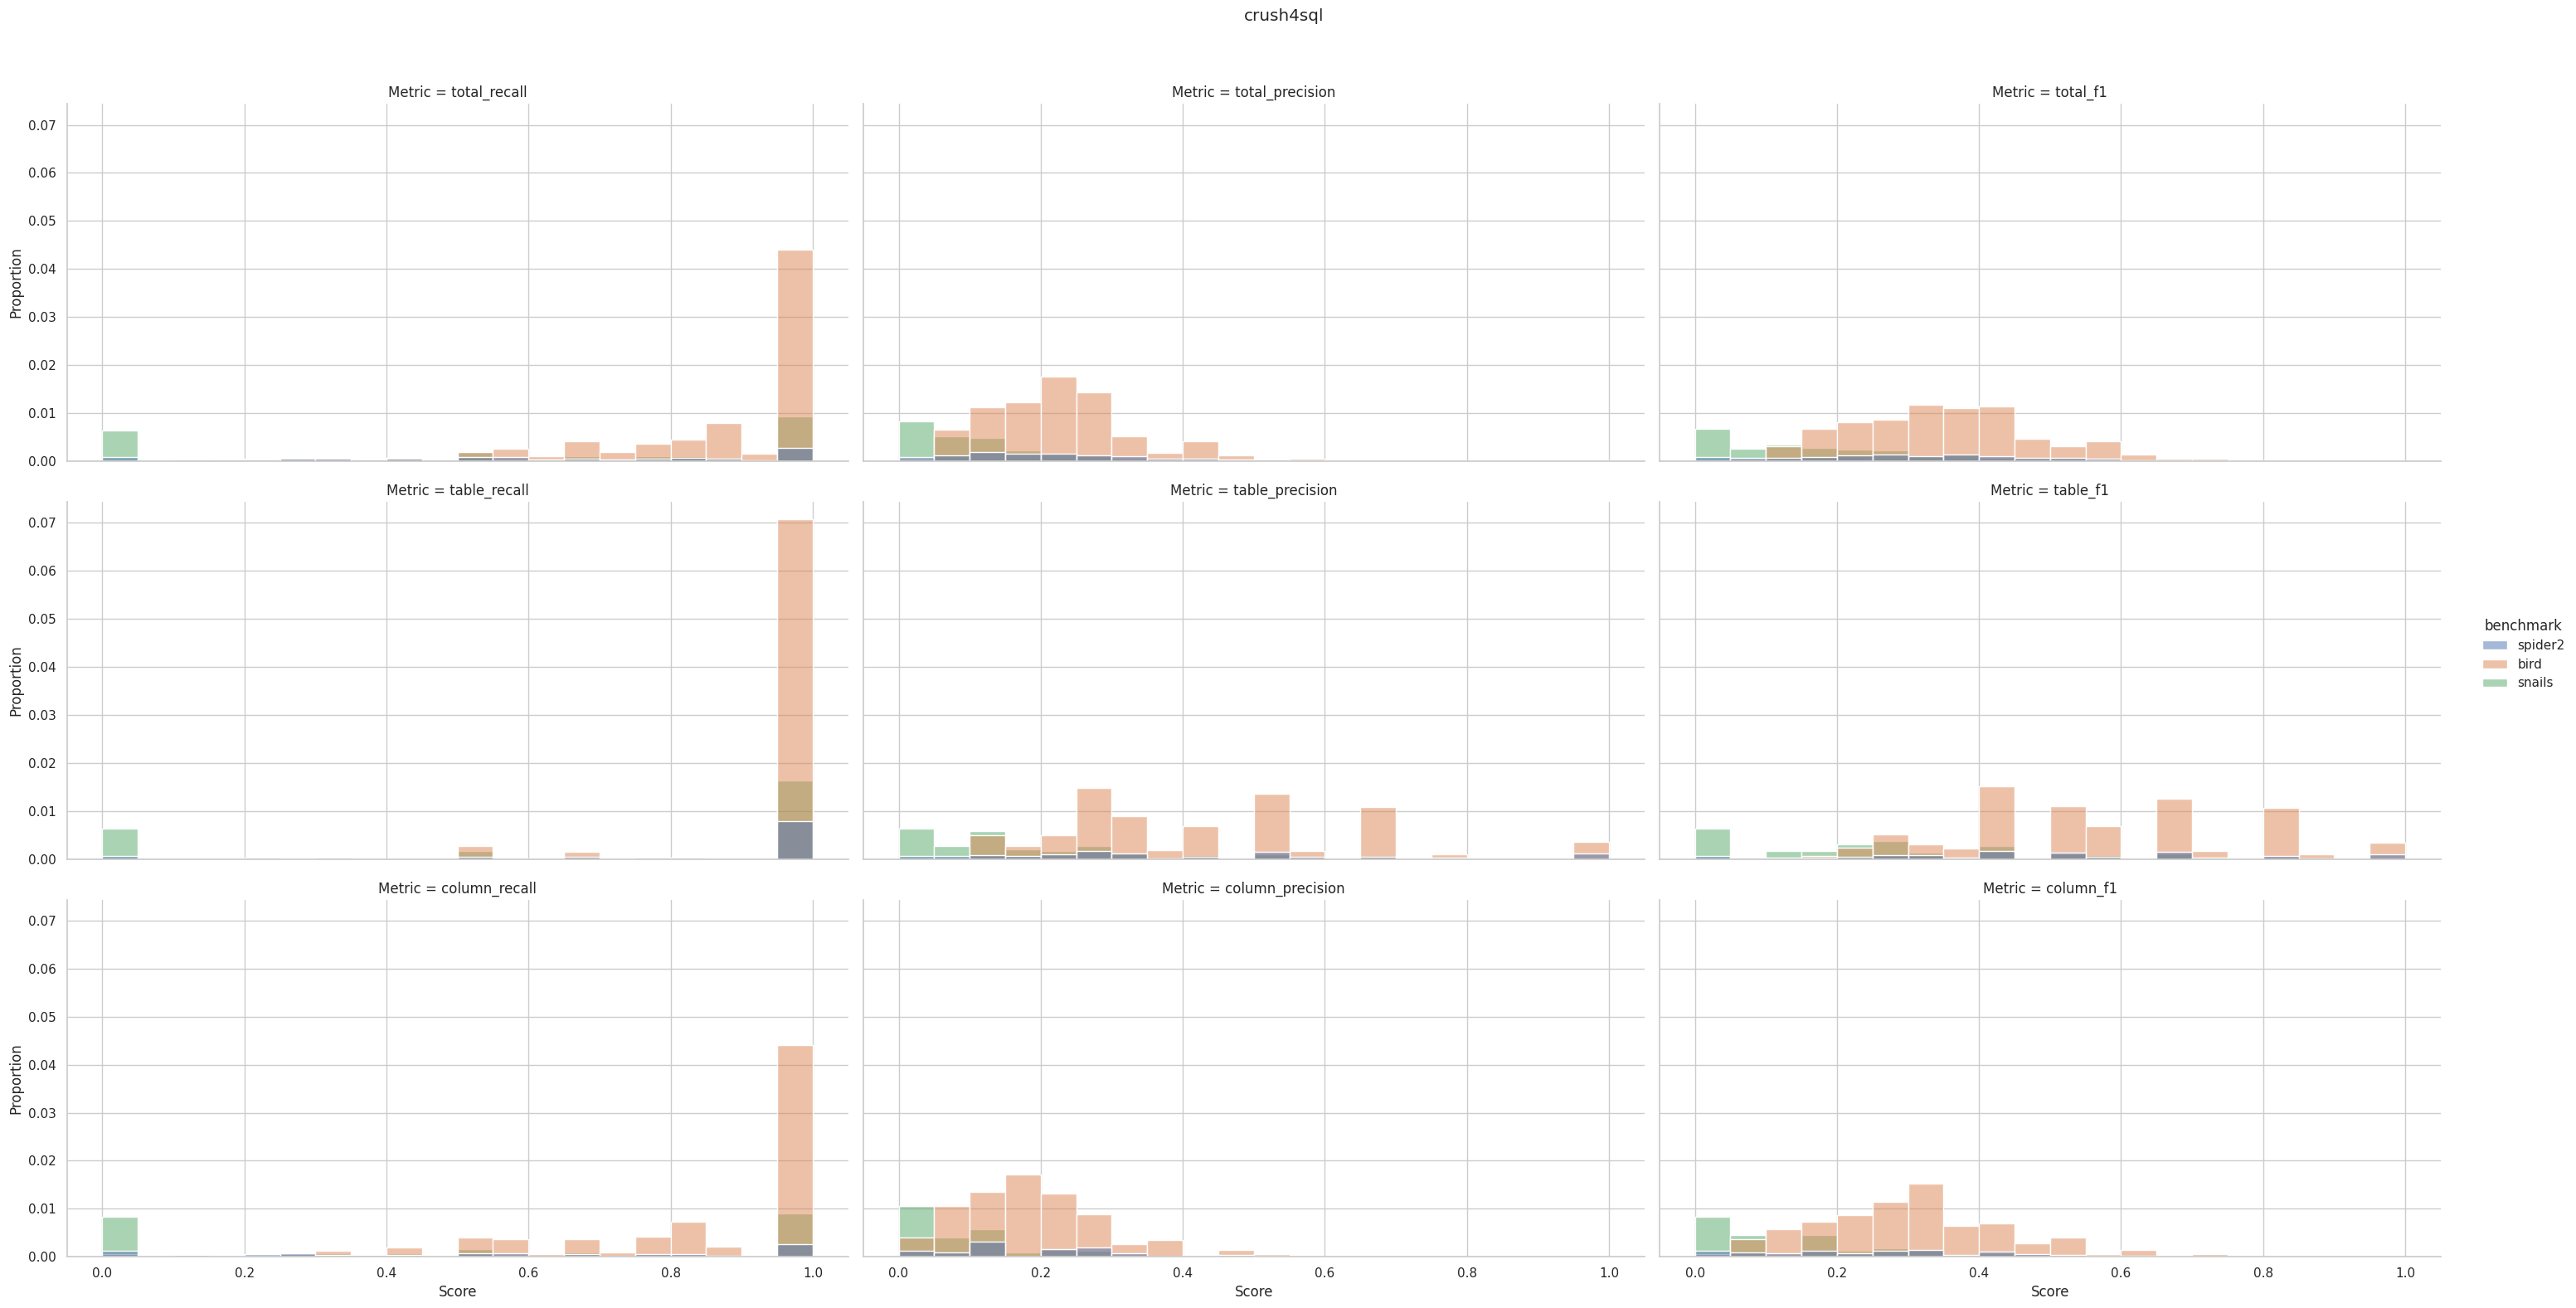

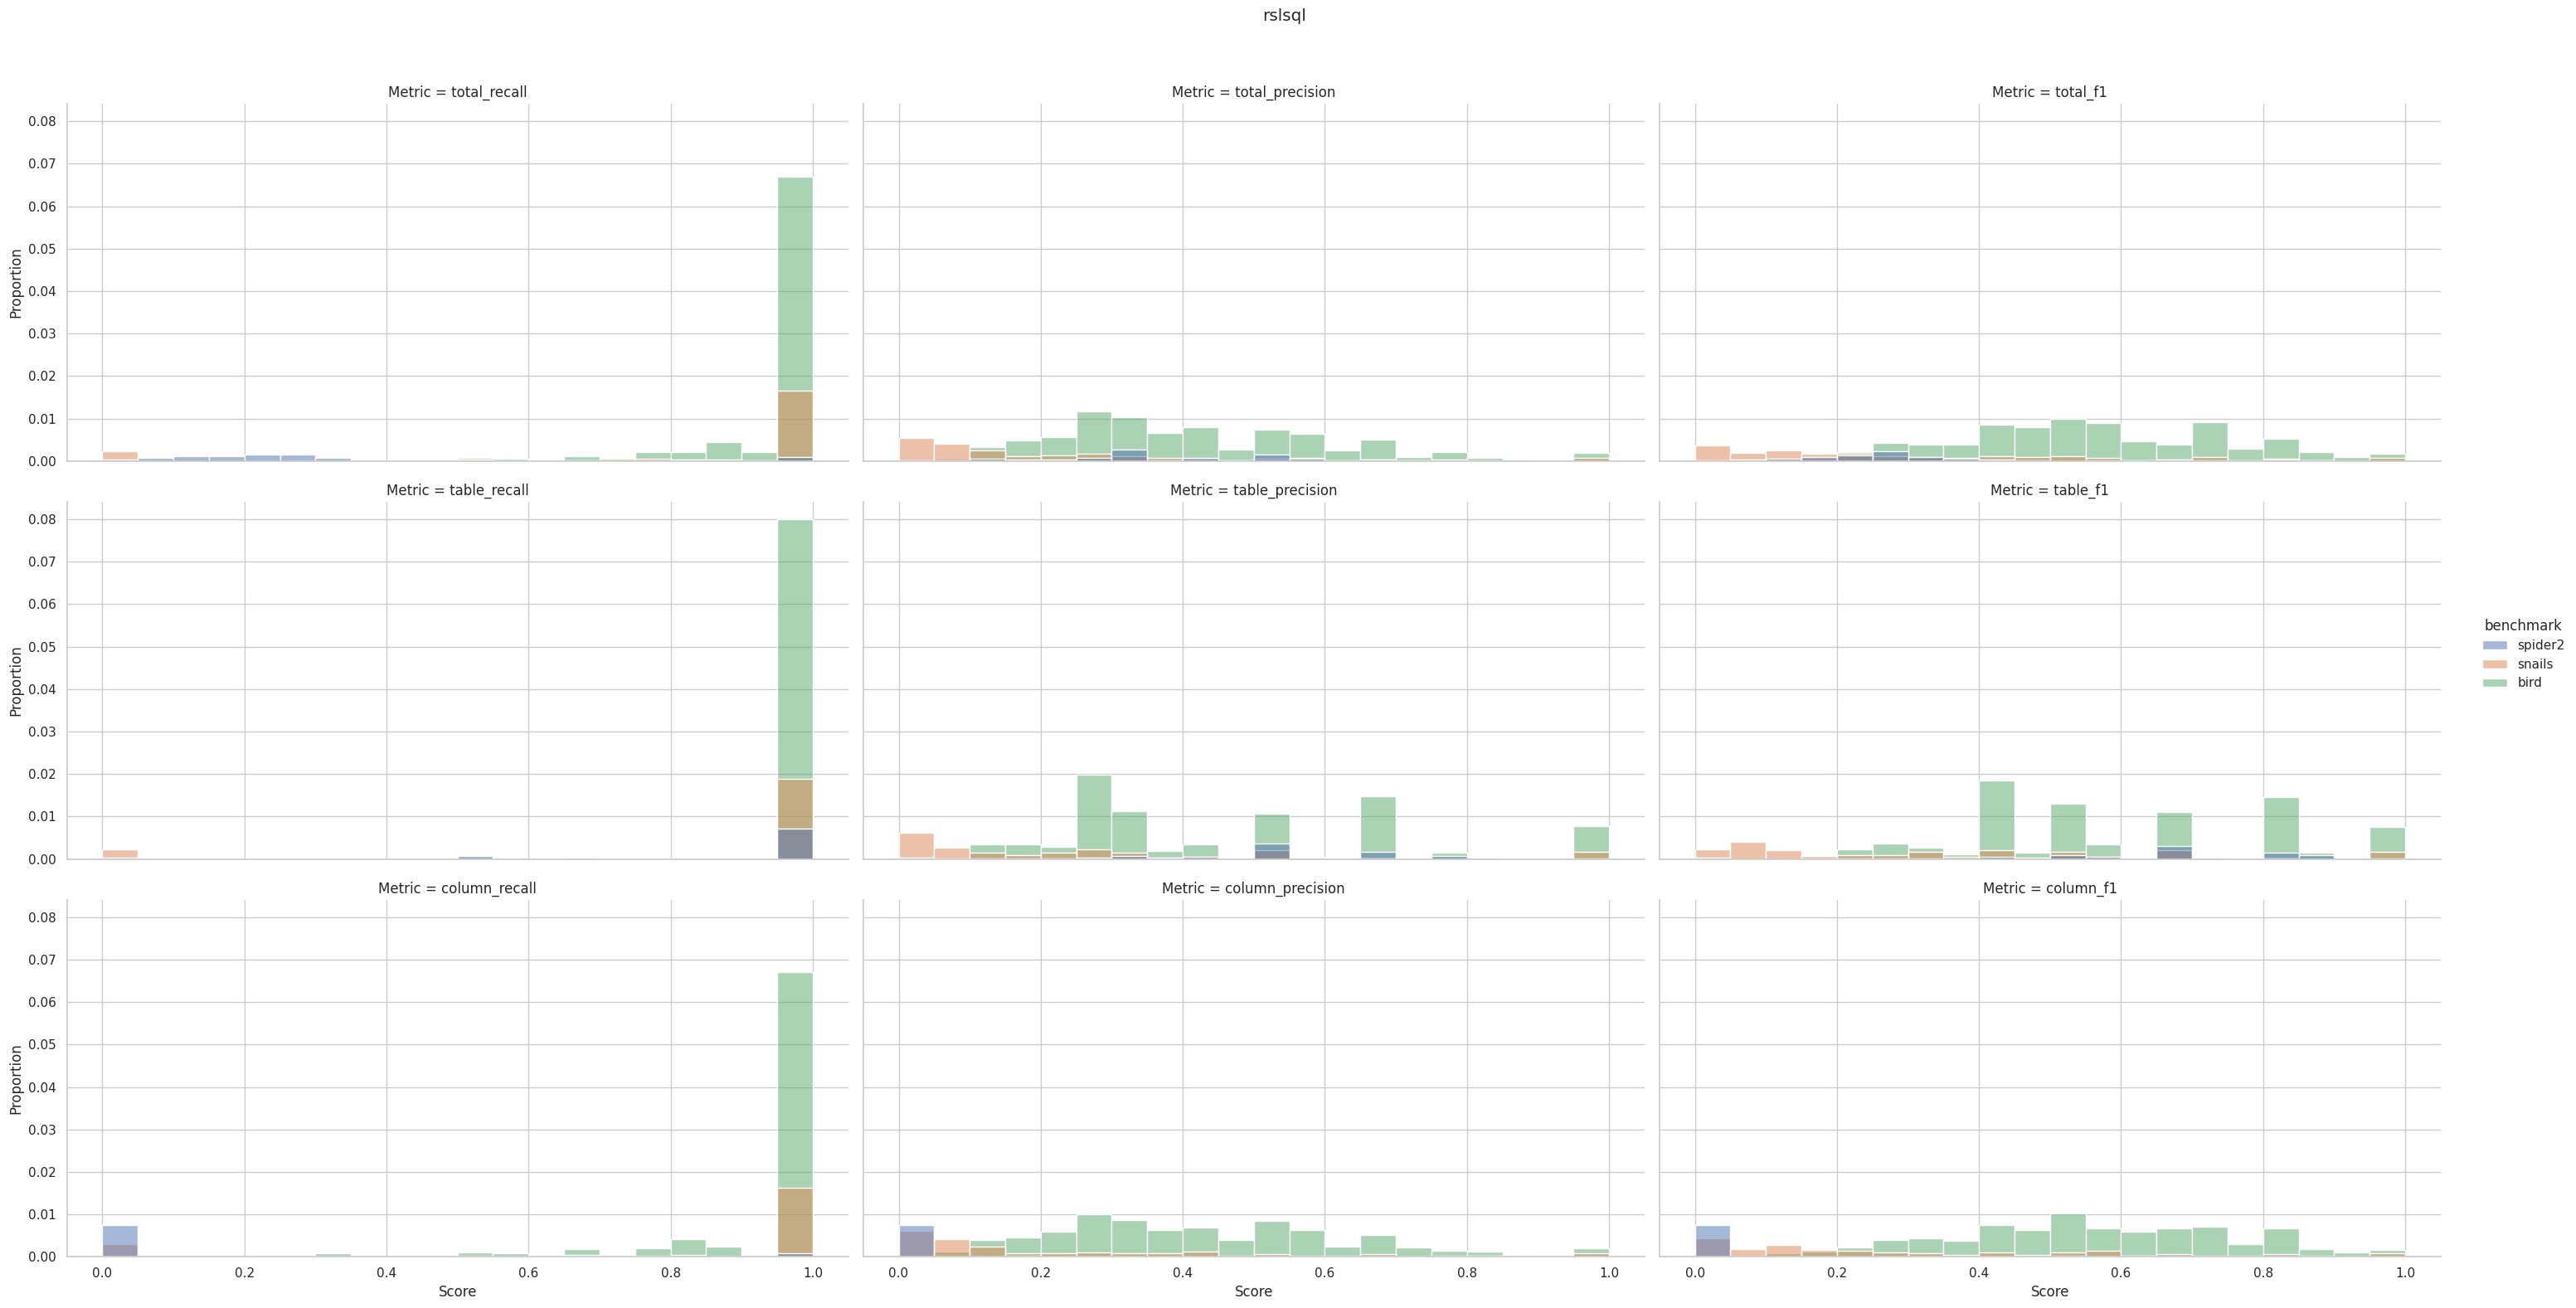

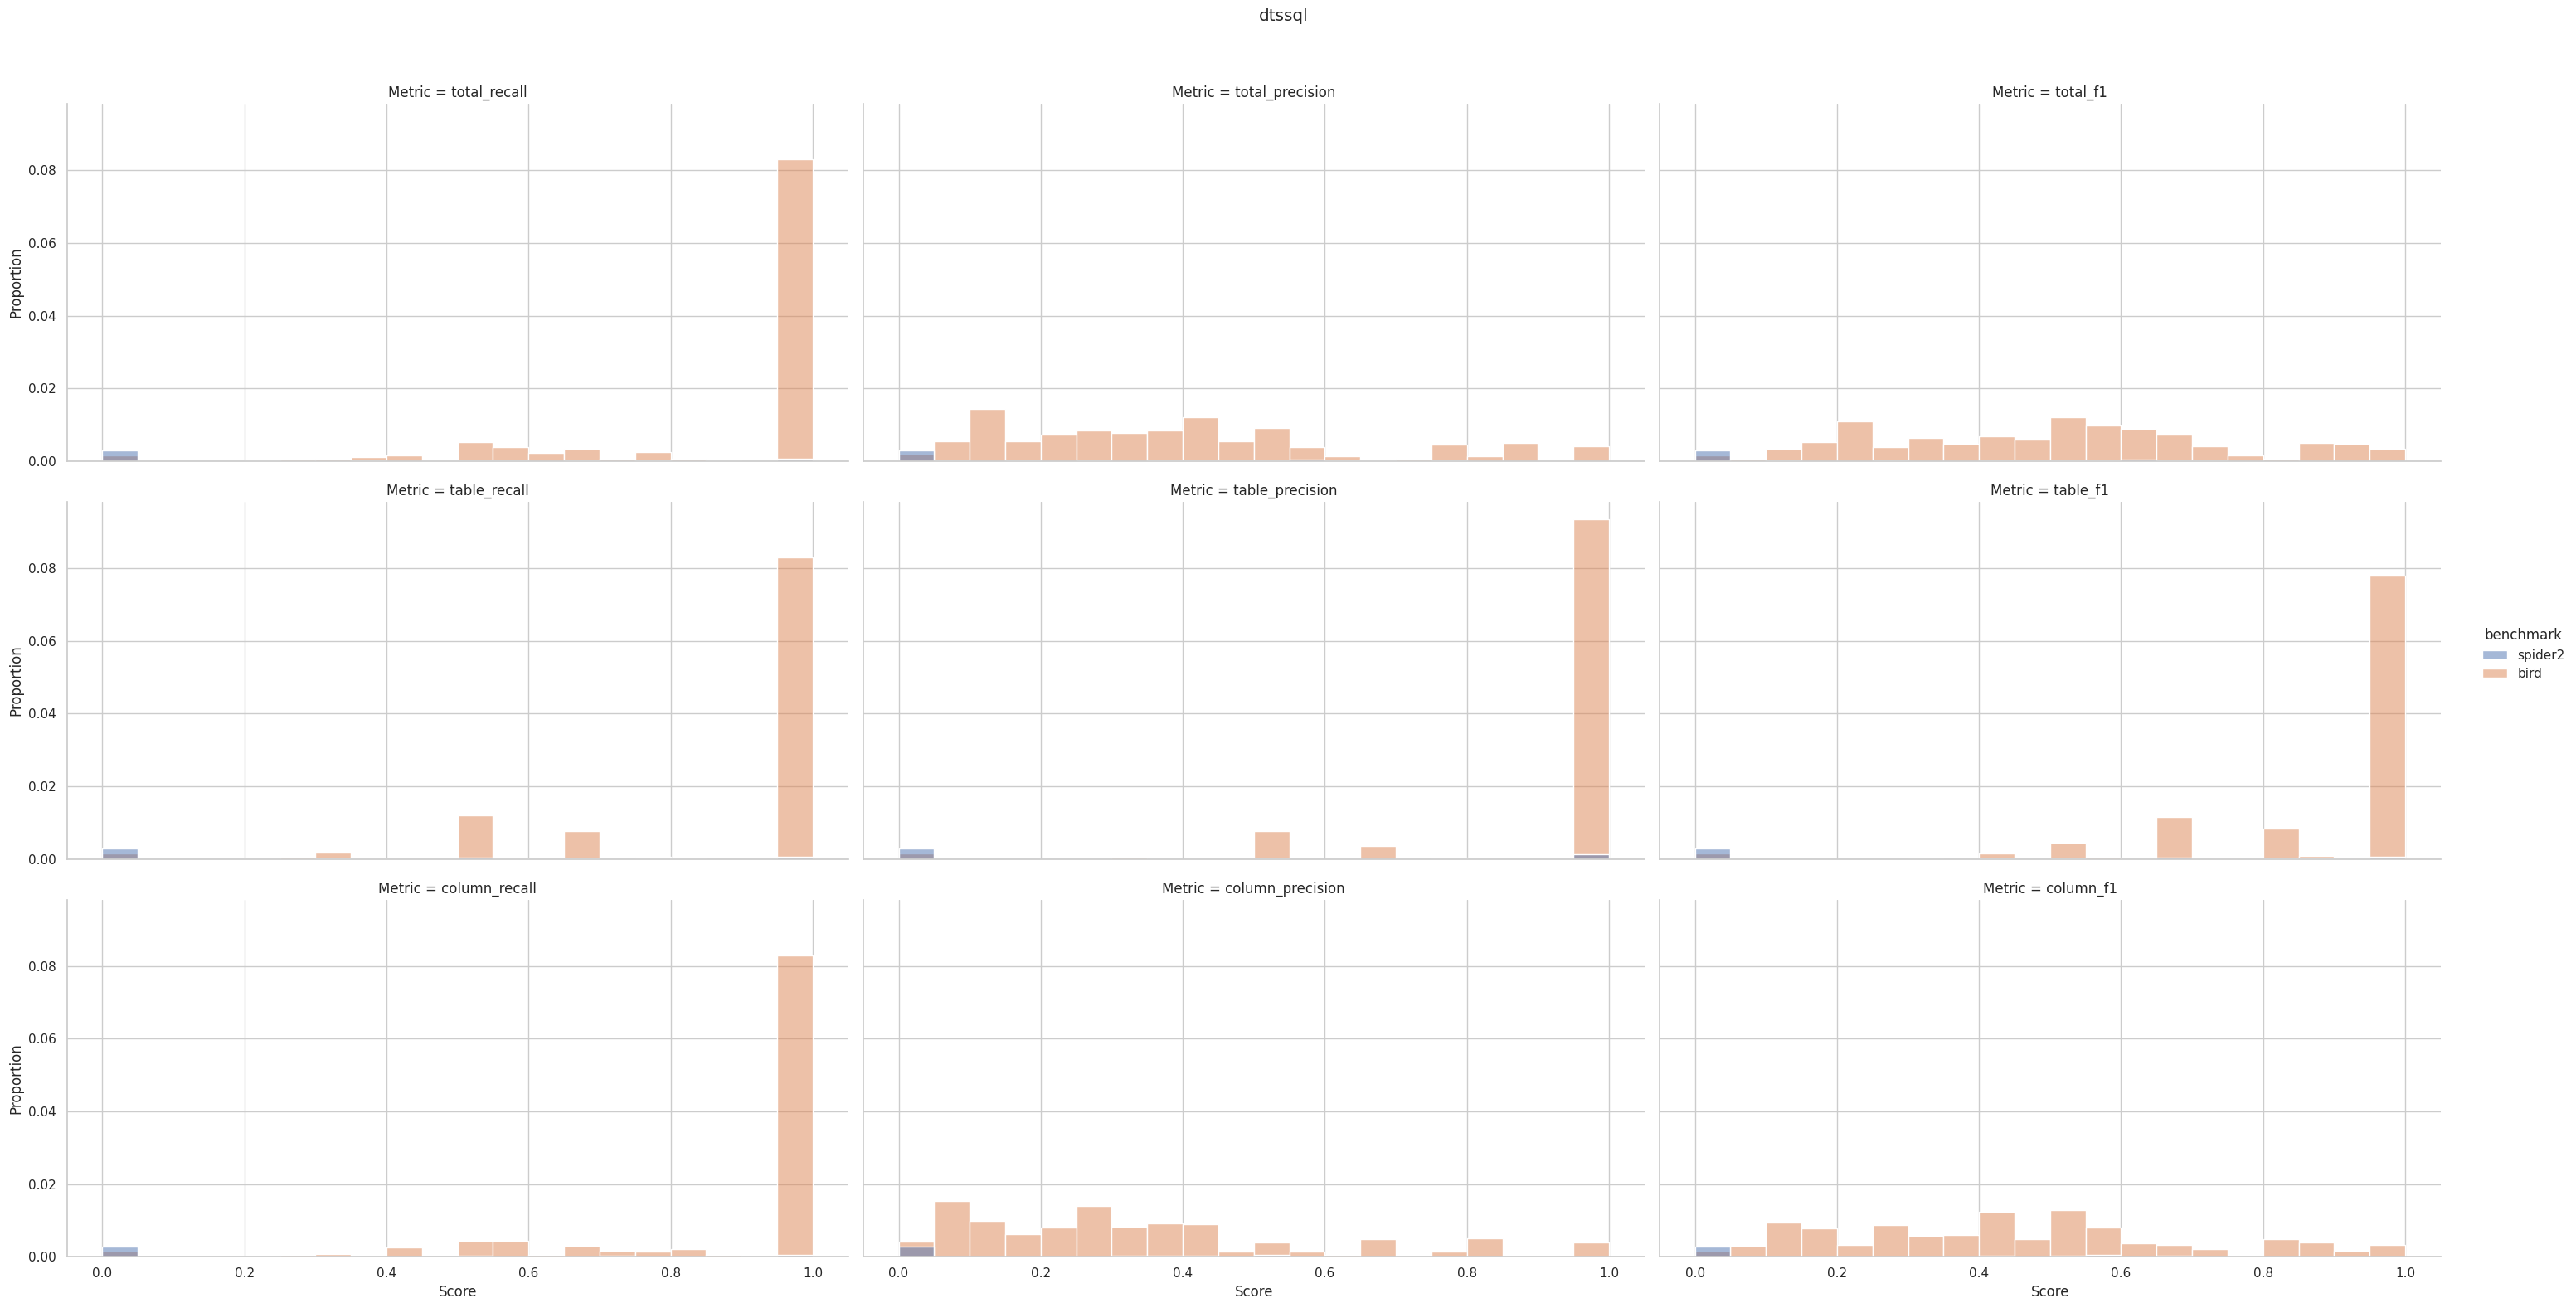

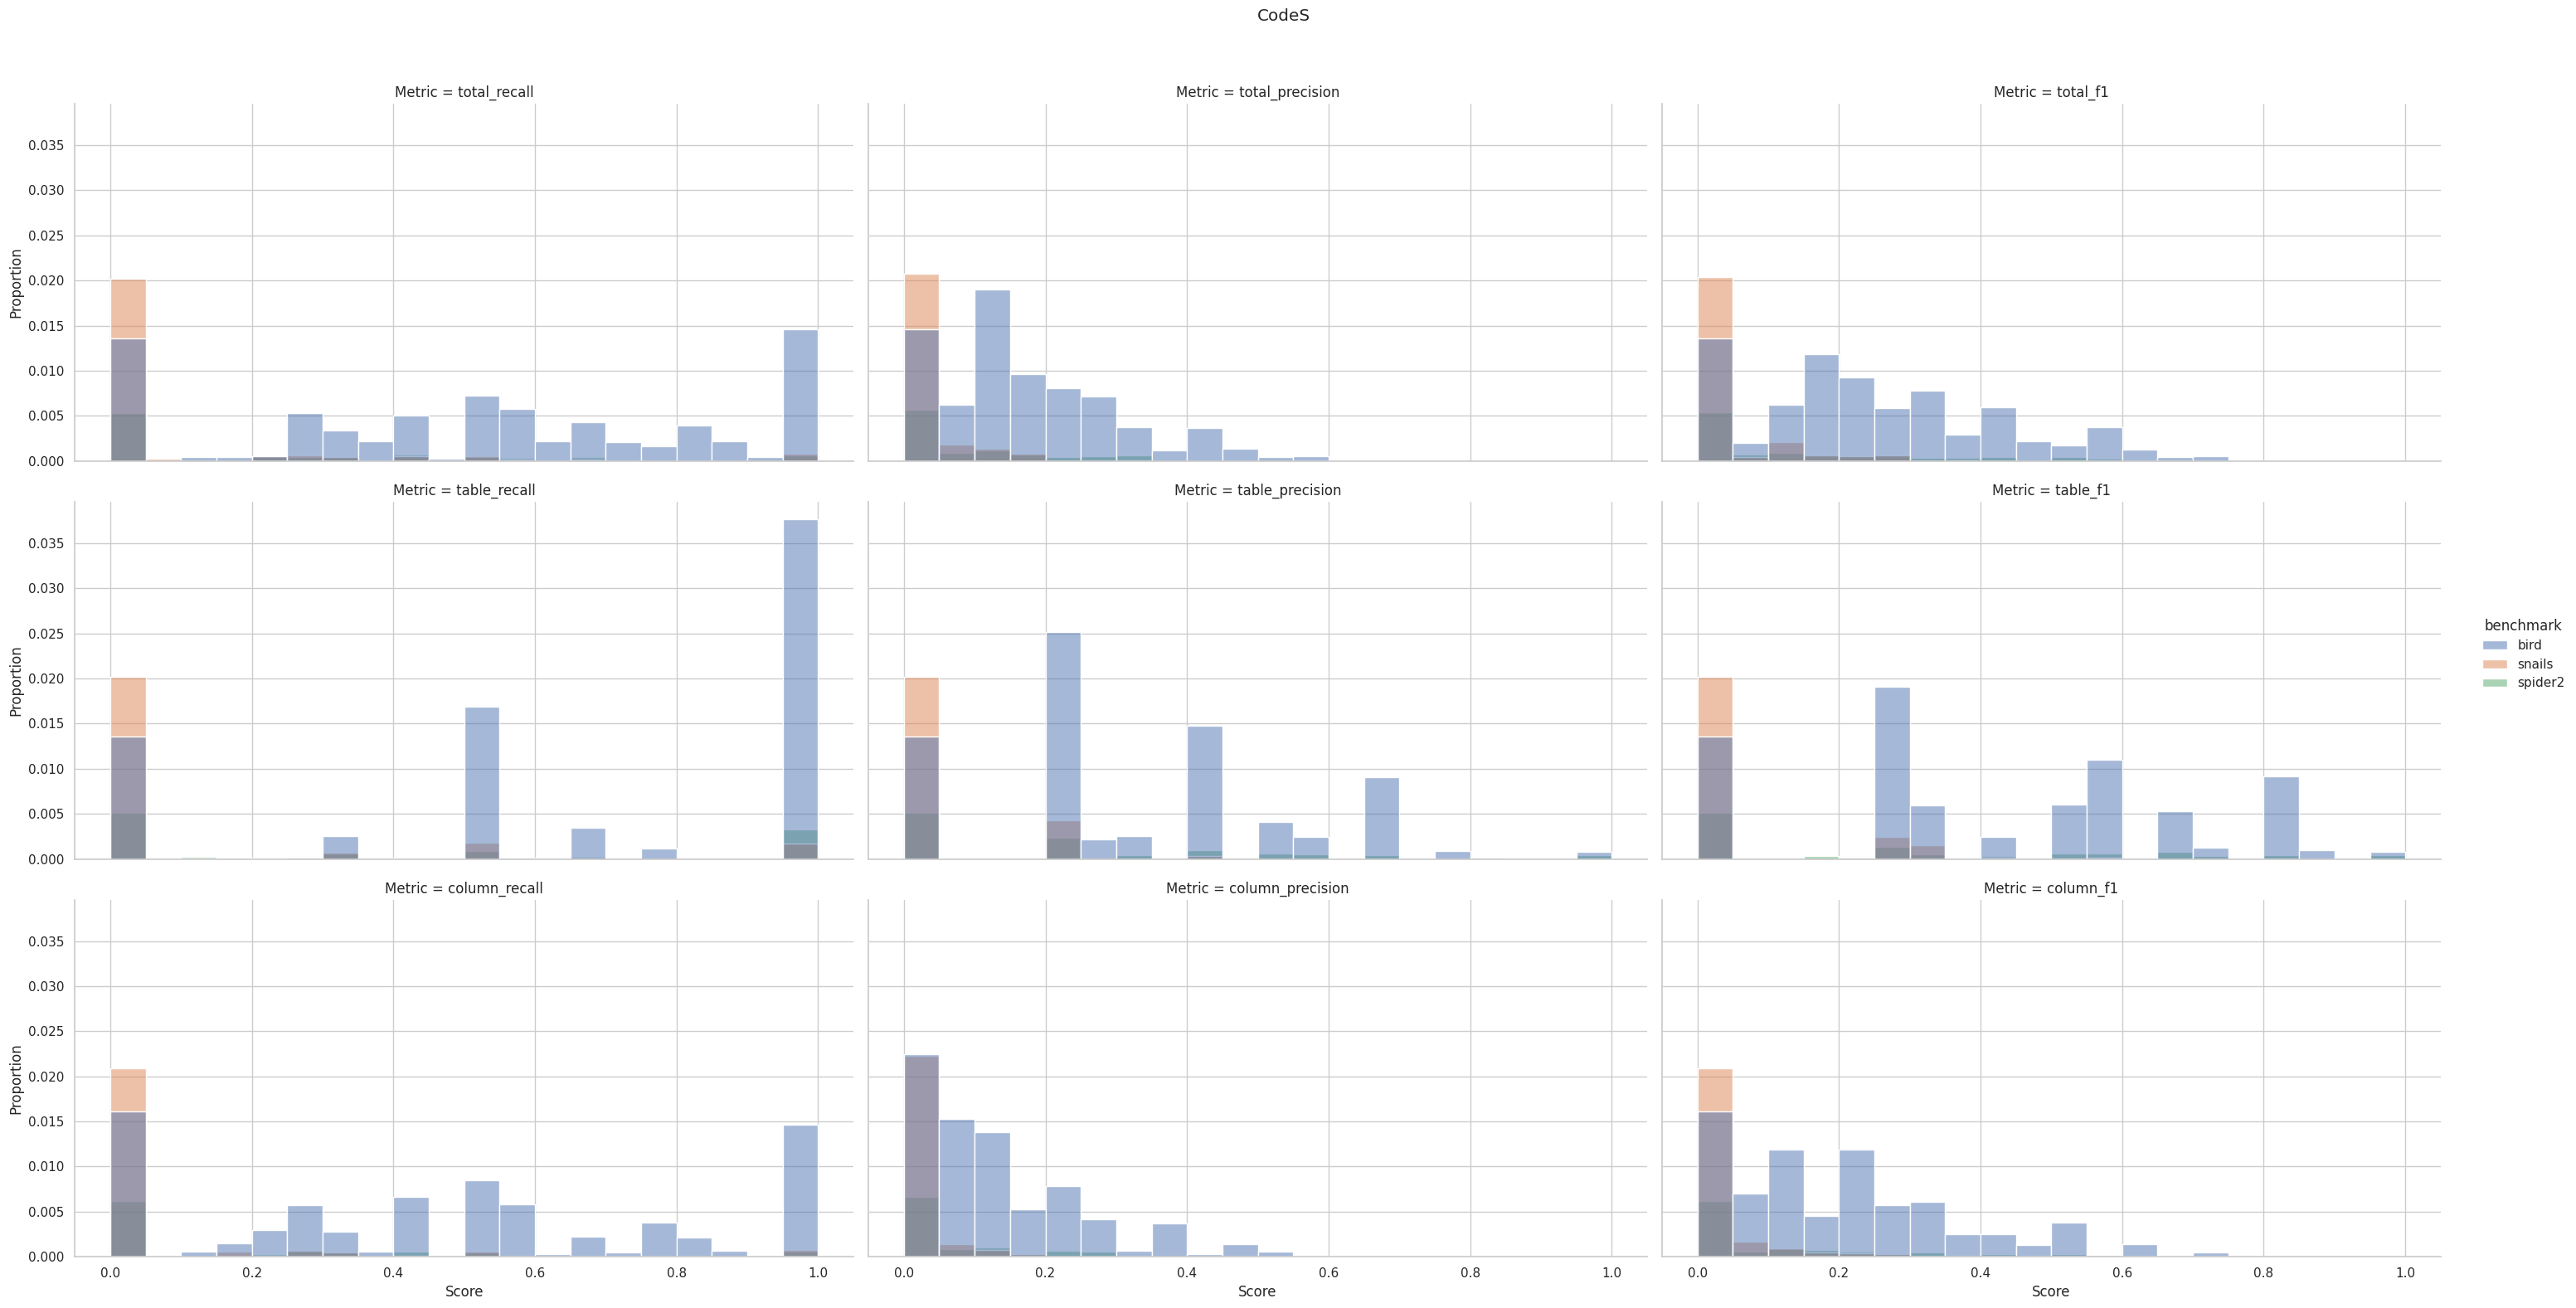

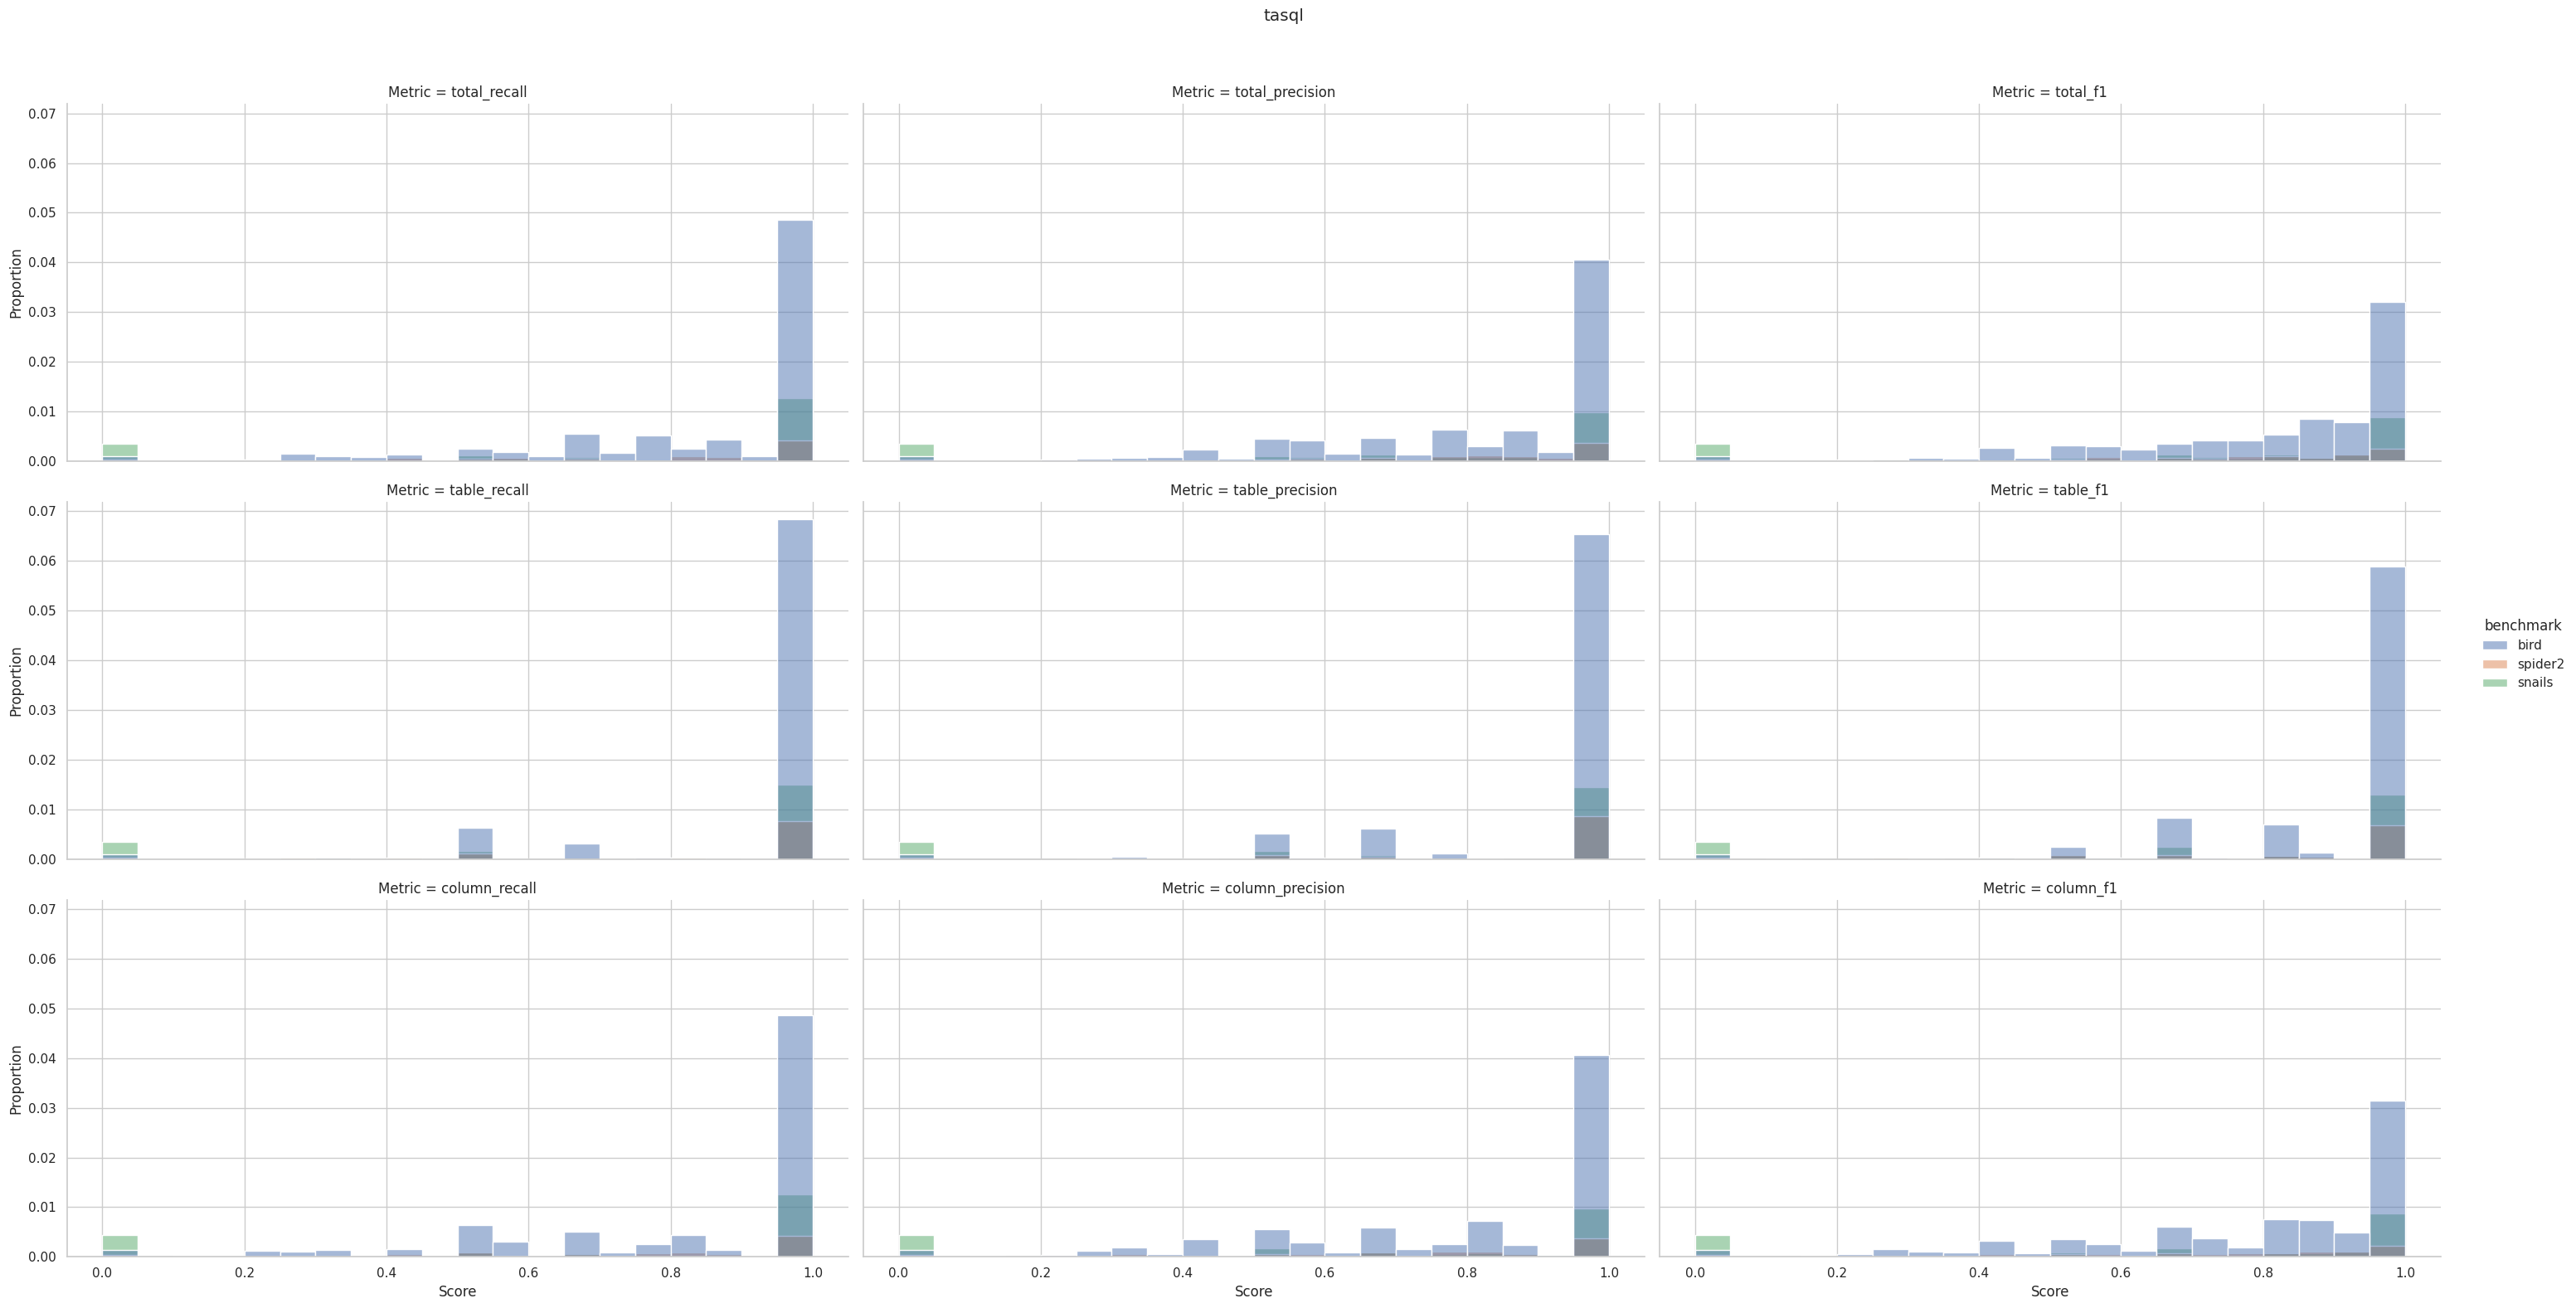

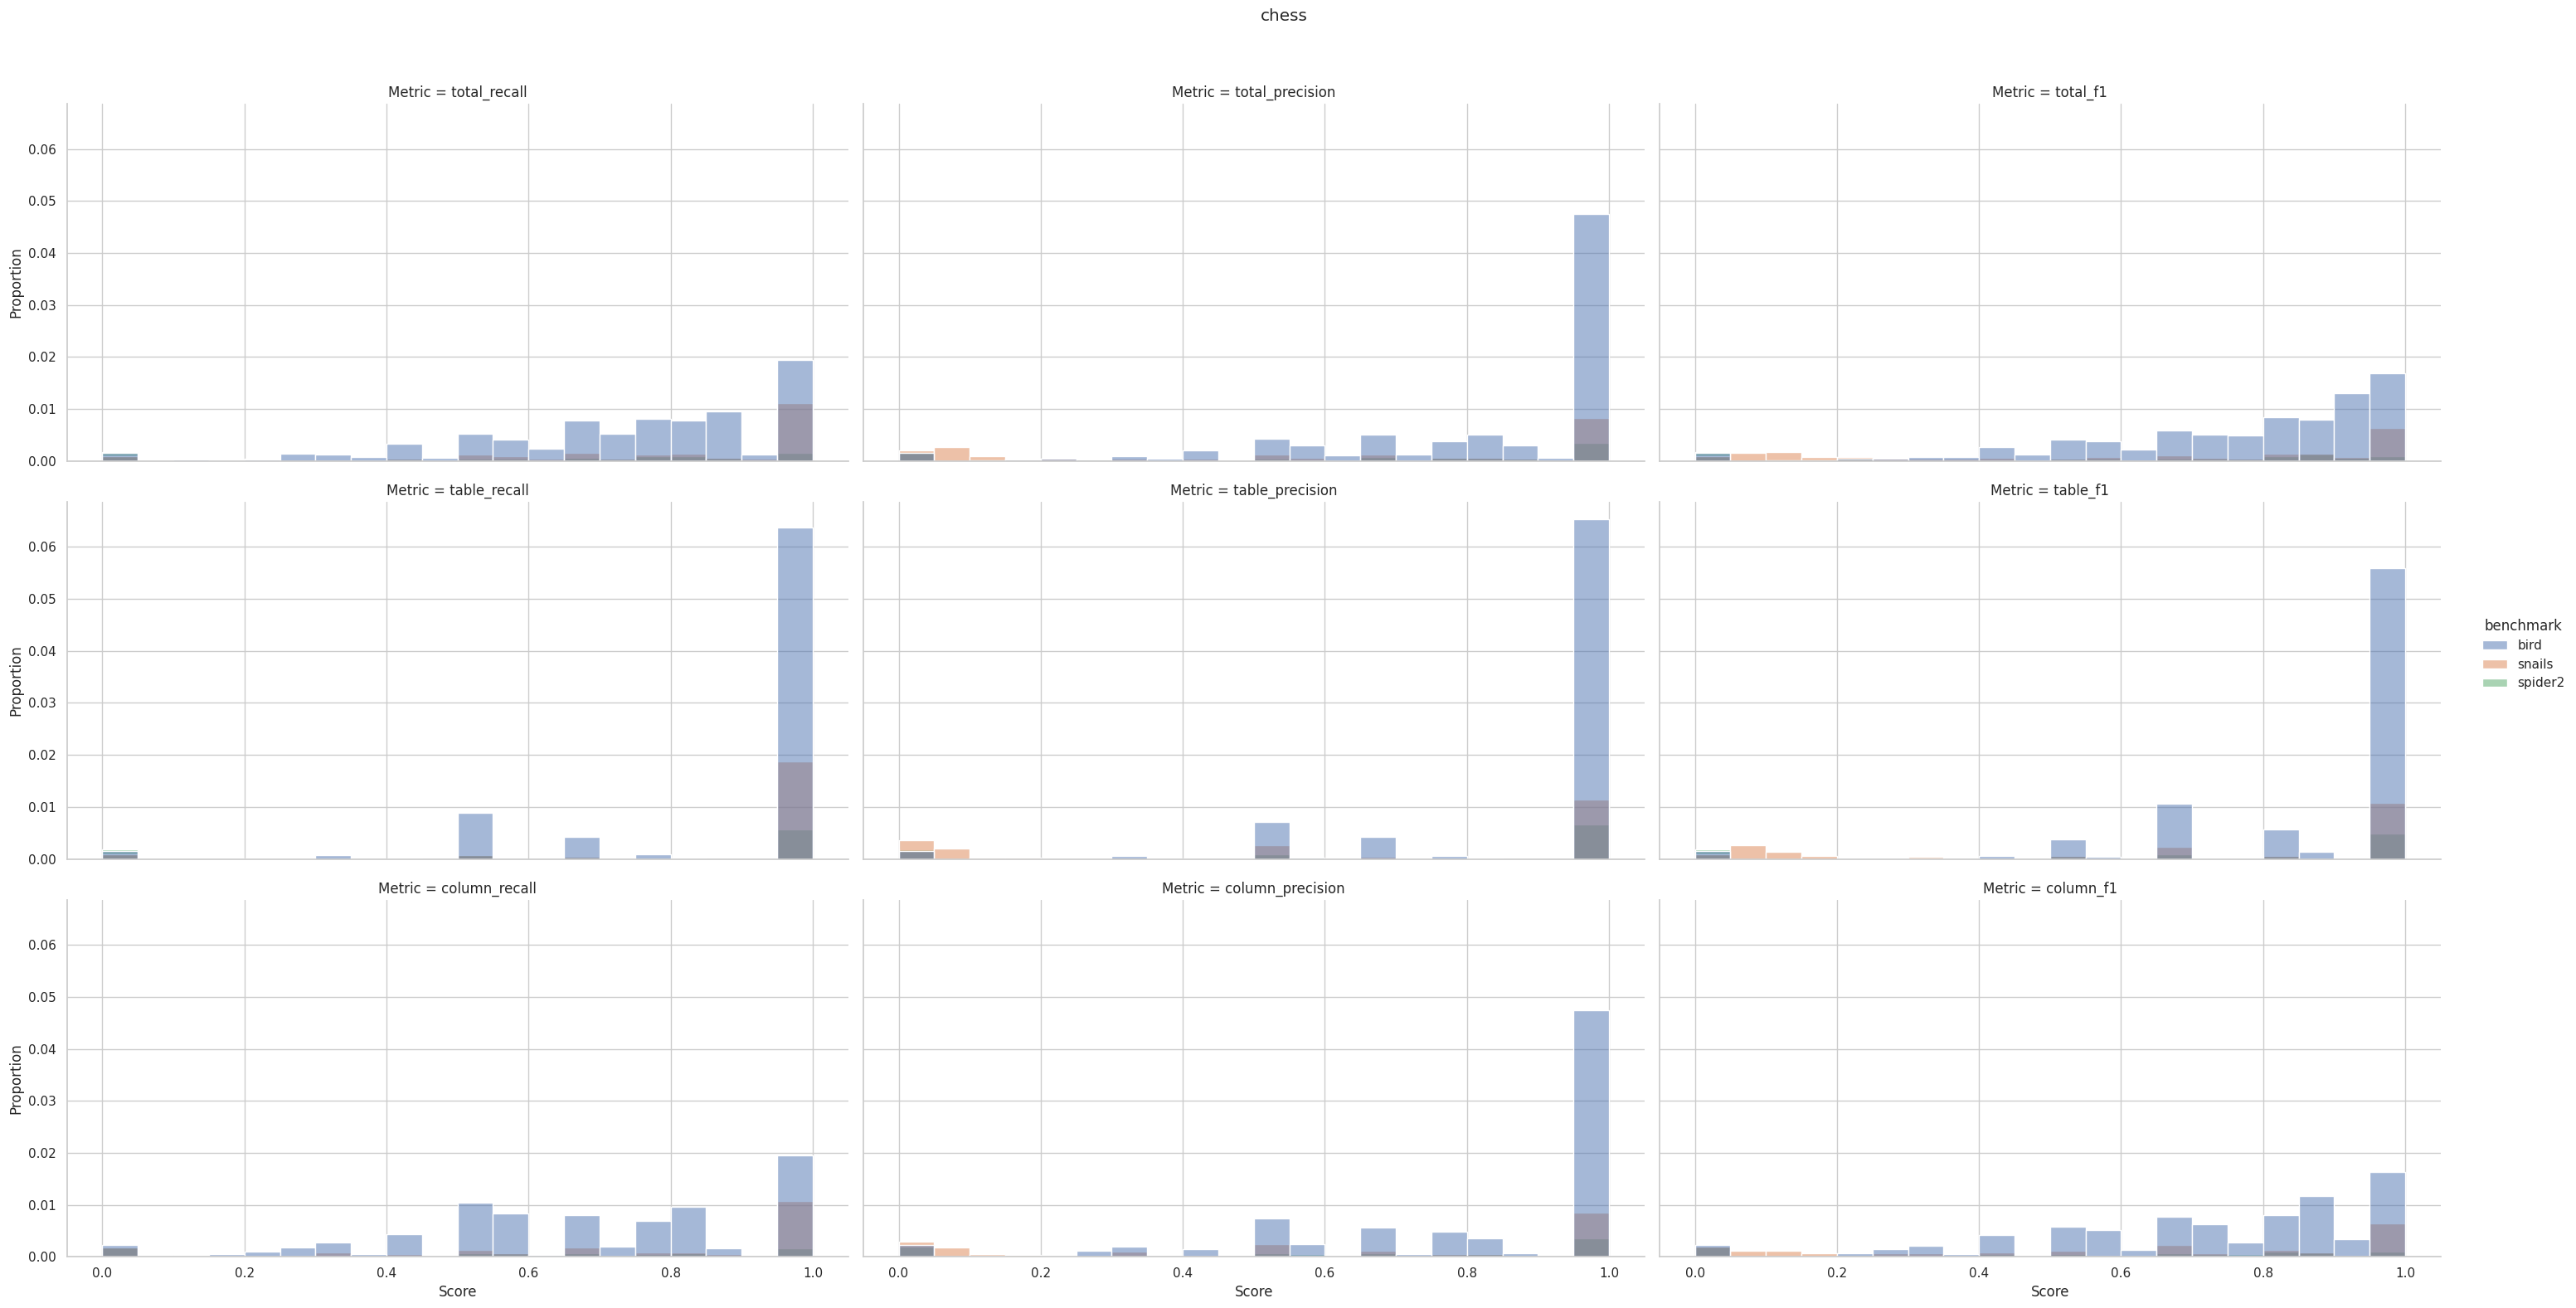

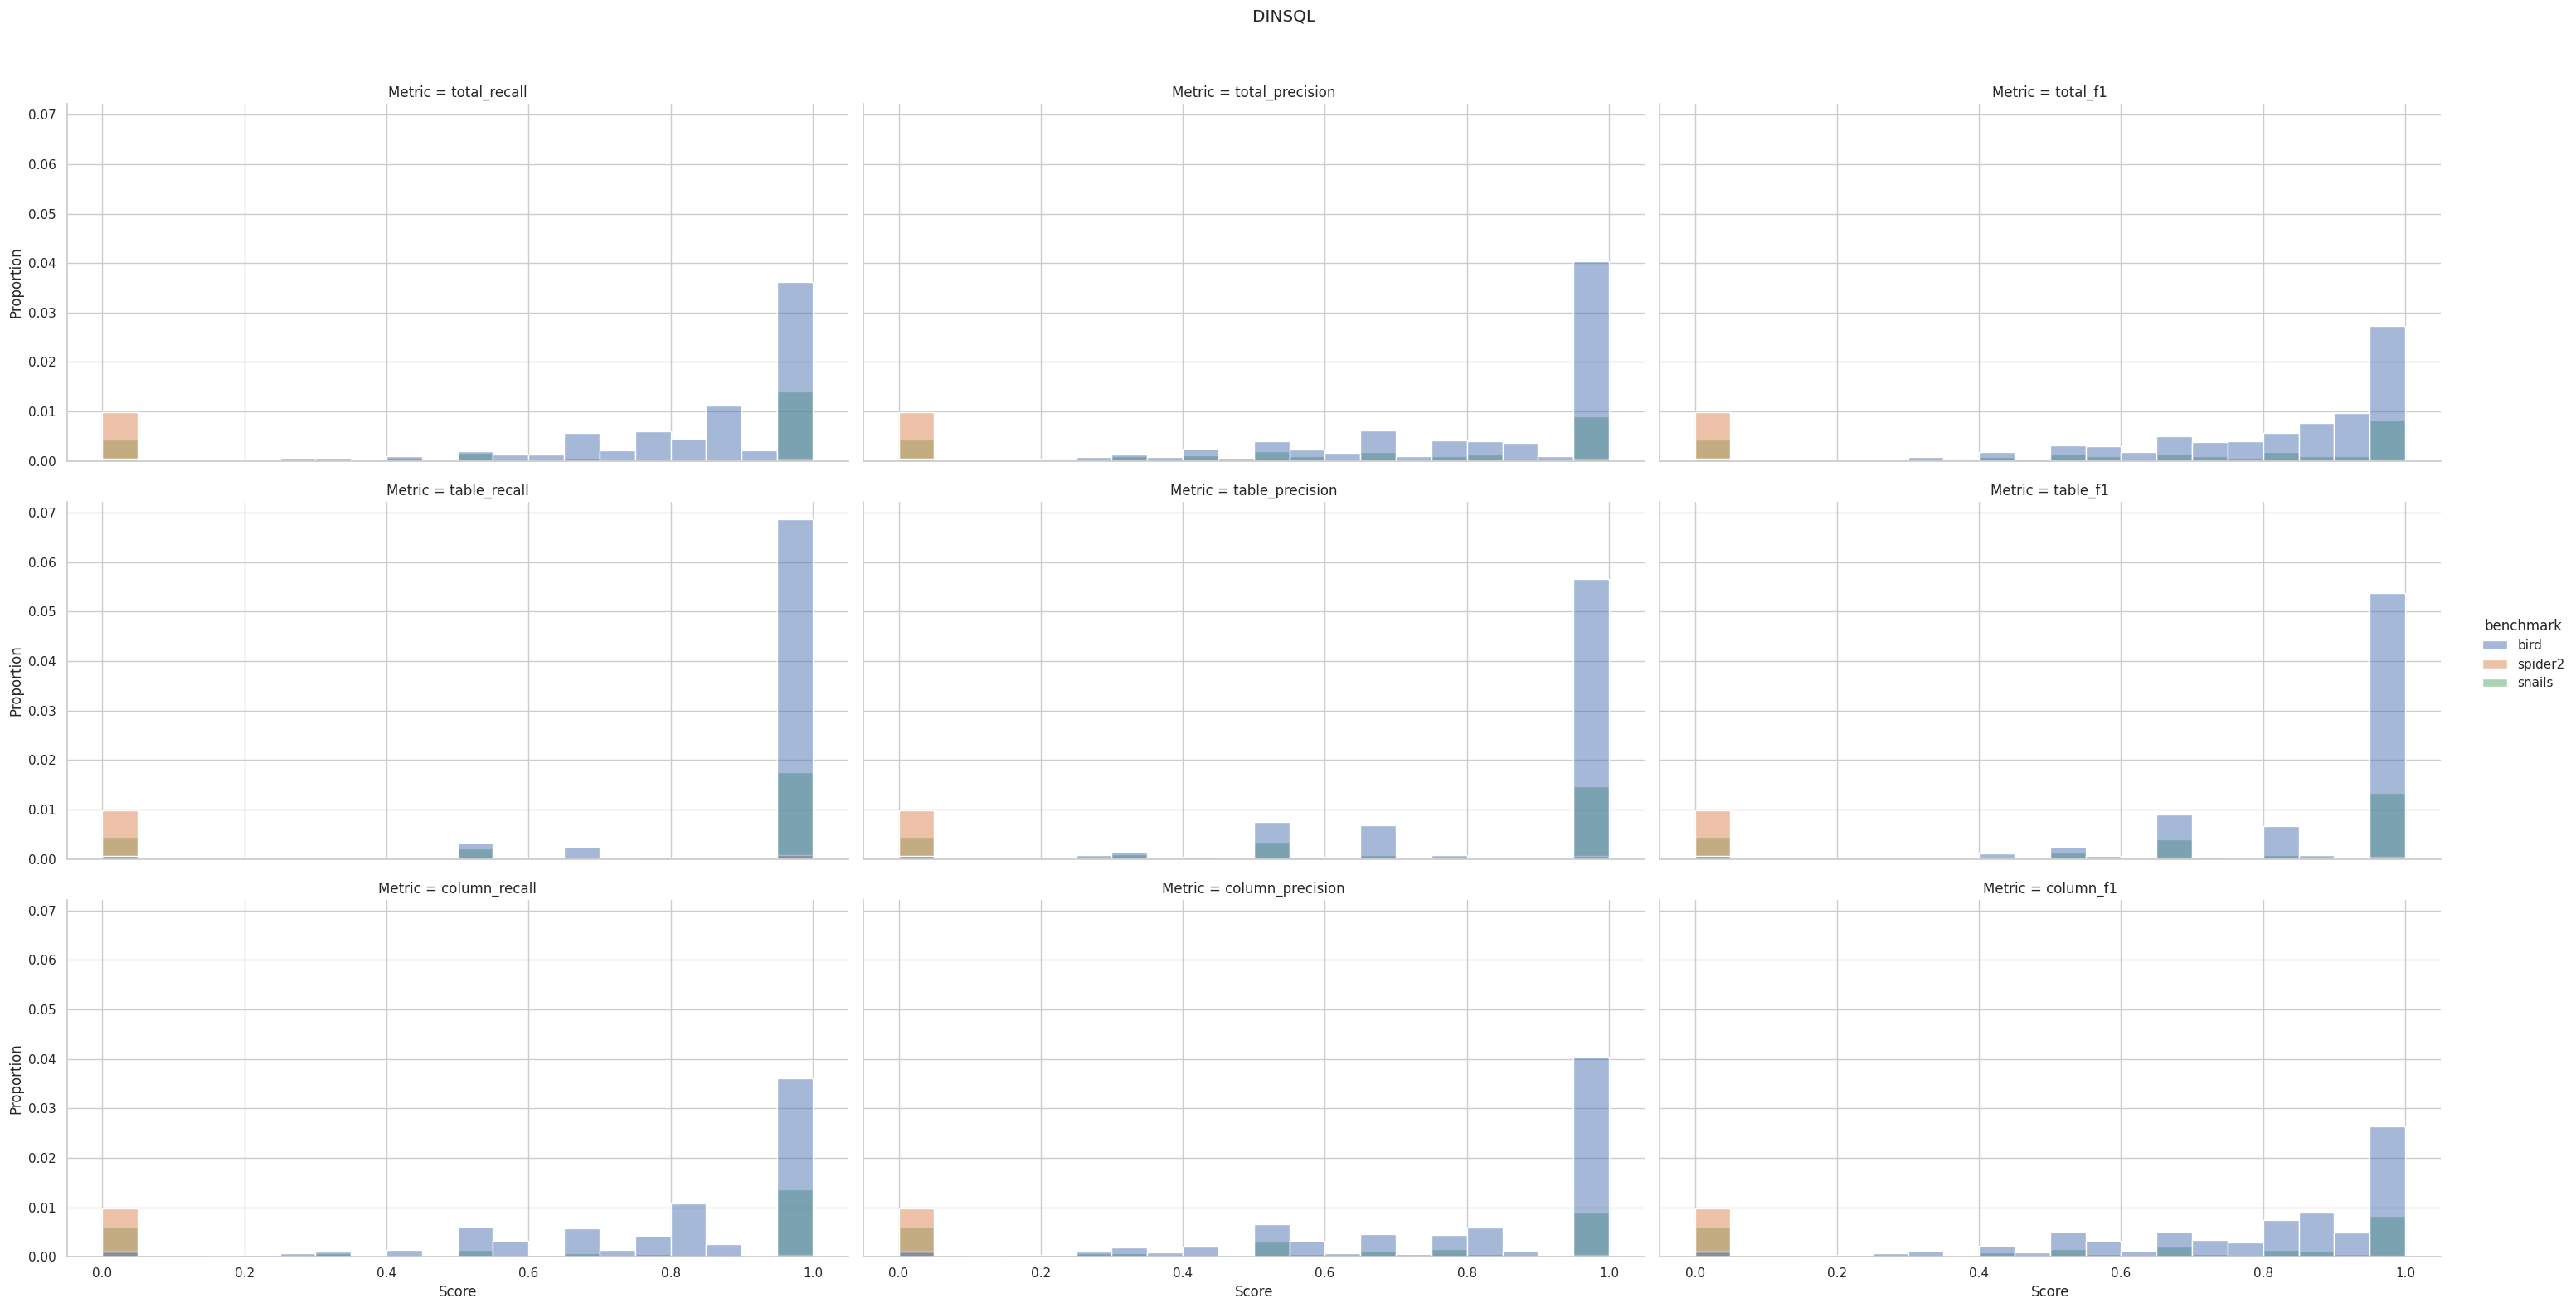

In [47]:
for sm in performance_df.subsetting_method.unique():
    temp_data_df = performance_df.query(f"subsetting_method=='{sm}' and prompt_tokens>=0 and eval_model").melt(
            id_vars=["benchmark", "subsetting_method"],
            value_vars=[
                "total_recall", "total_precision", "total_f1", 
                "table_recall", "table_precision", "table_f1",
                "column_recall", "column_precision", "column_f1"
                ],
            value_name="Score",
            var_name="Metric"
        )
    if temp_data_df.shape[0] == 0:
        continue
    g = sns.displot(
        data=temp_data_df,
        x="Score",
        hue="benchmark",
        kind="hist",
        stat="proportion",
        aspect=2,
        col="Metric",
        col_wrap=3,
        bins=20
    )
    g.figure.suptitle(sm, y=1.05)

## Diagnosis

### Hidden tables and ambiguous extra table counts by subsetting method

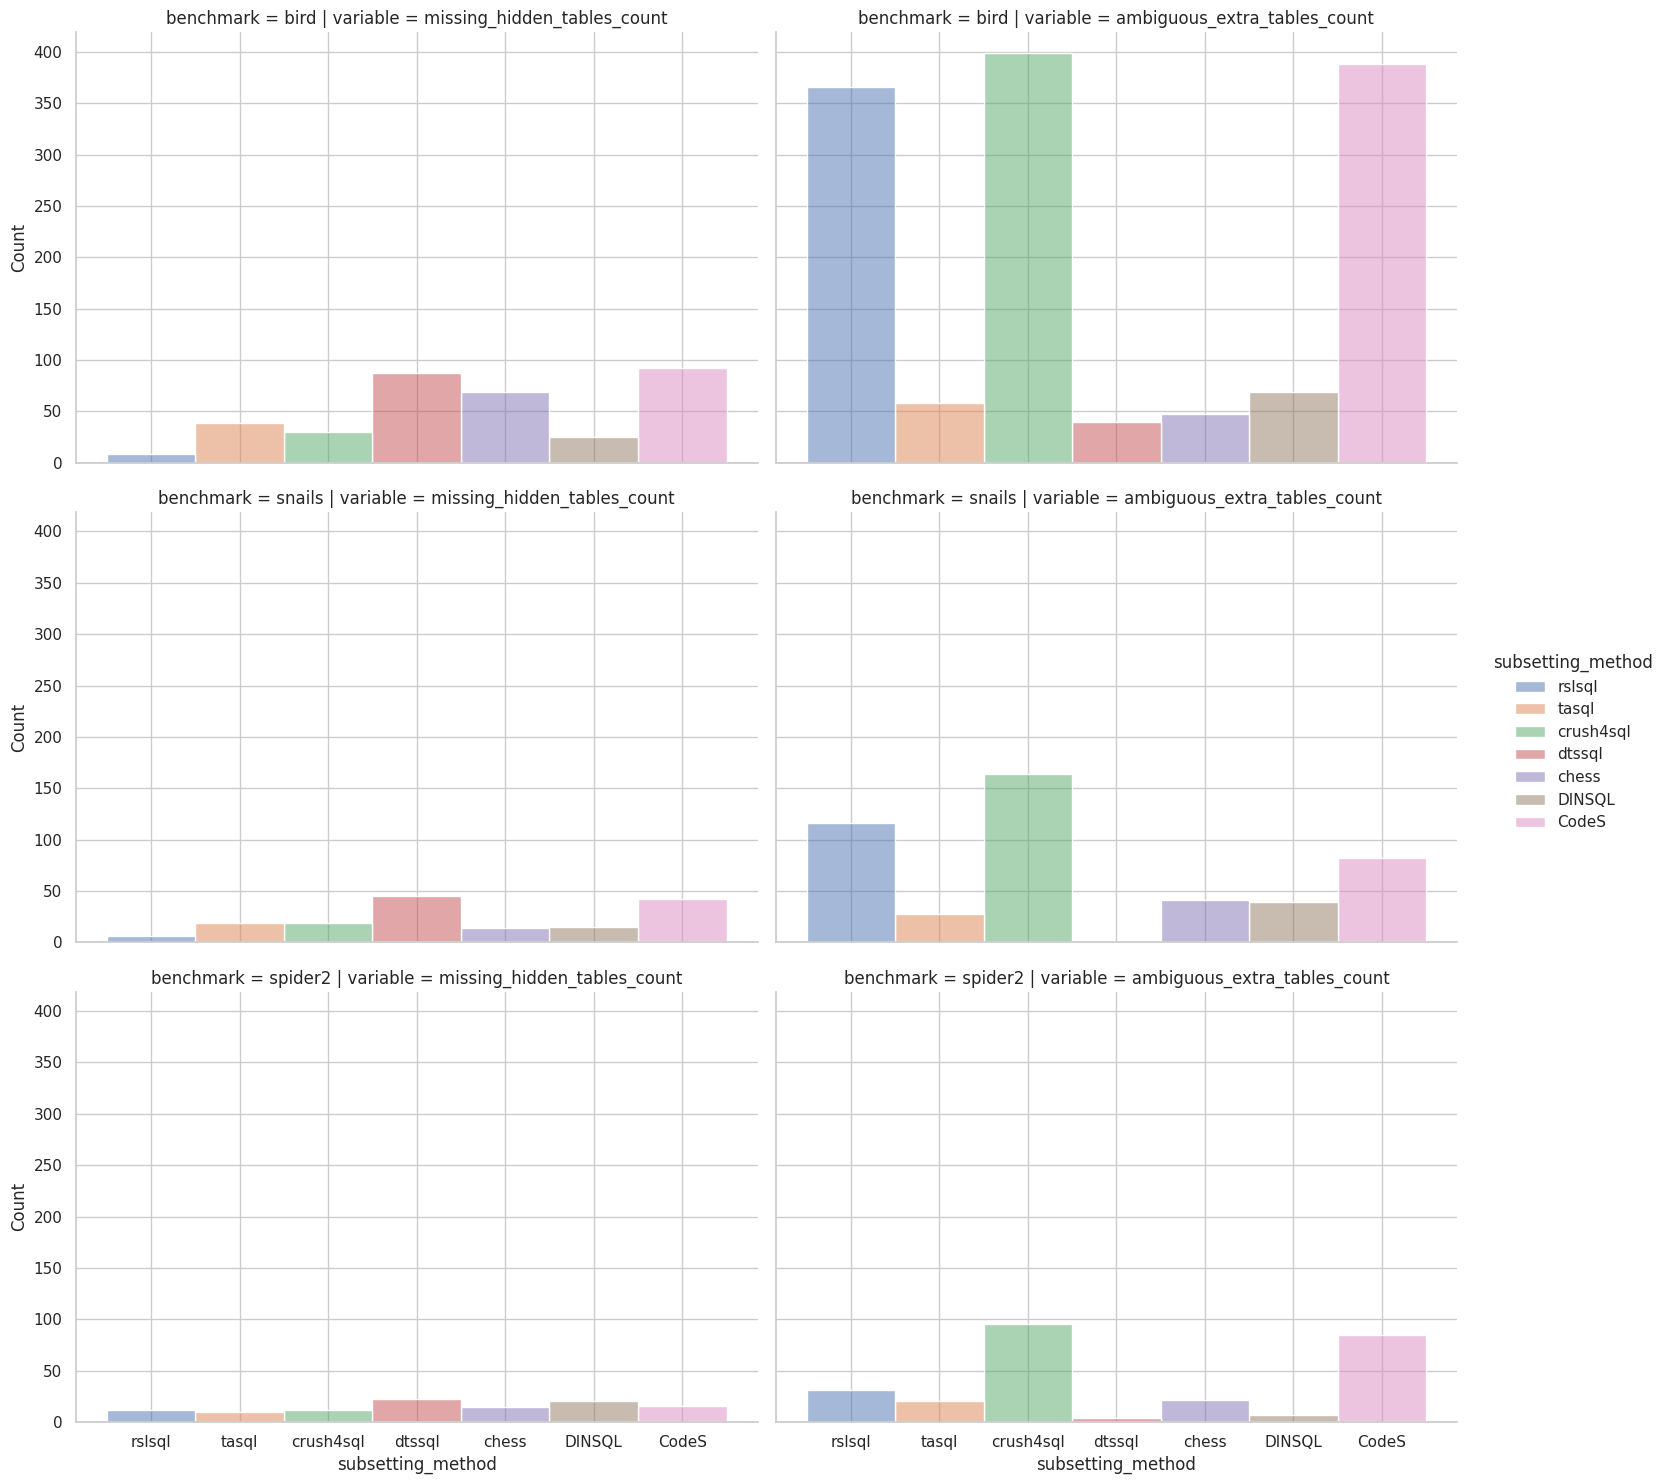

In [51]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=["missing_hidden_tables_count", "ambiguous_extra_tables_count"]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="subsetting_method",
    col="variable",
    # col_wrap=2,
    hue="subsetting_method",
    row="benchmark",
    aspect=1.5
)

### Value reference problem columns and ambiguous extra column counts by subsetting method

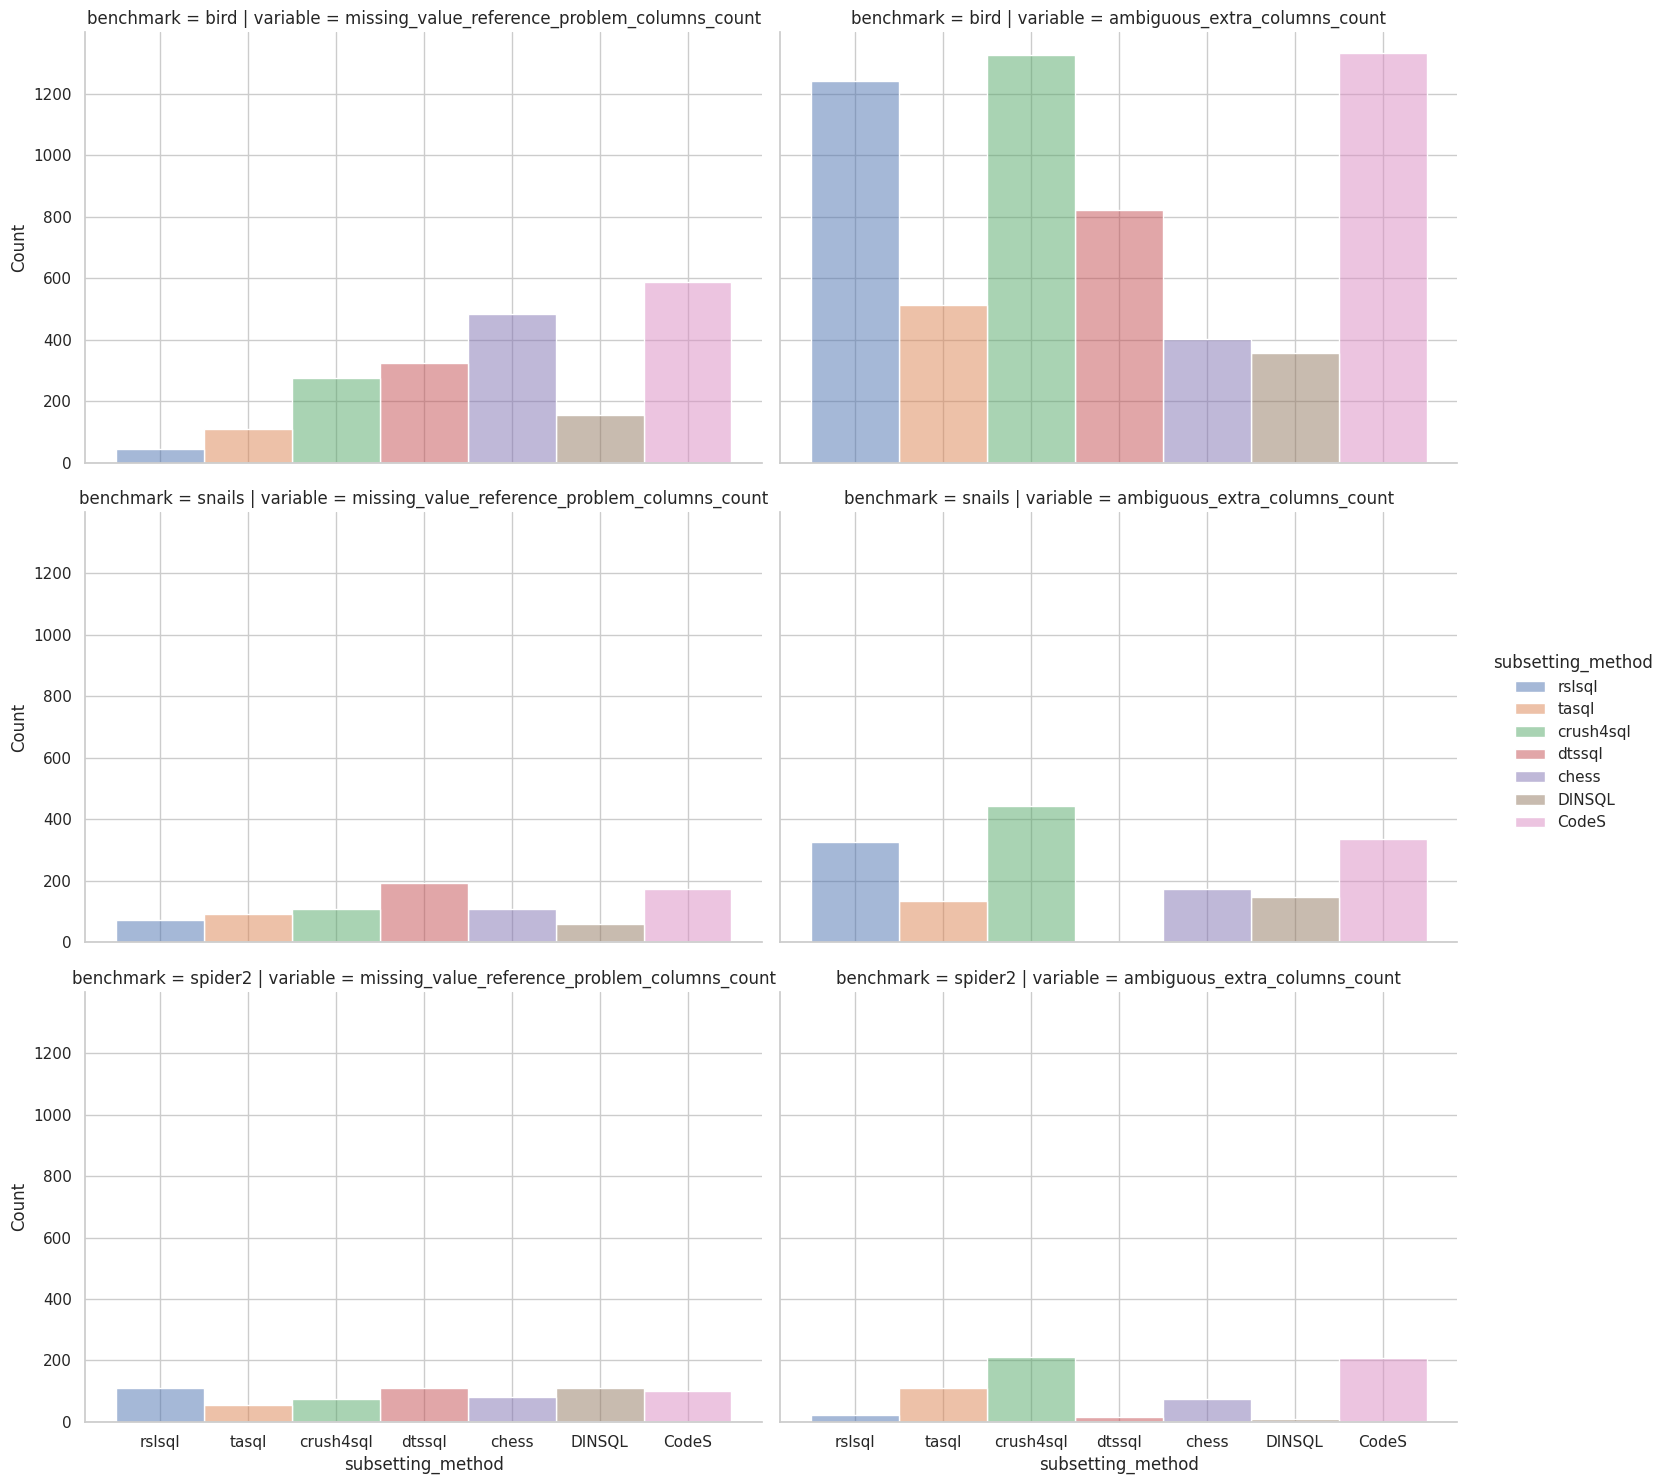

In [52]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=["missing_value_reference_problem_columns_count", "ambiguous_extra_columns_count"]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="subsetting_method",
    col="variable",
    # col_wrap=2,
    hue="subsetting_method",
    row="benchmark",
    aspect=1.5
)

### Diagnosis categories for each subsetting method

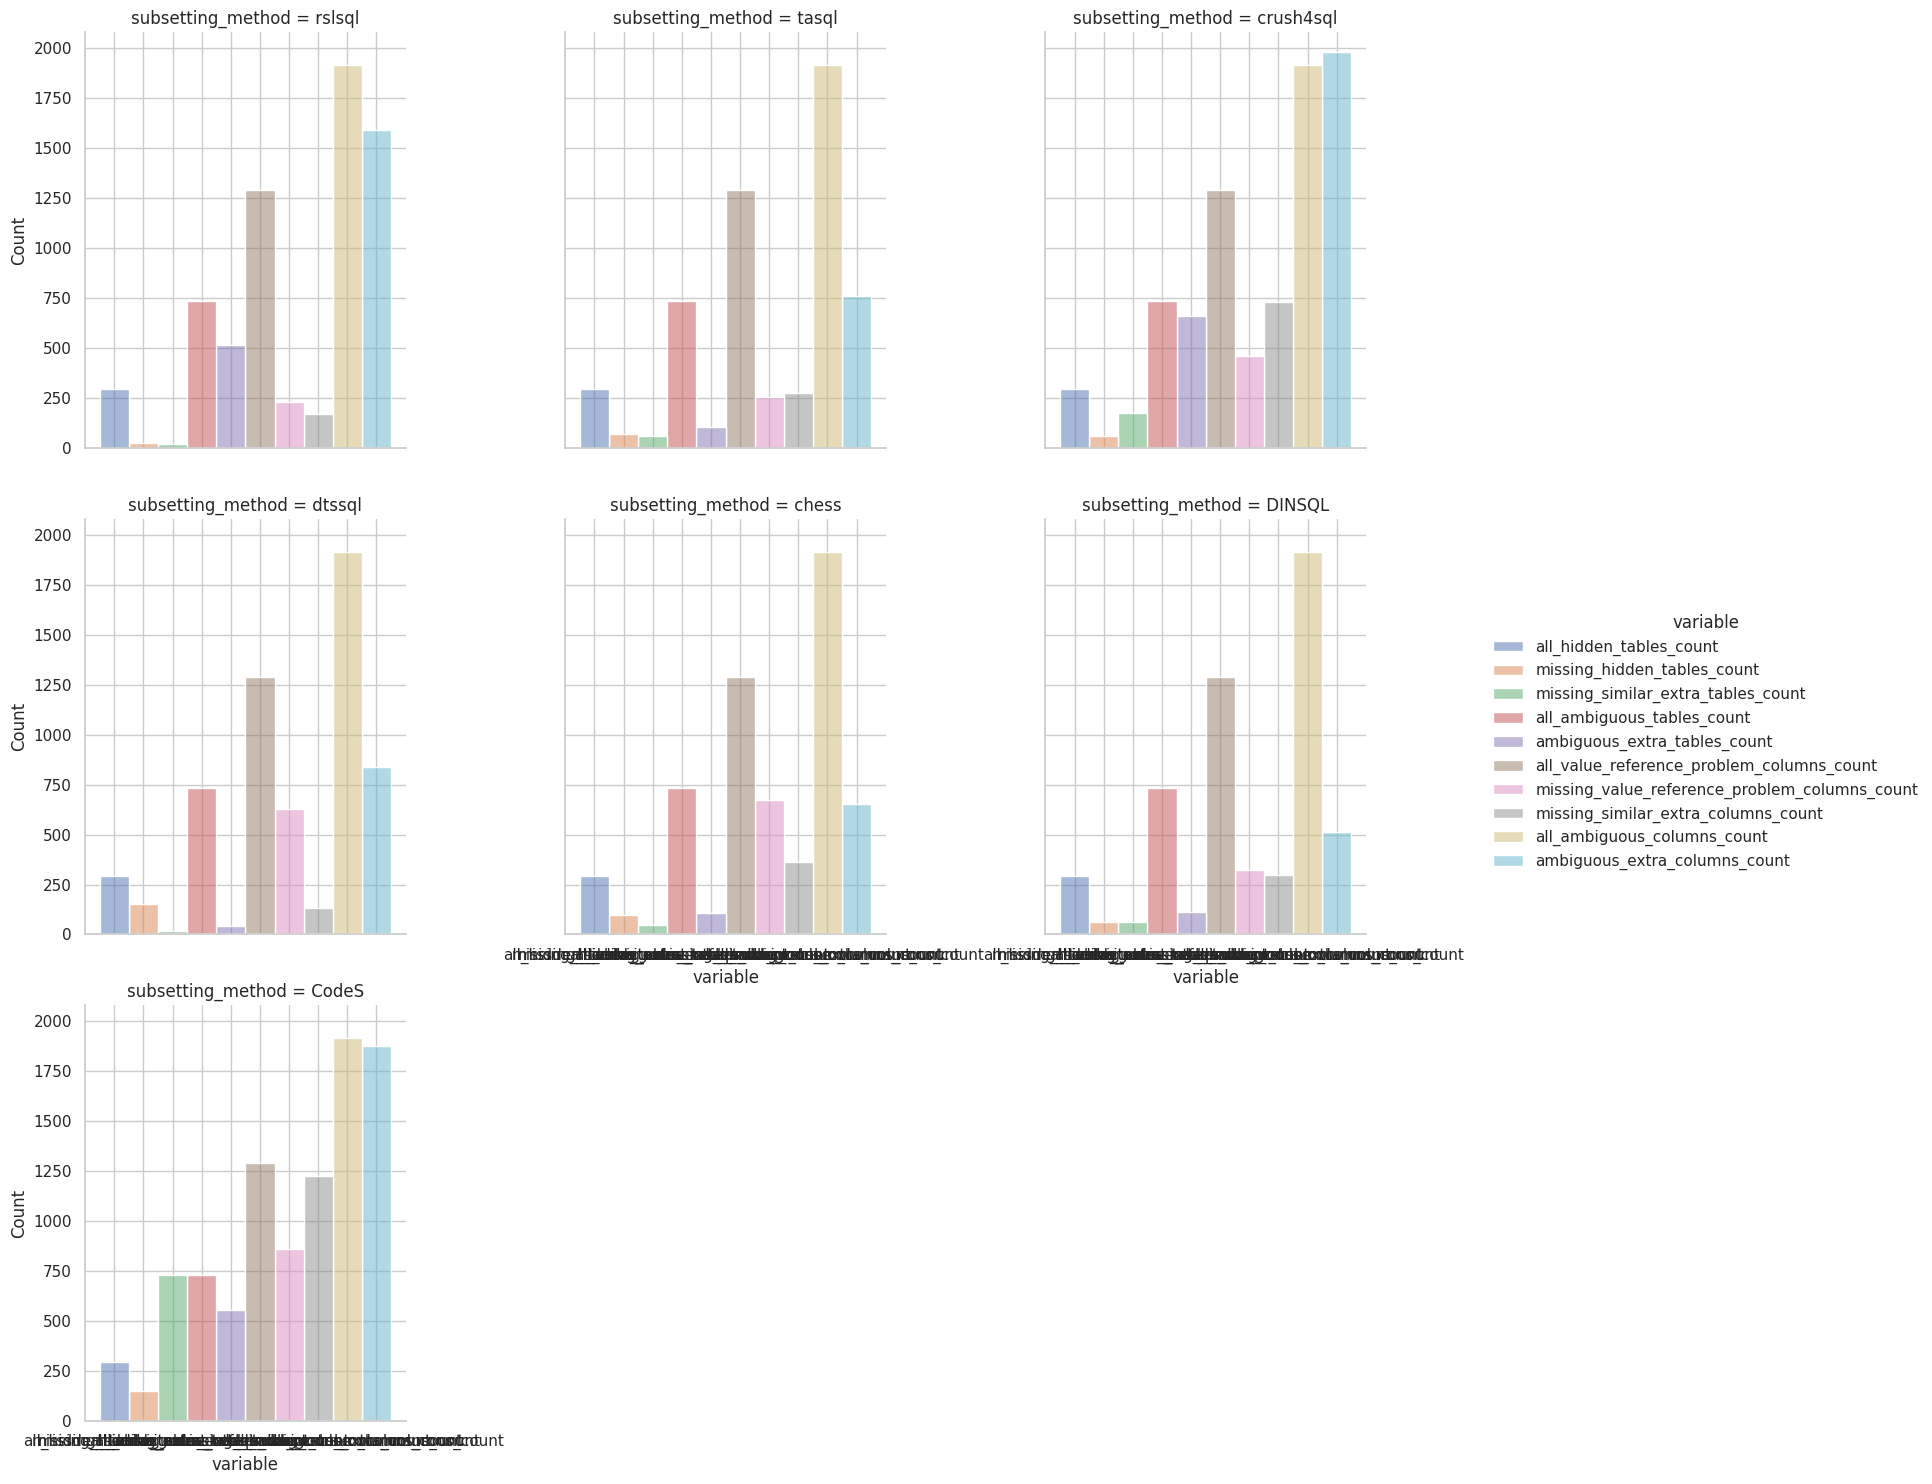

In [53]:
temp_data_df = diagnosis_df.query("eval_model").melt(
    id_vars=["benchmark", "database", "question_number", "comments", "subsetting_method"],
    value_vars=[c_name for c_name in diagnosis_df.columns if "_count" in c_name and "missing_tables" not in c_name and "missing_columns" not in c_name]
).query("value>0")
g = sns.displot(
    data=temp_data_df,
    x="variable",
    col="subsetting_method",
    col_wrap=3,
    hue="variable",
    aspect=1
)


### Hidden Tables problem proportion for each subsetting method and database size
Evaluating only inferences where the subsetting method did not fail, and where the possibility of a hidden table exists (evaluated using hidden_table_missing_proportion>=0 because negative values indicate that there are no hidden tables in the query).

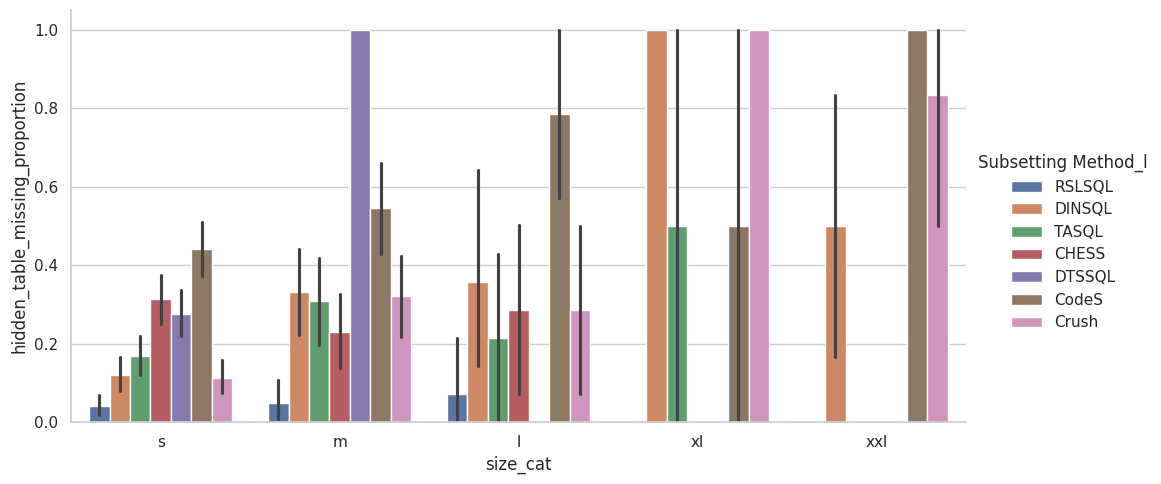

In [54]:
temp_data_df = diagnosis_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index().query("hidden_table_missing_proportion>=0").set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
]).join(
    performance_df.set_index(["benchmark", "database", "question_number", "subsetting_method", "comments"]),
    lsuffix="_l", rsuffix="_r"
).query("eval_model_r==True and prompt_tokens>=0 and inference_time>=0").sort_values(
    by="size_sort"
)
sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="hidden_table_missing_proportion",
    kind="bar",
    hue="Subsetting Method_l",
    aspect=2
)

### Value Reference problem proportion for each subsetting method and database size

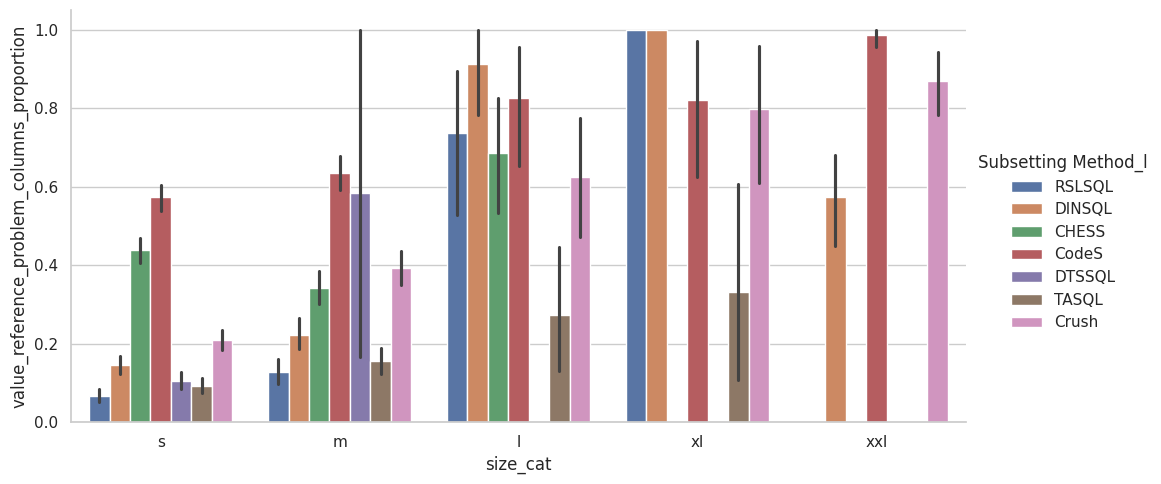

In [55]:
temp_data_df = diagnosis_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index().query("value_reference_problem_columns_proportion>=0").set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
]).join(
    performance_df.set_index(["benchmark", "database", "question_number", "subsetting_method", "comments"]),
    lsuffix="_l", rsuffix="_r"
).query("eval_model_r==True and prompt_tokens>=0 and inference_time>=0").sort_values(
    by="size_sort"
)
sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="value_reference_problem_columns_proportion",
    kind="bar",
    hue="Subsetting Method_l",
    aspect=2
)

### Ambiguous Extra tables proportion for each subsetting method and database size

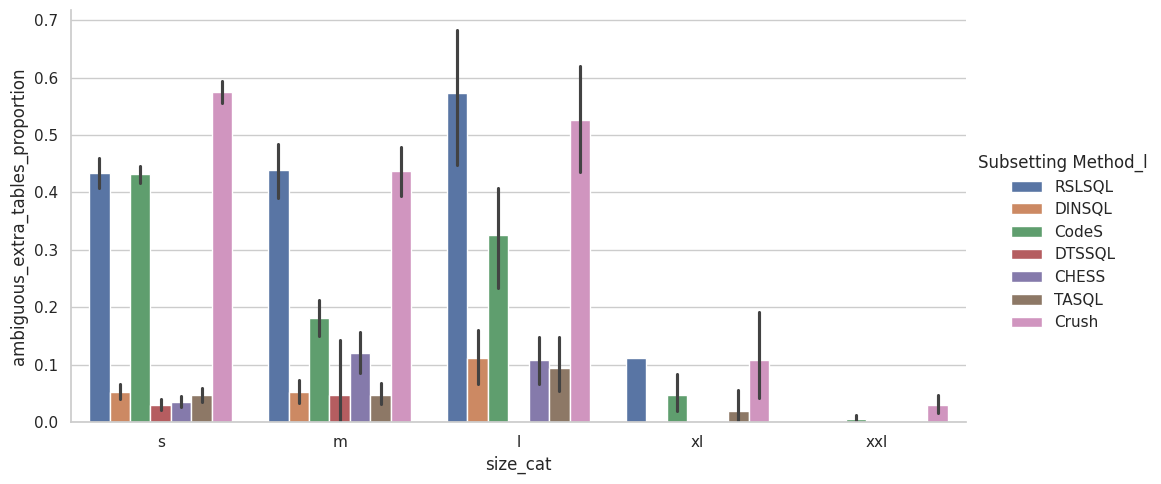

In [56]:
temp_data_df = diagnosis_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index().query("ambiguous_extra_tables_proportion>=0").set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
]).join(
    performance_df.set_index(["benchmark", "database", "question_number", "subsetting_method", "comments"]),
    lsuffix="_l", rsuffix="_r"
).query("eval_model_r==True and prompt_tokens>=0 and inference_time>=0").sort_values(
    by="size_sort"
)
sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="ambiguous_extra_tables_proportion",
    kind="bar",
    hue="Subsetting Method_l",
    aspect=2
)

### Ambiguous Extra columns proportion for each subsetting method and database size

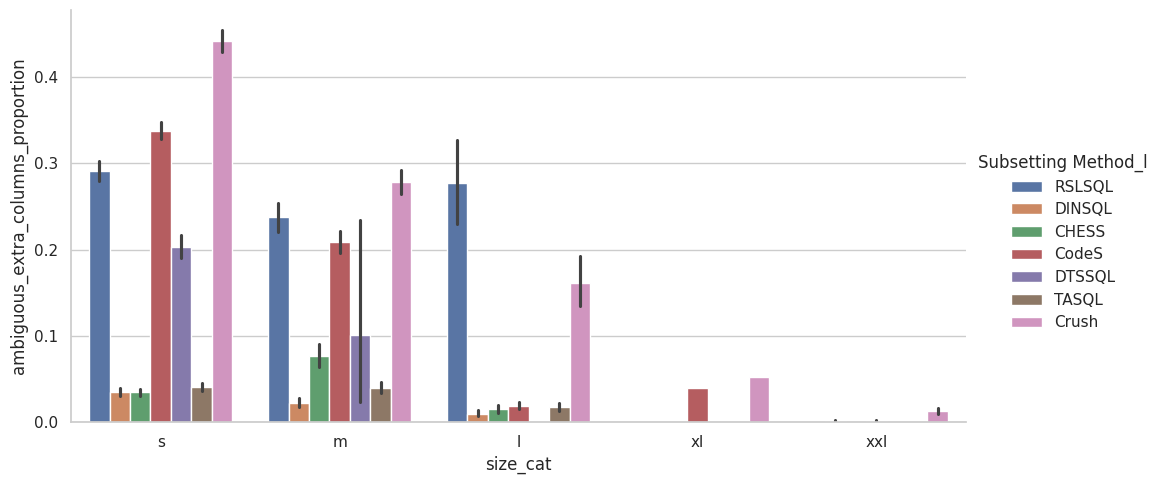

In [57]:
temp_data_df = diagnosis_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index().query("ambiguous_extra_columns_proportion>=0").set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
]).join(
    performance_df.set_index(["benchmark", "database", "question_number", "subsetting_method", "comments"]),
    lsuffix="_l", rsuffix="_r"
).query("eval_model_r==True and prompt_tokens>=0 and inference_time>=0").sort_values(
    by="size_sort"
)
sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="ambiguous_extra_columns_proportion",
    kind="bar",
    hue="Subsetting Method_l",
    aspect=2
)

### Missing columns reasons for each method

In [58]:
temp_data_df = diagnosis_df.set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
    ]).query("eval_model").join(
        performance_df.set_index(
            ["benchmark", "database", "question_number", "subsetting_method", "comments"]
            ),
        rsuffix="_r",
        lsuffix="_l"
    ).reset_index().query("prompt_tokens>=0 and inference_time>0 and not empty_guess")[[
    "subsetting_method", "comments", 
    "missing_columns_count", "unexplained_missing_columns_count", 
    "missing_value_reference_problem_columns_count", "missing_similar_extra_columns_count",
    "missing_columns_in_missing_tables_count"
    ]].groupby(
    by=["subsetting_method", "comments"]
).sum()
temp_data_df

missing_columns_count  \
subsetting_method comments                                    
CodeS             lambda1_sic_merged                   7160   
DINSQL            gpt41                                4144   
chess             gpt4o                                3626   
crush4sql         lambda1                              3677   
dtssql            lambda1                               934   
rslsql            gpt4o                                1637   
tasql             gpt41                                2158   

                                      unexplained_missing_columns_count  \
subsetting_method comments                                                
CodeS             lambda1_sic_merged                               3830   
DINSQL            gpt41                                            3016   
chess             gpt4o                                            2379   
crush4sql         lambda1                                          1714   
dtssql            lambda1                                           619   
rslsql            gpt4o                                            1149   
tasql             gpt41                                            1478   

                                      missing_value_reference_problem_columns_count  \
subsetting_method comments                                                            
CodeS             lambda1_sic_merged                                           1186   
DINSQL            gpt41                                                         496   
chess             gpt4o                                                         736   
crush4sql         lambda1                                                       661   
dtssql            lambda1                                                       120   
rslsql            gpt4o                                                         249   
tasql             gpt41                                                         246   

                                      missing_similar_extra_columns_count  \
subsetting_method comments                                                  
CodeS             lambda1_sic_merged                                 2144   
DINSQL            gpt41                                               632   
chess             gpt4o                                               511   
crush4sql         lambda1                                            1302   
dtssql            lambda1                                             195   
rslsql            gpt4o                                               239   
tasql             gpt41                                               434   

                                      missing_columns_in_missing_tables_count  
subsetting_method comments                                                     
CodeS             lambda1_sic_merged                                     5313  
DINSQL            gpt41                                                  2906  
chess             gpt4o                                                  1260  
crush4sql         lambda1                                                1403  
dtssql            lambda1                                                 934  
rslsql            gpt4o                                                   194  
tasql             gpt41                                                  1098

### Missing tables reasons for each method
Excludes inference failures and empty guesses

In [59]:
temp_data_df = diagnosis_df.set_index([
    "benchmark", "database", "question_number", "subsetting_method", "comments"
    ]).query("eval_model").join(
        performance_df.set_index(
            ["benchmark", "database", "question_number", "subsetting_method", "comments"]
            ),
        rsuffix="_r",
        lsuffix="_l"
    ).reset_index().query("prompt_tokens>=0 and inference_time>0 and not empty_guess")[[
    "subsetting_method", "comments", 
    "missing_tables_count", "unexplained_missing_tables_count", "missing_similar_extra_tables_count", "missing_hidden_tables_count"
    ]].groupby(
    by=["subsetting_method", "comments"]
).sum()
temp_data_df

missing_tables_count  \
subsetting_method comments                                   
CodeS             lambda1_sic_merged                  1965   
DINSQL            gpt41                                893   
chess             gpt4o                                530   
crush4sql         lambda1                              495   
dtssql            lambda1                              394   
rslsql            gpt4o                                 74   
tasql             gpt41                                447   

                                      unexplained_missing_tables_count  \
subsetting_method comments                                               
CodeS             lambda1_sic_merged                               768   
DINSQL            gpt41                                            738   
chess             gpt4o                                            378   
crush4sql         lambda1                                          145   
dtssql            lambda1                                          304   
rslsql            gpt4o                                             27   
tasql             gpt41                                            293   

                                      missing_similar_extra_tables_count  \
subsetting_method comments                                                 
CodeS             lambda1_sic_merged                                1020   
DINSQL            gpt41                                               71   
chess             gpt4o                                               50   
crush4sql         lambda1                                            282   
dtssql            lambda1                                             23   
rslsql            gpt4o                                               23   
tasql             gpt41                                               72   

                                      missing_hidden_tables_count  
subsetting_method comments                                         
CodeS             lambda1_sic_merged                          177  
DINSQL            gpt41                                        84  
chess             gpt4o                                       102  
crush4sql         lambda1                                      68  
dtssql            lambda1                                      67  
rslsql            gpt4o                                        24  
tasql             gpt41                                        82

## Row-level identifier data exploration

### Value Reference Problem proportions by naturalness level

In [60]:
temp_data_df = column_analysis_df.query("eval_model and status=='missing' and not empty_guess").pivot_table(
    columns=["value_reference_problem"],
    values=["column"],
    index=["subsetting_method", "comments", "column_naturalness"],
    aggfunc="count"
).reset_index()
temp_data_df["VRP_Proportion"] = (temp_data_df["column", True] / (temp_data_df["column", True] + temp_data_df["column", False]))
temp_data_df

subsetting_method            comments  \
value_reference_problem                                         
0                                   CodeS  lambda1_sic_merged   
1                                   CodeS  lambda1_sic_merged   
2                                   CodeS  lambda1_sic_merged   
3                                  DINSQL               gpt41   
4                                  DINSQL               gpt41   
5                                  DINSQL               gpt41   
6                                   chess               gpt4o   
7                                   chess               gpt4o   
8                                   chess               gpt4o   
9                               crush4sql             lambda1   
10                              crush4sql             lambda1   
11                              crush4sql             lambda1   
12                                 dtssql             lambda1   
13                                 dtssql             lambda1   
14                                 dtssql             lambda1   
15                                 rslsql               gpt4o   
16                                 rslsql               gpt4o   
17                                 rslsql               gpt4o   
18                                  tasql               gpt41   
19                                  tasql               gpt41   
20                                  tasql               gpt41   

                        column_naturalness column       VRP_Proportion  
value_reference_problem                     False  True                 
0                                    Least    884    51       0.054545  
1                                      Low    976    93       0.086997  
2                                  Regular   4114  1042       0.202095  
3                                    Least    757    29       0.036896  
4                                      Low    397    45       0.101810  
5                                  Regular   2494   422       0.144719  
6                                    Least    705    37       0.049865  
7                                      Low    356    40       0.101010  
8                                  Regular   1829   659       0.264871  
9                                    Least    534    36       0.063158  
10                                     Low    422    44       0.094421  
11                                 Regular   2060   581       0.219992  
12                                   Least    159    10       0.059172  
13                                     Low     50     2       0.038462  
14                                 Regular    605   108       0.151473  
15                                   Least    149    13       0.080247  
16                                     Low    185    27       0.127358  
17                                 Regular   1054   209       0.165479  
18                                   Least    368     8       0.021277  
19                                     Low    328    20       0.057471  
20                                 Regular   1216   218       0.152022

### Bar chart of percent of missing tables (recall) by method and size

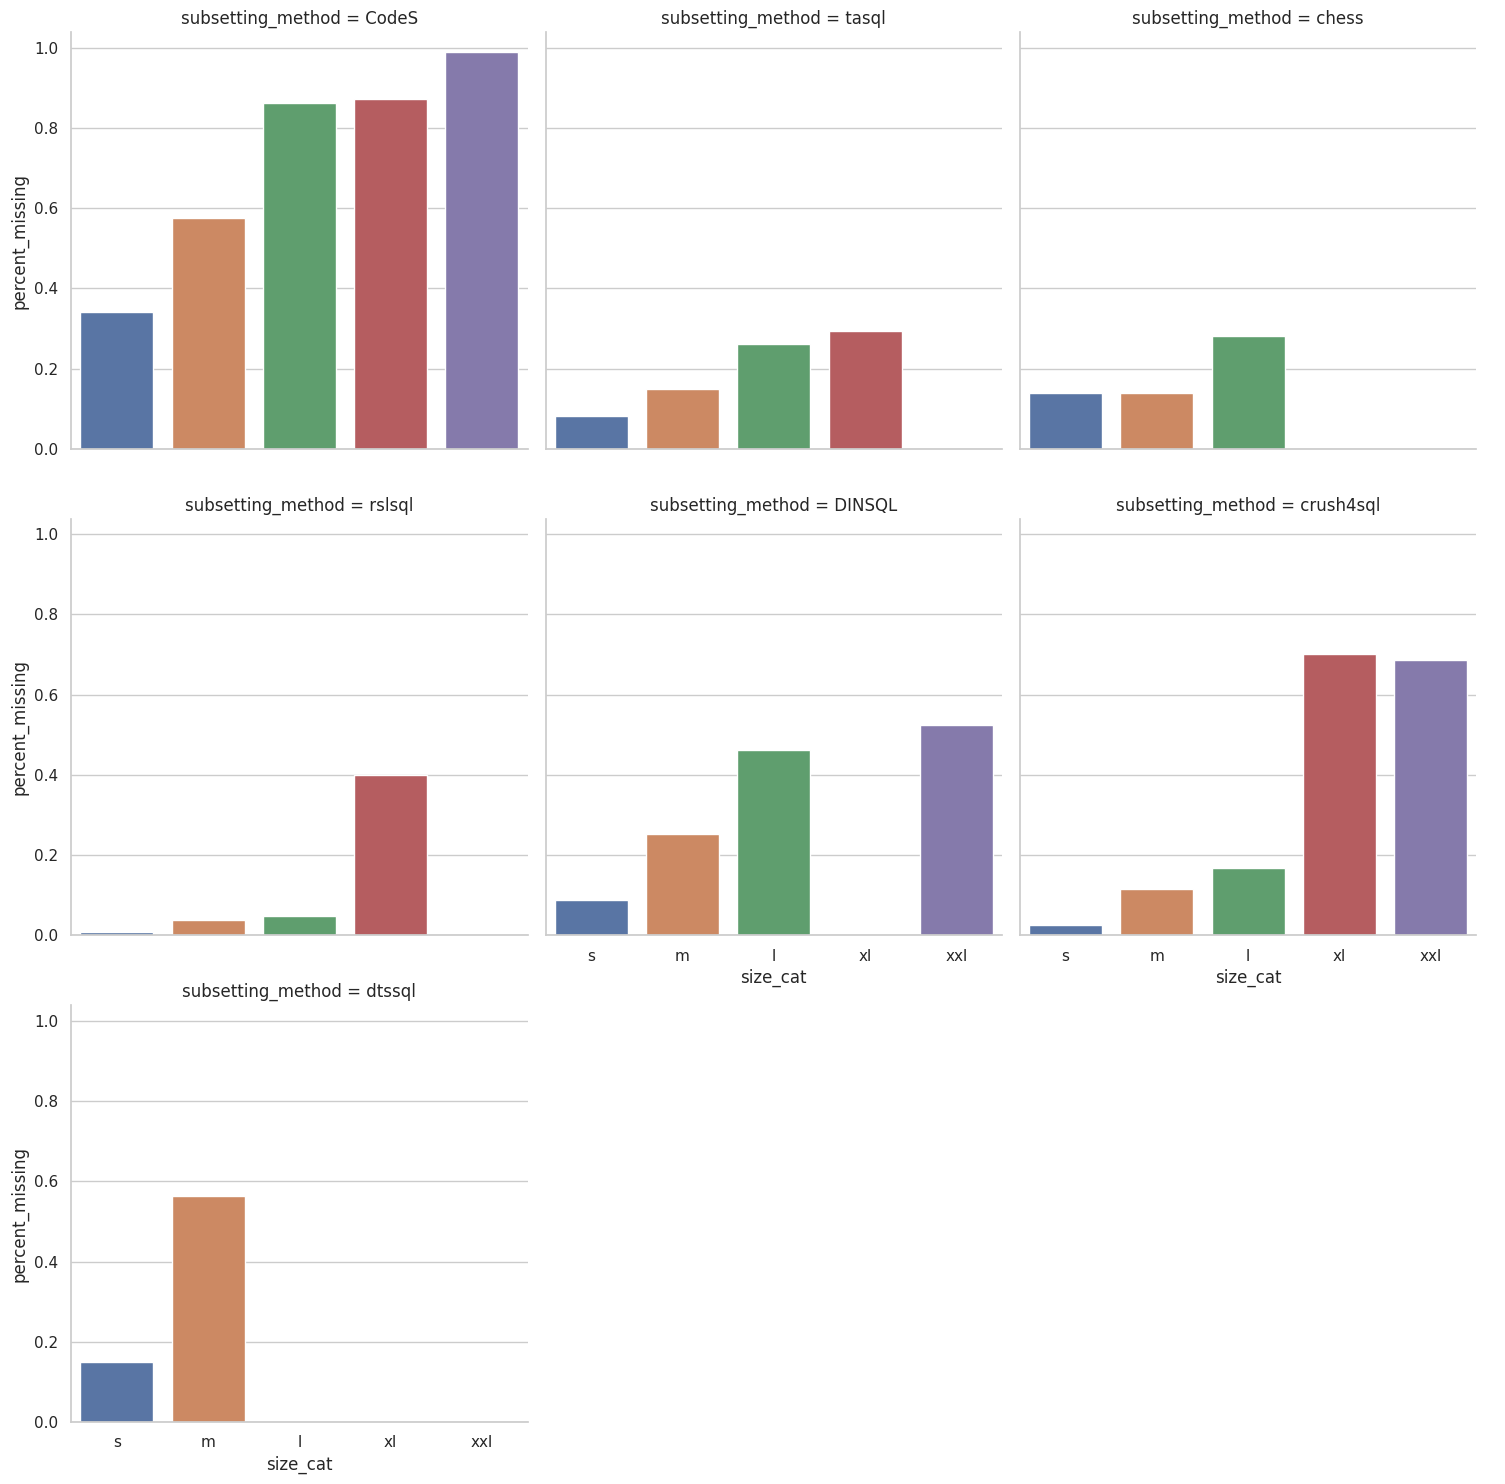

In [61]:
temp_data_df = table_analysis_df.query("(status=='missing' or status=='correct') and eval_model").set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])[["size_cat", "size_sort"]]
).reset_index().replace({True: 1, False: 0})
temp_data_df = temp_data_df.pivot_table(
    index=["subsetting_method", "size_cat", "size_sort"],
    columns=["status"],
    values=["comments"],
    aggfunc="count"
).reset_index().sort_values(by=["size_sort"])
temp_data_df["percent_missing"] = temp_data_df["comments", "missing"] / (temp_data_df["comments", "correct"] + temp_data_df["comments", "missing"])
temp_data_df.columns = [
    (temp_data_df.columns.droplevel(1)[i] + temp_data_df.columns.droplevel(0)[i]).replace("comments", "")
    for i in range(0, len(temp_data_df.columns))
    ]
g = sns.catplot(
    data=temp_data_df,
    col="subsetting_method",
    x="size_cat",
    y="percent_missing",
    kind="bar",
    hue="size_cat",
    col_wrap=3
)
g.add_legend()

### Method sensitivity to the hidden table problem

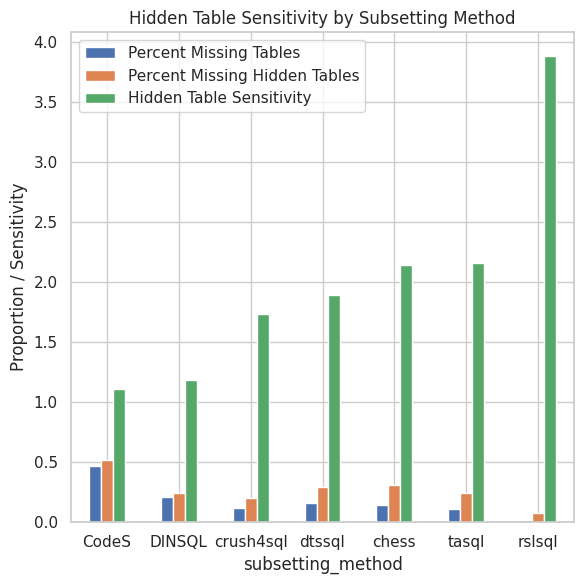

In [110]:
temp_data_df = table_analysis_df.query("is_hidden_table and eval_model and not empty_guess and status !='extra'")
temp_data_df = temp_data_df.pivot_table(
    index=["subsetting_method"],
    columns=["hidden_table_problem"],
    values=["is_hidden_table"],
    aggfunc="count"
).reset_index()
temp_data_df["Percent Missing Hidden Tables"] = temp_data_df["is_hidden_table", True] / (
    temp_data_df["is_hidden_table", False] + temp_data_df["is_hidden_table", True]
    )
temp_data_df.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in temp_data_df.columns
]
perc_missing_df = table_analysis_df.query("eval_model and (status=='missing' or status=='correct')").pivot_table(
    index=["subsetting_method"],
    columns=["status"],
    values=["is_hidden_table"],
    aggfunc="count"
).reset_index()
perc_missing_df["Percent Missing Tables"] = perc_missing_df["is_hidden_table", "missing"] / (
    perc_missing_df["is_hidden_table", "missing"] + perc_missing_df["is_hidden_table", "correct"]
)
perc_missing_df.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in perc_missing_df.columns
]
temp_data_df = temp_data_df.set_index("subsetting_method").join(
    perc_missing_df[["subsetting_method", "Percent Missing Tables"]].set_index("subsetting_method")
)
temp_data_df["Hidden Table Sensitivity"] = temp_data_df["Percent Missing Hidden Tables"] / temp_data_df["Percent Missing Tables"]
temp_data_df = temp_data_df[[
    "Percent Missing Tables", "Percent Missing Hidden Tables", "Hidden Table Sensitivity"
    ]].sort_values(by="Hidden Table Sensitivity")
temp_data_df

temp_data_df.plot(
    kind="bar",
    y=["Percent Missing Tables", "Percent Missing Hidden Tables", "Hidden Table Sensitivity"],
    figsize=(6, 6)
)
plt.ylabel("Proportion / Sensitivity")
plt.title("Hidden Table Sensitivity by Subsetting Method")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

htp_sensitivity_df = temp_data_df.copy().reset_index()
htp_sensitivity_df["Percent Missing Tables"] = htp_sensitivity_df["Percent Missing Tables"].apply(
    lambda x: dec_to_percent(x)
    )
htp_sensitivity_df["Percent Missing Hidden Tables"] = htp_sensitivity_df["Percent Missing Hidden Tables"].apply(
    lambda x: dec_to_percent(x)
    )

### Method sensitivity to the value reference problem

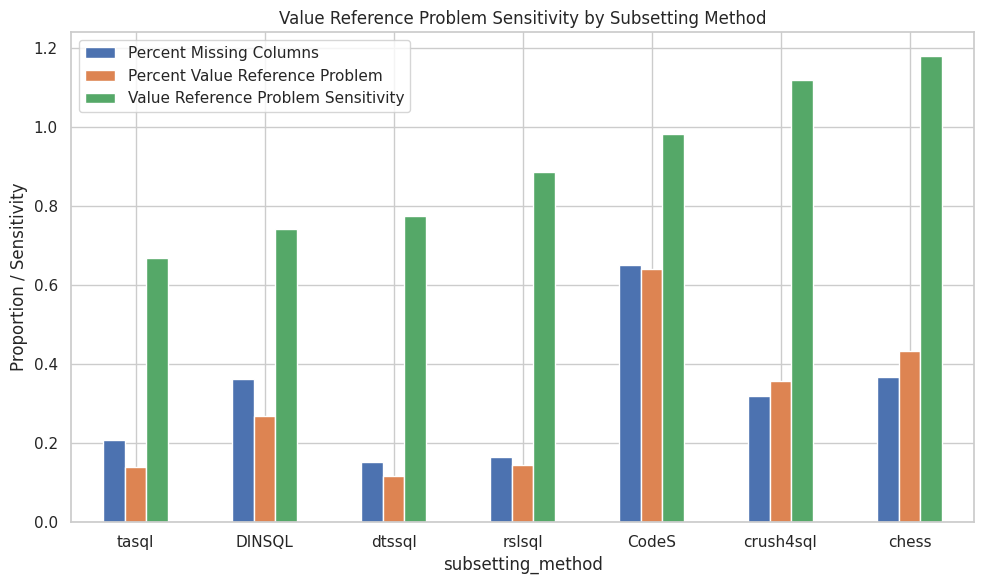

In [109]:
temp_data_df = column_analysis_df.query(
    "is_value_reference and eval_model and not empty_guess and status != 'extra'"
    )
temp_data_df = temp_data_df.pivot_table(
    index=["subsetting_method"],
    columns=["value_reference_problem"],
    values=["is_value_reference"],
    aggfunc="count"
).reset_index()
temp_data_df["Percent Value Reference Problem"] = temp_data_df["is_value_reference", True] / (
    temp_data_df["is_value_reference", False] + temp_data_df["is_value_reference", True]
)
temp_data_df.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in temp_data_df.columns
]

perc_missing_df = column_analysis_df.query("eval_model and (status=='missing' or status=='correct')").pivot_table(
    index=["subsetting_method"],
    columns=["status"],
    values=["column"],
    aggfunc="count"
).reset_index()
perc_missing_df["Percent Missing Columns"] = perc_missing_df["column", "missing"] / (
    perc_missing_df["column", "missing"] + perc_missing_df["column", "correct"]
)
perc_missing_df.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in perc_missing_df.columns
]
temp_data_df = temp_data_df.set_index("subsetting_method").join(
    perc_missing_df[["subsetting_method", "Percent Missing Columns"]].set_index("subsetting_method")
)
temp_data_df["Value Reference Problem Sensitivity"] = temp_data_df["Percent Value Reference Problem"] / temp_data_df["Percent Missing Columns"]
temp_data_df = temp_data_df[[
    "Percent Missing Columns", "Percent Value Reference Problem", "Value Reference Problem Sensitivity"
    ]].sort_values(by="Value Reference Problem Sensitivity")

temp_data_df.plot(
    kind="bar",
    y=["Percent Missing Columns", "Percent Value Reference Problem", "Value Reference Problem Sensitivity"],
    figsize=(10, 6)
)
plt.ylabel("Proportion / Sensitivity")
plt.title("Value Reference Problem Sensitivity by Subsetting Method")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

vrp_sensitivity_df = temp_data_df.copy().reset_index()
vrp_sensitivity_df["Percent Missing Columns"] = vrp_sensitivity_df["Percent Missing Columns"].apply(
    lambda x: dec_to_percent(x)
    )
vrp_sensitivity_df["Percent Value Reference Problem"] = vrp_sensitivity_df["Percent Value Reference Problem"].apply(
    lambda x: dec_to_percent(x)
    )

### Hidden identifier table

In [116]:
if "vrp_sensitivity_df" in locals() and "htp_sensitivity_df" in locals():
    table_df = vrp_sensitivity_df.set_index(["subsetting_method"]).join(
        htp_sensitivity_df.set_index(["subsetting_method"])
    ).reset_index()
    table_df.to_latex(
        buf=f"{os.getcwd()}/tables/hidden_object_sensitivity.tex",
        float_format="%.2f",
        index=False,
        header=[
            "$\Psi$", "\% MA", "\% VRP", "V-Sens.",
            "\% MR", "\% HRP", "H-Sens."
            ],
        label=f"tab:vrp_hrp_sensitivity",
        caption="This table shows the Value Reference Problem (VRP) and Hidden Relation Problem (HRP) occurence percentages and sensitivities. Sensitivity (Sens.) is the proportion of a given problem occurence percentage (defined as realized problem over all instances where the problem might occur) to the percentage of all missing relations (\% MR) or attributes (\% MA) in the performance data. We can see that all subsetting methods are subject to HRP occurence at a higher rate, and only with 2 methods does the VRP manifest at a rate higher than general missing attribute occurence."
    )

### Column Ambiguity table

In [133]:
temp_data_df = column_analysis_df.query("not empty_guess and status =='extra' and eval_model")
all_extra_counts = temp_data_df[["subsetting_method", "comments"]].groupby(by=["subsetting_method"]).count().rename(columns={
    "comments": "AllExtra"
})
ambiguous_extra_counts = temp_data_df.query(
    "ambiguous_extra"
    )[["subsetting_method", "comments"]].groupby(by=["subsetting_method"]).count().rename(columns={
        "comments": "Ambiguous"
    })
hallucinated_extra_counts = temp_data_df.query(
    "hallucinated_extra"
)[["subsetting_method", "comments"]].groupby(by=["subsetting_method"]).count().rename(columns={
    "comments": "Hallucinated"
})
temp_data_df = all_extra_counts.join(
    ambiguous_extra_counts
).join(
    hallucinated_extra_counts
).fillna(0)
temp_data_df["Other"] = temp_data_df.apply(
    lambda row: row.AllExtra - (row.Ambiguous + row.Hallucinated),
    axis=1
    )

## Schema Processing 

### Seconds per Column by subsetting method Histogram

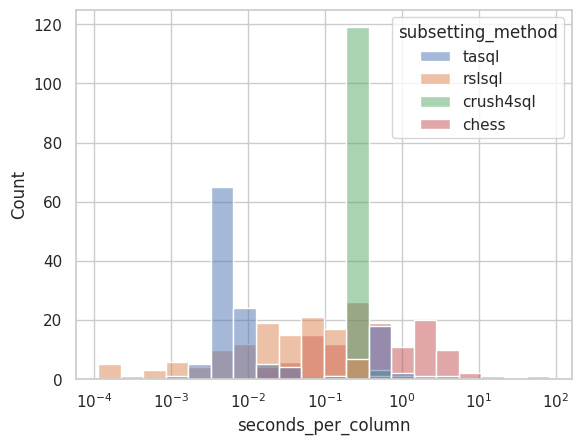

In [64]:
g = sns.histplot(
    data=processing_time_df,
    x="seconds_per_column",
    bins=20,
    log_scale=True,
    hue="subsetting_method"
)

### Processing Times by Method and Database Size

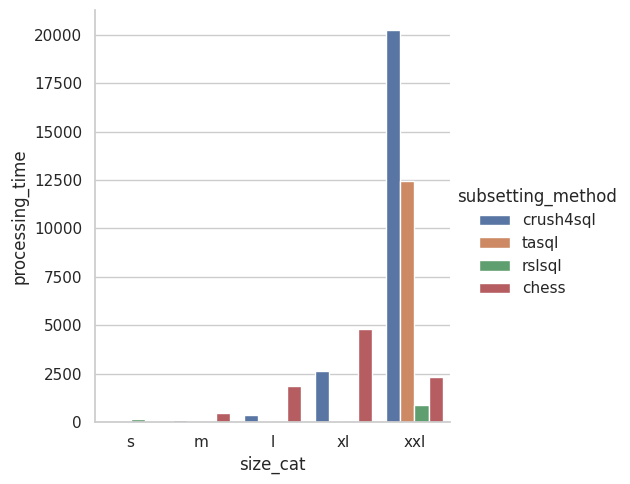

In [65]:
temp_data_df = processing_time_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()[["size_cat", "subsetting_method", "processing_time"]].groupby(
    ["size_cat", "subsetting_method"]
).mean().reset_index().sort_values(by="size_cat", key=lambda x:  x.map({"xs": 0, "s": 1, "m": 2, "l": 3, "xl": 4, "xxl": 5}))

g = sns.catplot(
    data=temp_data_df,
    x="size_cat",
    y="processing_time",
    hue="subsetting_method",
    kind="bar"
)

## Correlations

### Total Precision x Total Recall for each subsetting method

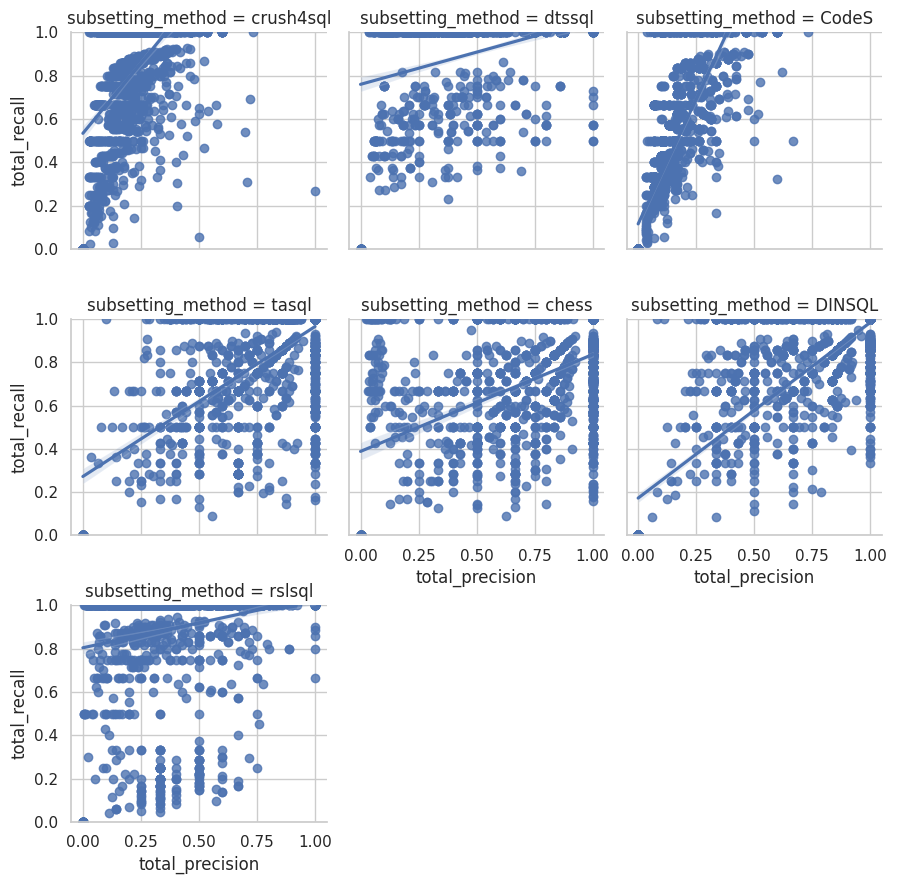

In [66]:
g = sns.FacetGrid(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    col="subsetting_method",
    col_wrap=3,
    # hue="benchmark"
)
# g.map(sns.scatterplot, "total_precision", "total_recall")
g.map(sns.regplot, "total_precision", "total_recall", scatter=True, truncate=True)
g.set(ylim=(0, 1))
g.add_legend()


### KDE of Precision x Recall for each subsetting method

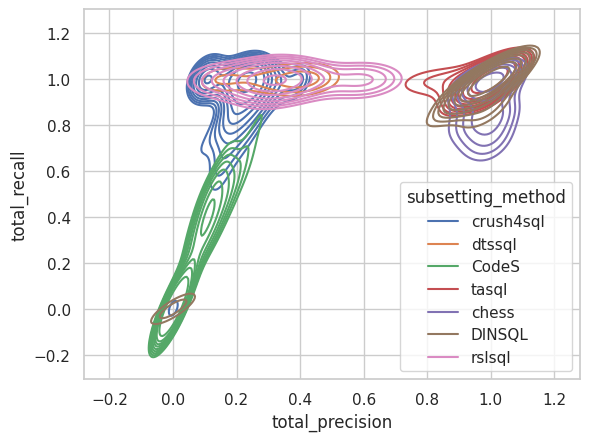

In [67]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and all_models_compatible and eval_model"),
    hue="subsetting_method",
    x="total_precision",
    y="total_recall",
    thresh=0.5,
    legend=True
)
sns.move_legend(g, loc="lower right")



### KDE of Precision x Recall for each subsetting method and benchmark

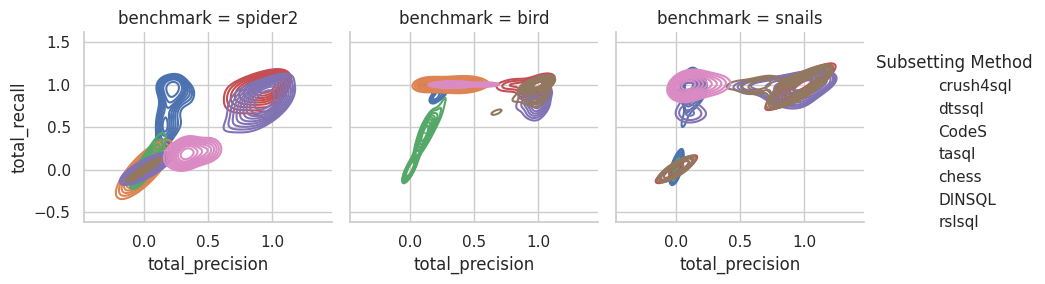

In [68]:
g = sns.FacetGrid(
    data=performance_df.query("prompt_tokens>=0 and all_models_compatible and eval_model"),
    hue="subsetting_method",
    col="benchmark"
)
g.map(sns.kdeplot, "total_precision", "total_recall", thresh=0.5, legend=True)
g.add_legend(title="Subsetting Method")


### KDE of Total Recall and Inference Time for each subsetting method

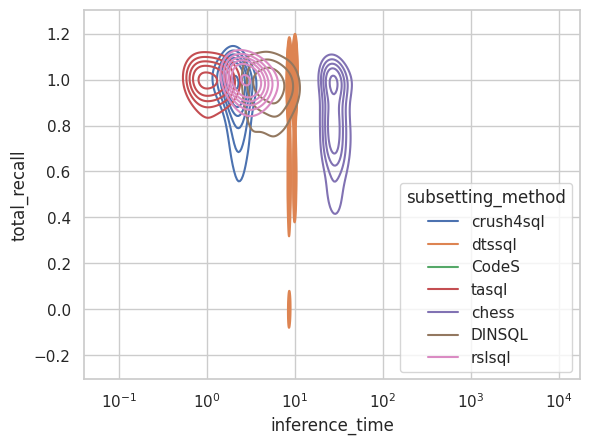

In [69]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_recall",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### KDE of Total Precision and Inference Time for each subsetting method

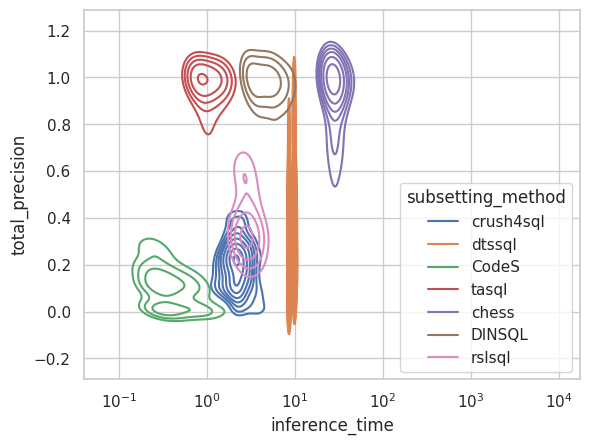

In [70]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_precision",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### KDE of Total f1 and Inference Time for each subsetting method

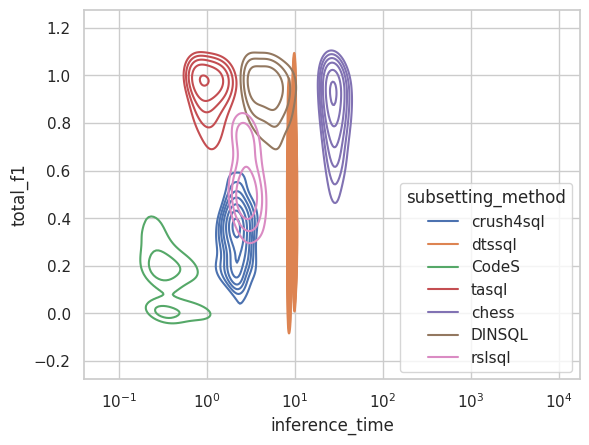

In [71]:
g = sns.kdeplot(
    data=performance_df.query("prompt_tokens>=0 and eval_model"),
    hue="subsetting_method",
    x="inference_time",
    y="total_f1",
    thresh=0.3,
    legend=True,
    log_scale=[10, False]
)
sns.move_legend(g, loc="lower right")


### Processing time (seconds per column) X Inference time (seconds per query)

<Figure size 640x480 with 0 Axes>

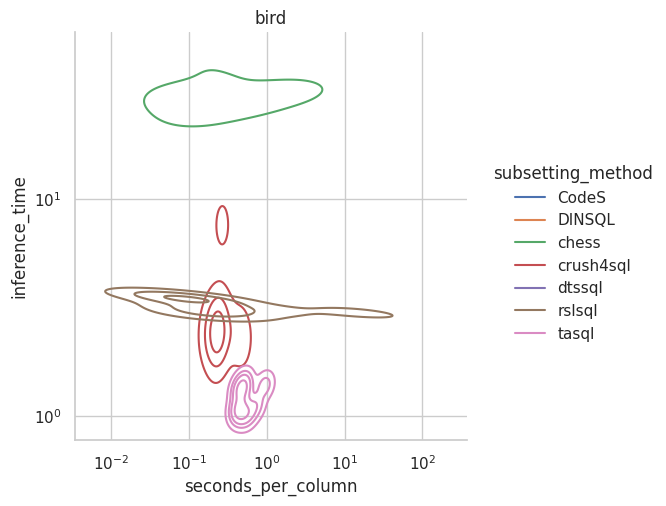

<Figure size 640x480 with 0 Axes>

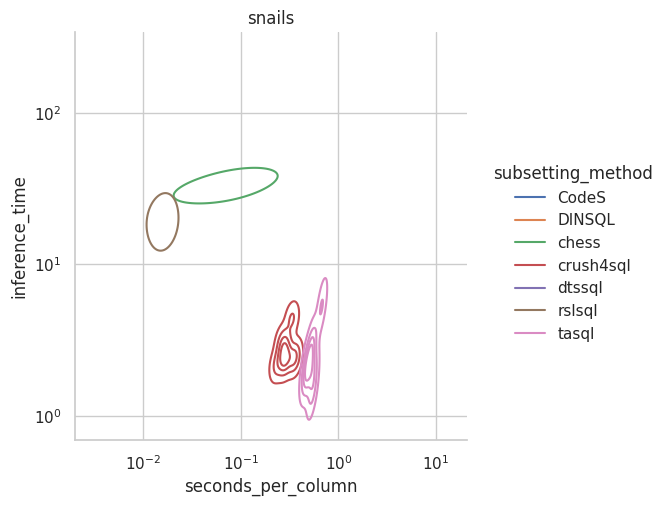

<Figure size 640x480 with 0 Axes>

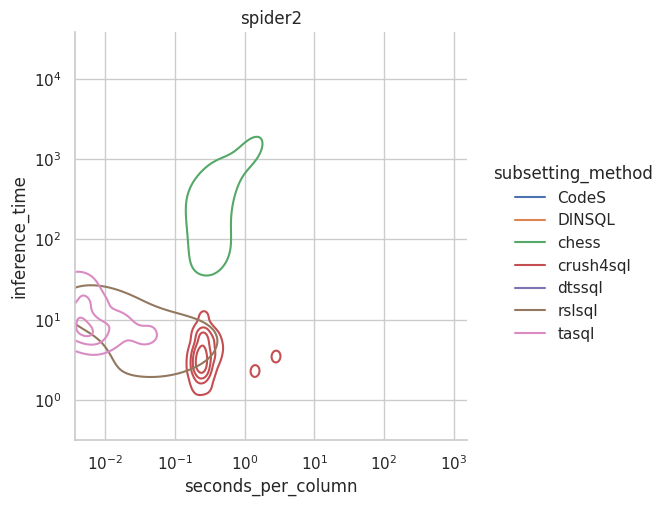

In [72]:
temp_data_df = performance_df.query("eval_model").set_index(["benchmark", "database", "subsetting_method"]).join(
    processing_time_df.set_index(["benchmark", "database", "subsetting_method"]), 
    lsuffix="perf_df_",
    rsuffix="proc_df"
).reset_index()[["benchmark", "database", "subsetting_method", "inference_time", "seconds_per_column"]].query(
    "inference_time>0"
)
temp_data_df = temp_data_df.groupby(by=["benchmark", "database", "subsetting_method"]).mean().reset_index()

for benchmark in temp_data_df.benchmark.unique():
    plt.figure()
    g = sns.displot(
        data=temp_data_df.query(f"benchmark=='{benchmark}'"),
        x="seconds_per_column",
        y="inference_time",
        hue="subsetting_method",
        kind="kde",
        log_scale=[True, True],
        thresh=0.1,
        levels=5
    )
    
    plt.title(benchmark)

# Performance Evaluation

## Schema Size Limitation Results

In [73]:
temp_data_df = performance_df.query("eval_model").set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"]).sort_values(by="size_sort", ascending=False)
).reset_index().drop_duplicates(subset=["subsetting_method", "benchmark", "database"])
size_counts = {
    "S": 44, "M": 51, "L": 11, "XL": 14, "XXL": 5
}
temp_data_df = temp_data_df.query("prompt_tokens>=0").pivot_table(
    values=["database"],
    columns=["size_cat"],
    index=["subsetting_method"],
    aggfunc="count",
    fill_value="-"
)
temp_data_df.columns = [col[1].upper() for col in temp_data_df.columns]
temp_data_df = temp_data_df[["S", "M", "L", "XL", "XXL"]].reset_index()

def dec_to_percent(x: float) -> str:
    return str(int(x * 100)) + "\%"

for s in size_counts.keys():
    temp_data_df[s] = temp_data_df[s].apply(lambda x: dec_to_percent(round(x / size_counts[s], 2)) if x != "-" else x)
temp_data_df.to_latex(
    buf=f"{os.getcwd()}/tables/subsetting_schema_size_limits.tex",
    float_format="%.2f",
    index=False,
    header=["$\Psi$", "S", "M", "L", "XL", "XXL"],
    label=f"tab:schema-size-limits",
    caption="Percent of each schema size category that each subsetting method is capable of processing. Only 3 of the 7 evaluated methods are capable of processing all schemas."
)

## Recall, Precision, and F1

### Recall, Precision, F1, and Schema Proportion Tables by Benchmark

In [74]:
for benchmark in performance_df.benchmark.unique():
    temp_data_df = performance_df.query(f"all_models_compatible==True and benchmark=='{benchmark}'").dropna(how="all")[[
        "Subsetting Method", "total_recall", "total_precision", "total_f1", 
        "table_recall", "table_precision", "table_f1",
        "column_recall", "column_precision", "column_f1",
        "subset_table_proportion", "subset_column_proportion"
        ]].groupby(["Subsetting Method"]).mean().reset_index()
    max_stats = {}
    for column in list(temp_data_df.columns):
        if column == "Subsetting Method":
            continue
        if "proportion" not in column:
            max_stats[column] = round(max(temp_data_df[column]), 2)
        else:
            max_stats[column] = round(min(temp_data_df.query(f"{column}>0")[column]), 2)
    for column in temp_data_df.columns:
        if column not in max_stats.keys():
            continue
        temp_data_df[column] = temp_data_df[column].apply(
            lambda x: str(round(x, 2)).replace(
                str(max_stats[column]), 
                ("\\textbf{" + str(max_stats[column]) + "}")
                )
        )
        temp_data_df[column] = temp_data_df[column].apply(lambda x: x + "0" if len(x) == 3 else x)
    latex_table = temp_data_df.to_latex(
        # buf=f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", 
        float_format="%.2f",
        index=False,
        header=["$\Psi$", "TotRec", "TotPre", "Totf1", "TabRec", "TabPre", "Tabf1", "ColRec", "ColPre", "Colf1", "TabPrp", "ColPrp"],
        label=f"tab:exp1-{benchmark}",
        caption=f"Experiment 1 Performance ({str.capitalize(benchmark)} Benchmark)"
        ).replace("{table}", "{table*}")
    with open(f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", "wt") as f:
        f.write(latex_table)

### Time, Recall, Precision, F1, and Schema Proportion Tables by Schema Size

In [75]:
for schema_size in schema_stat_df.size_cat.unique():
    temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
            schema_stat_df.set_index(["benchmark", "database"])
        ).query(
            f"size_cat=='{schema_size}' and inference_time>=0 and prompt_tokens>=0"
        ).dropna(how="all")[[
        "Subsetting Method", "inference_time", "prompt_tokens", "total_recall", "total_precision", "total_f1", 
        "table_recall", "table_precision", "table_f1",
        "column_recall", "column_precision", "column_f1",
        "subset_table_proportion", "subset_column_proportion"
        ]].groupby(["Subsetting Method"]).mean().reset_index()
    temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: int(x))
    # temp_data_df = temp_data_df.query("total_f1 > 0")
    max_stats = {}
    for column in list(temp_data_df.columns):
        if column == "Subsetting Method":
            continue
        if "proportion" not in column and "time" not in column and "tokens" not in column:
            max_stats[column] = round(max(temp_data_df[column]), 2)
        elif "tokens" in column:
            max_stats[column] = min(temp_data_df.query(f"{column}>0")[column])
        else:
            max_stats[column] = round(min(temp_data_df.query(f"{column}>0.0")[column]), 2)
    for column in temp_data_df.columns:
        if column not in max_stats.keys():
            continue
        temp_data_df[column] = temp_data_df[column].apply(
            lambda x: str(round(x, 2)).replace(
                f"{str(max_stats[column])}", 
                ("\\textbf{" + str(max_stats[column]) + "}")
            ) if len(str(max_stats[column])) > 3  or (type(max_stats[column]) == int)   
            else str(round(x, 2))
        )
        temp_data_df[column] = temp_data_df[column].apply(lambda x: x + "0" if len(x) == 3 else x)
    temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: "-" if x == "0" else x)
    latex_table = temp_data_df.to_latex(
        # buf=f"{os.getcwd()}/tables/{benchmark}_f1_rec_pre_prop_table.tex", 
        float_format="%.2f",
        index=False,
        header=["$\Psi$", "Time (s)", "Tokens", "TotRec", "TotPre", "Totf1", "TabRec", "TabPre", "Tabf1", "ColRec", "ColPre", "Colf1", "TabPrp", "ColPrp"],
        label=f"tab:exp1-{schema_size}-schema",
        caption=f"Experiment 1 Performance ({str.upper(schema_size)} Schema Size)"
        ).replace("{table}", "{table*}")
    with open(f"{os.getcwd()}/tables/{schema_size}-schema_f1_rec_pre_prop_table.tex", "wt") as f:
        f.write(latex_table)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (All Databases)

This a first look, and one that isn't very useful. On the surface, it suggests pretty big differences between various subsetting methods. However, what we're not seeing here are the methods that weren't capable of handling very large schemas. So it's possible that those methods are being unfairly rewarded (or punished) compared to those that were able to take on the largest schemas. We'll need to separate out the databases that all methods were capable of handling, and compare only those across methods.

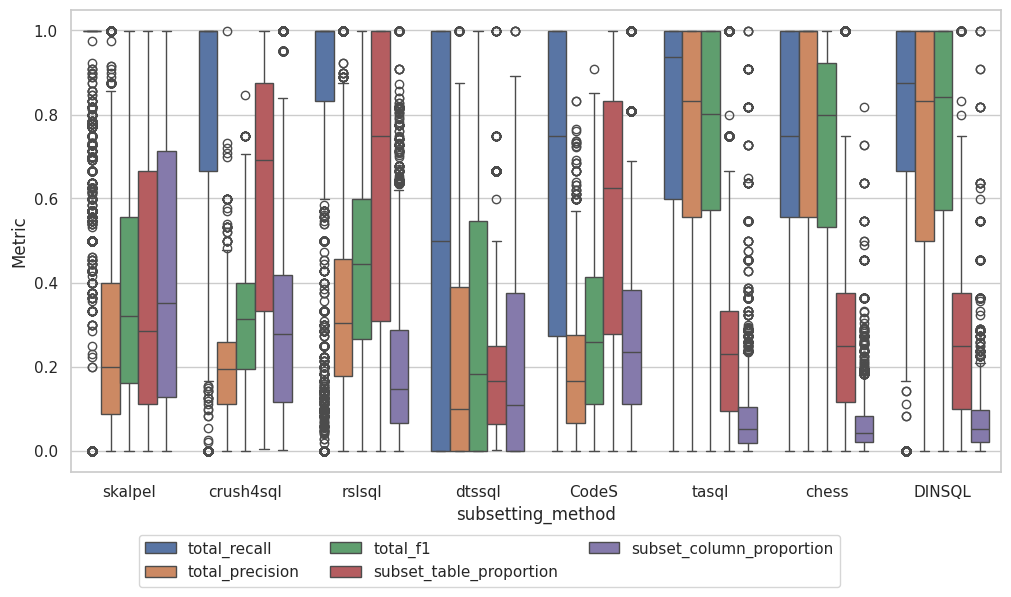

In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only All-Model-Compatible Databases)

This is the same chart as above, except now we filter out the databases where some subsetting methods were unable to handle them due to schema size 

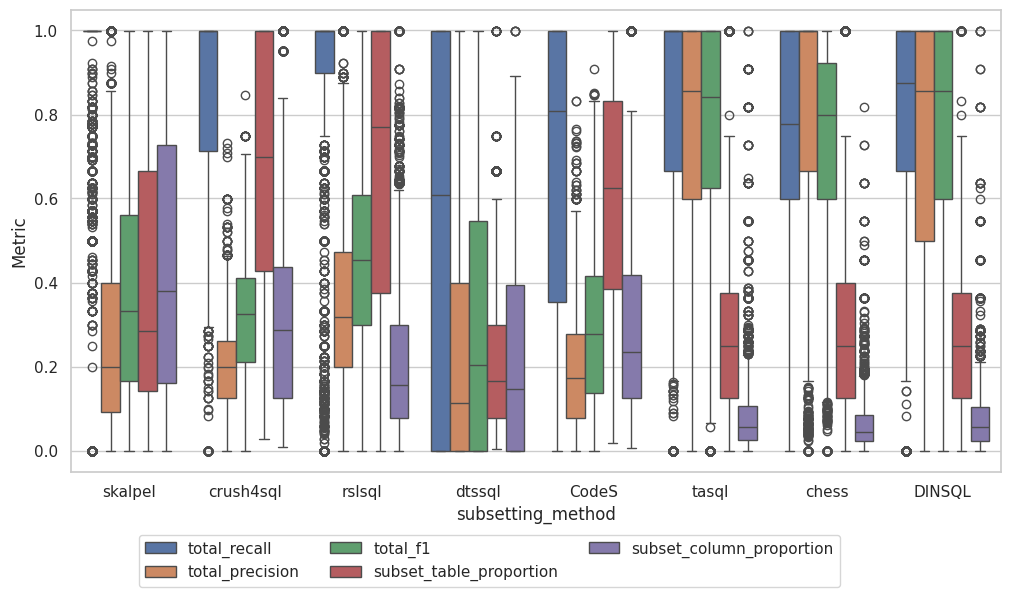

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only Very Large Database Schemas)

This is the same chart as above, except now we only compare the databases that were too large for at least one model

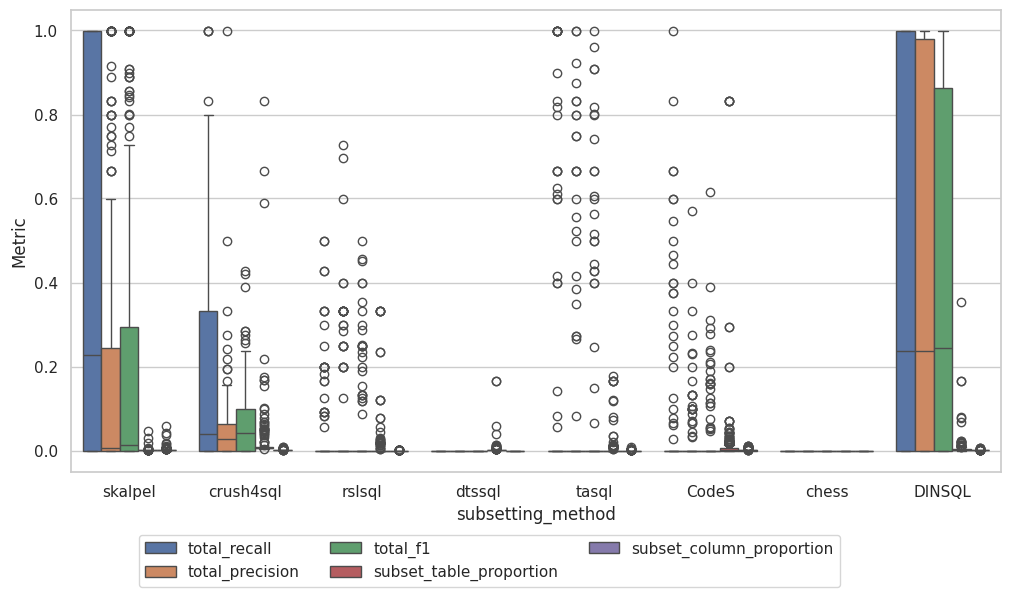

In [78]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and ~all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Performance by Subsetting Method and Benchmark for All-Model-Compatible Schemas

<Figure size 1200x600 with 0 Axes>

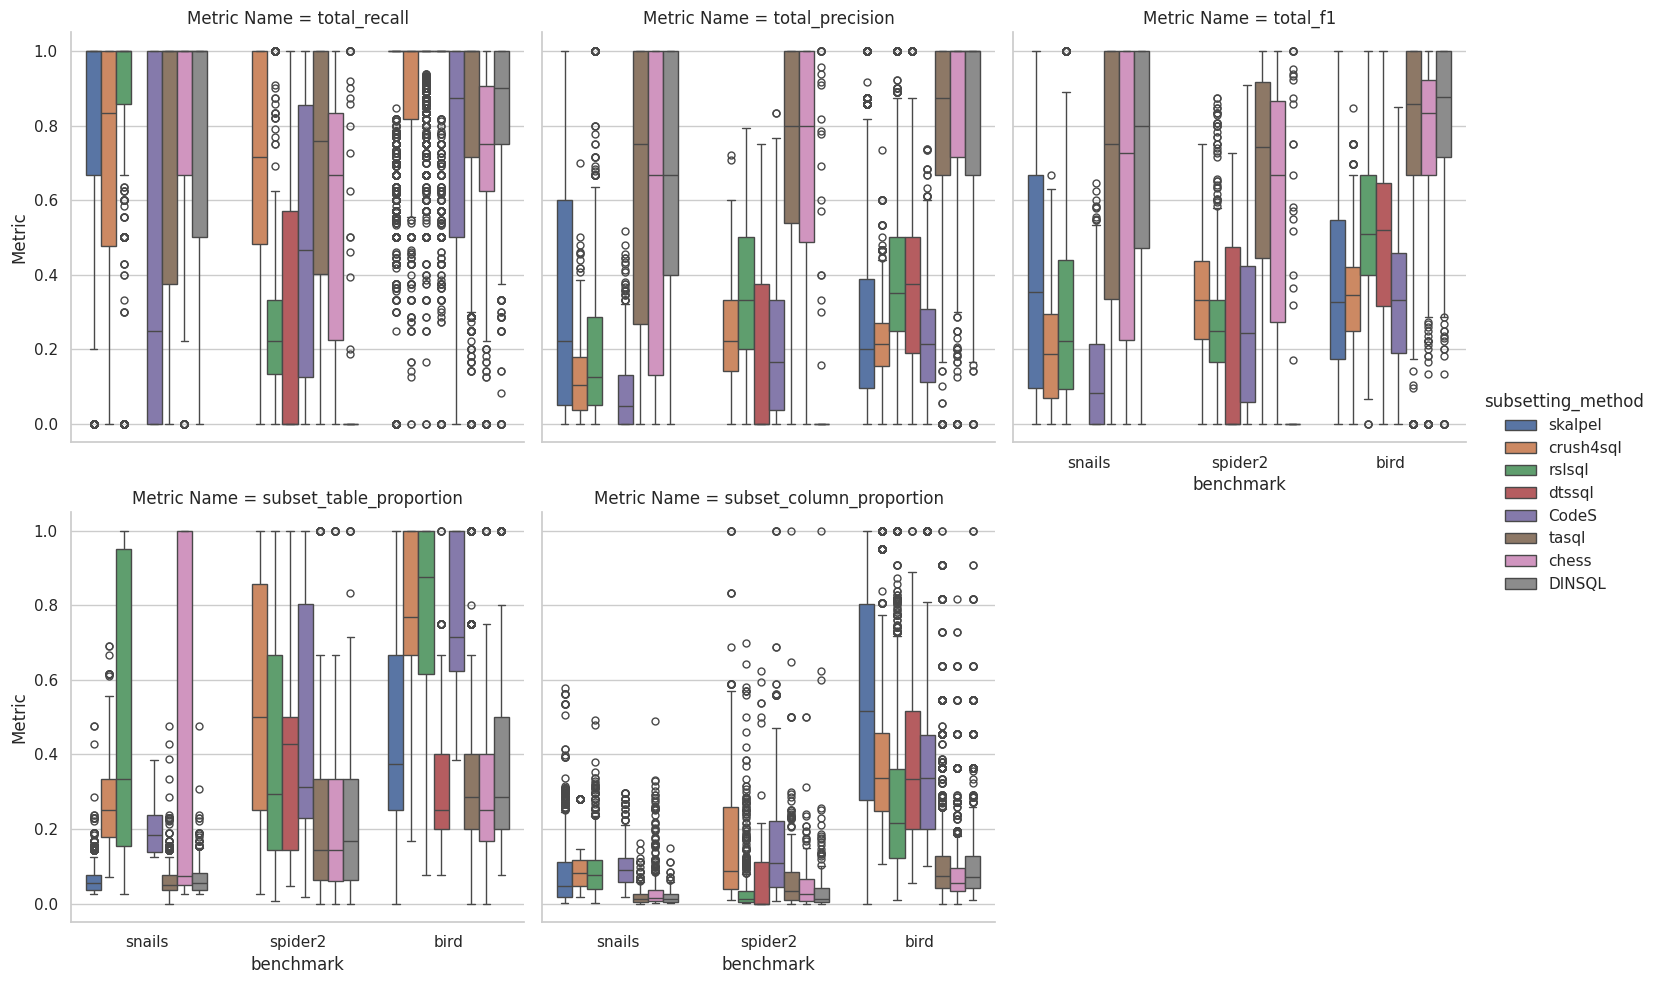

In [79]:
plt.figure(figsize=(12, 6))
sns.catplot(
    data=performance_df.query(
        "prompt_tokens>=0 and inference_time>=0"
    ).melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="benchmark",
    y="Metric",
    hue="subsetting_method",
    kind="box",
    col="Metric Name",
    col_wrap=3
)

### Box and Whisker total metrics by database size and subsetting method

<Figure size 1200x600 with 0 Axes>

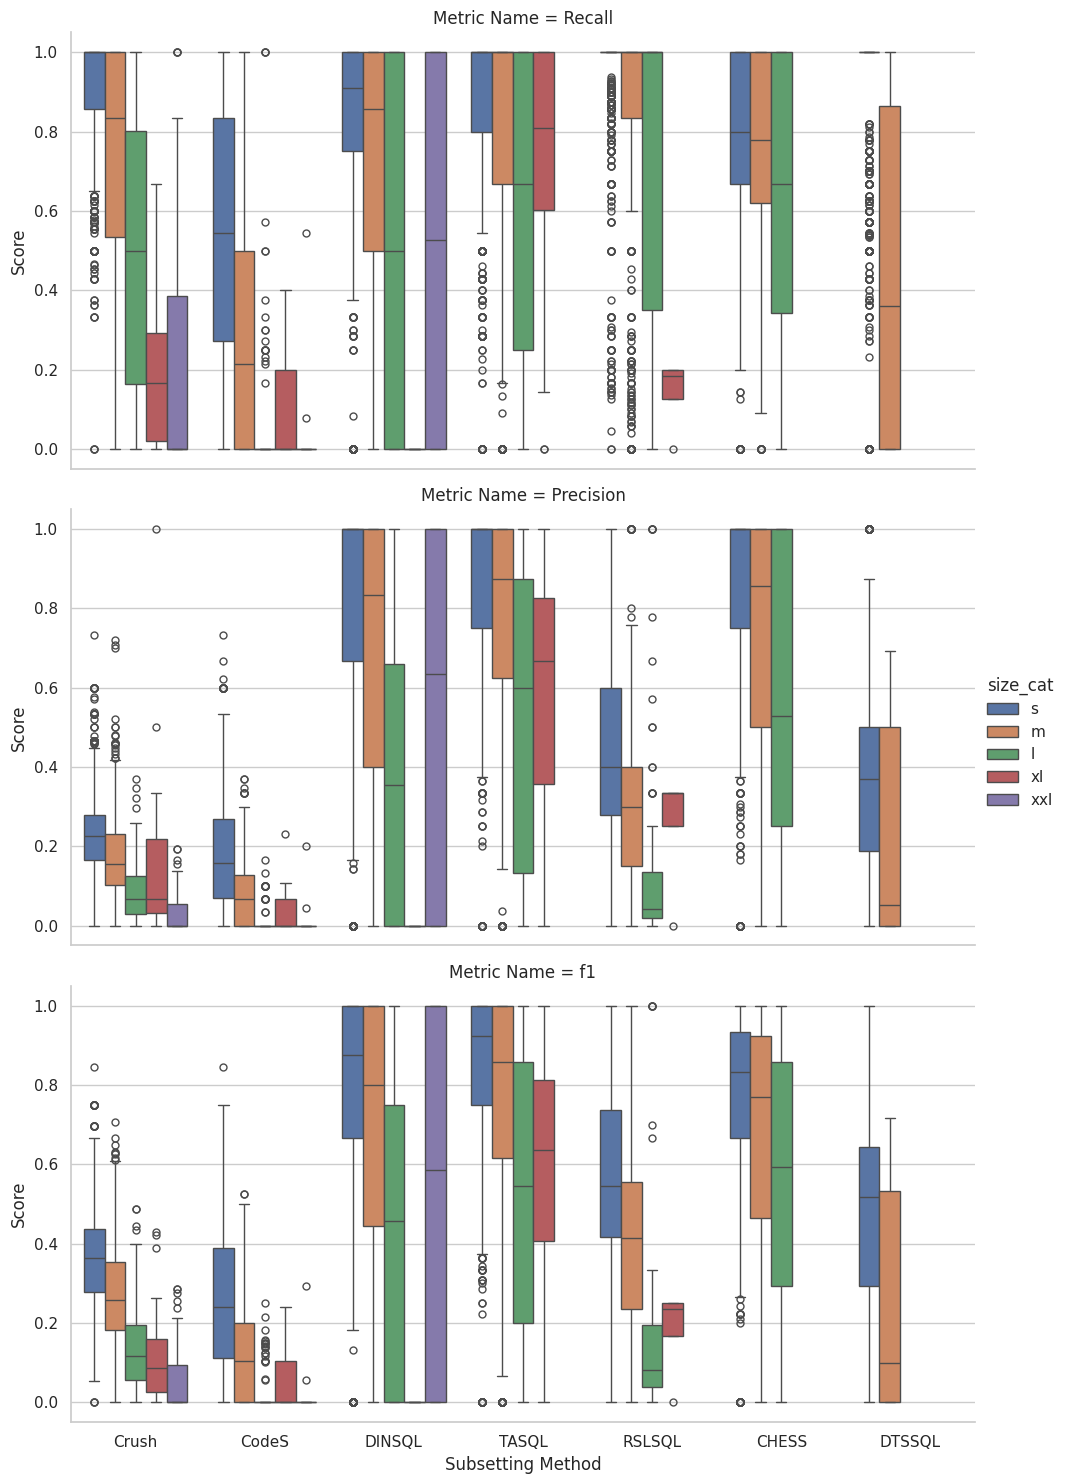

In [80]:
temp_data_df = performance_df.query(
    "prompt_tokens>=0 and inference_time>=0 and not empty_guess and eval_model"
).set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).rename(columns={"total_recall": "Recall", "total_precision": "Precision", "total_f1": "f1"})
plt.figure(figsize=(12, 6))
sns.catplot(
    data=temp_data_df.sort_values(by="size_sort").melt(
        id_vars=["Subsetting Method", "size_cat"],
        value_vars=["Recall", "Precision", "f1"],
        value_name="Score",
        var_name="Metric Name"
    ),
    x="Subsetting Method",
    y="Score",
    hue="size_cat",
    kind="box",
    col="Metric Name",
    col_wrap=1,
    aspect=2
)

### Column count x F1 line plot for each method

(0.0, 1.0)

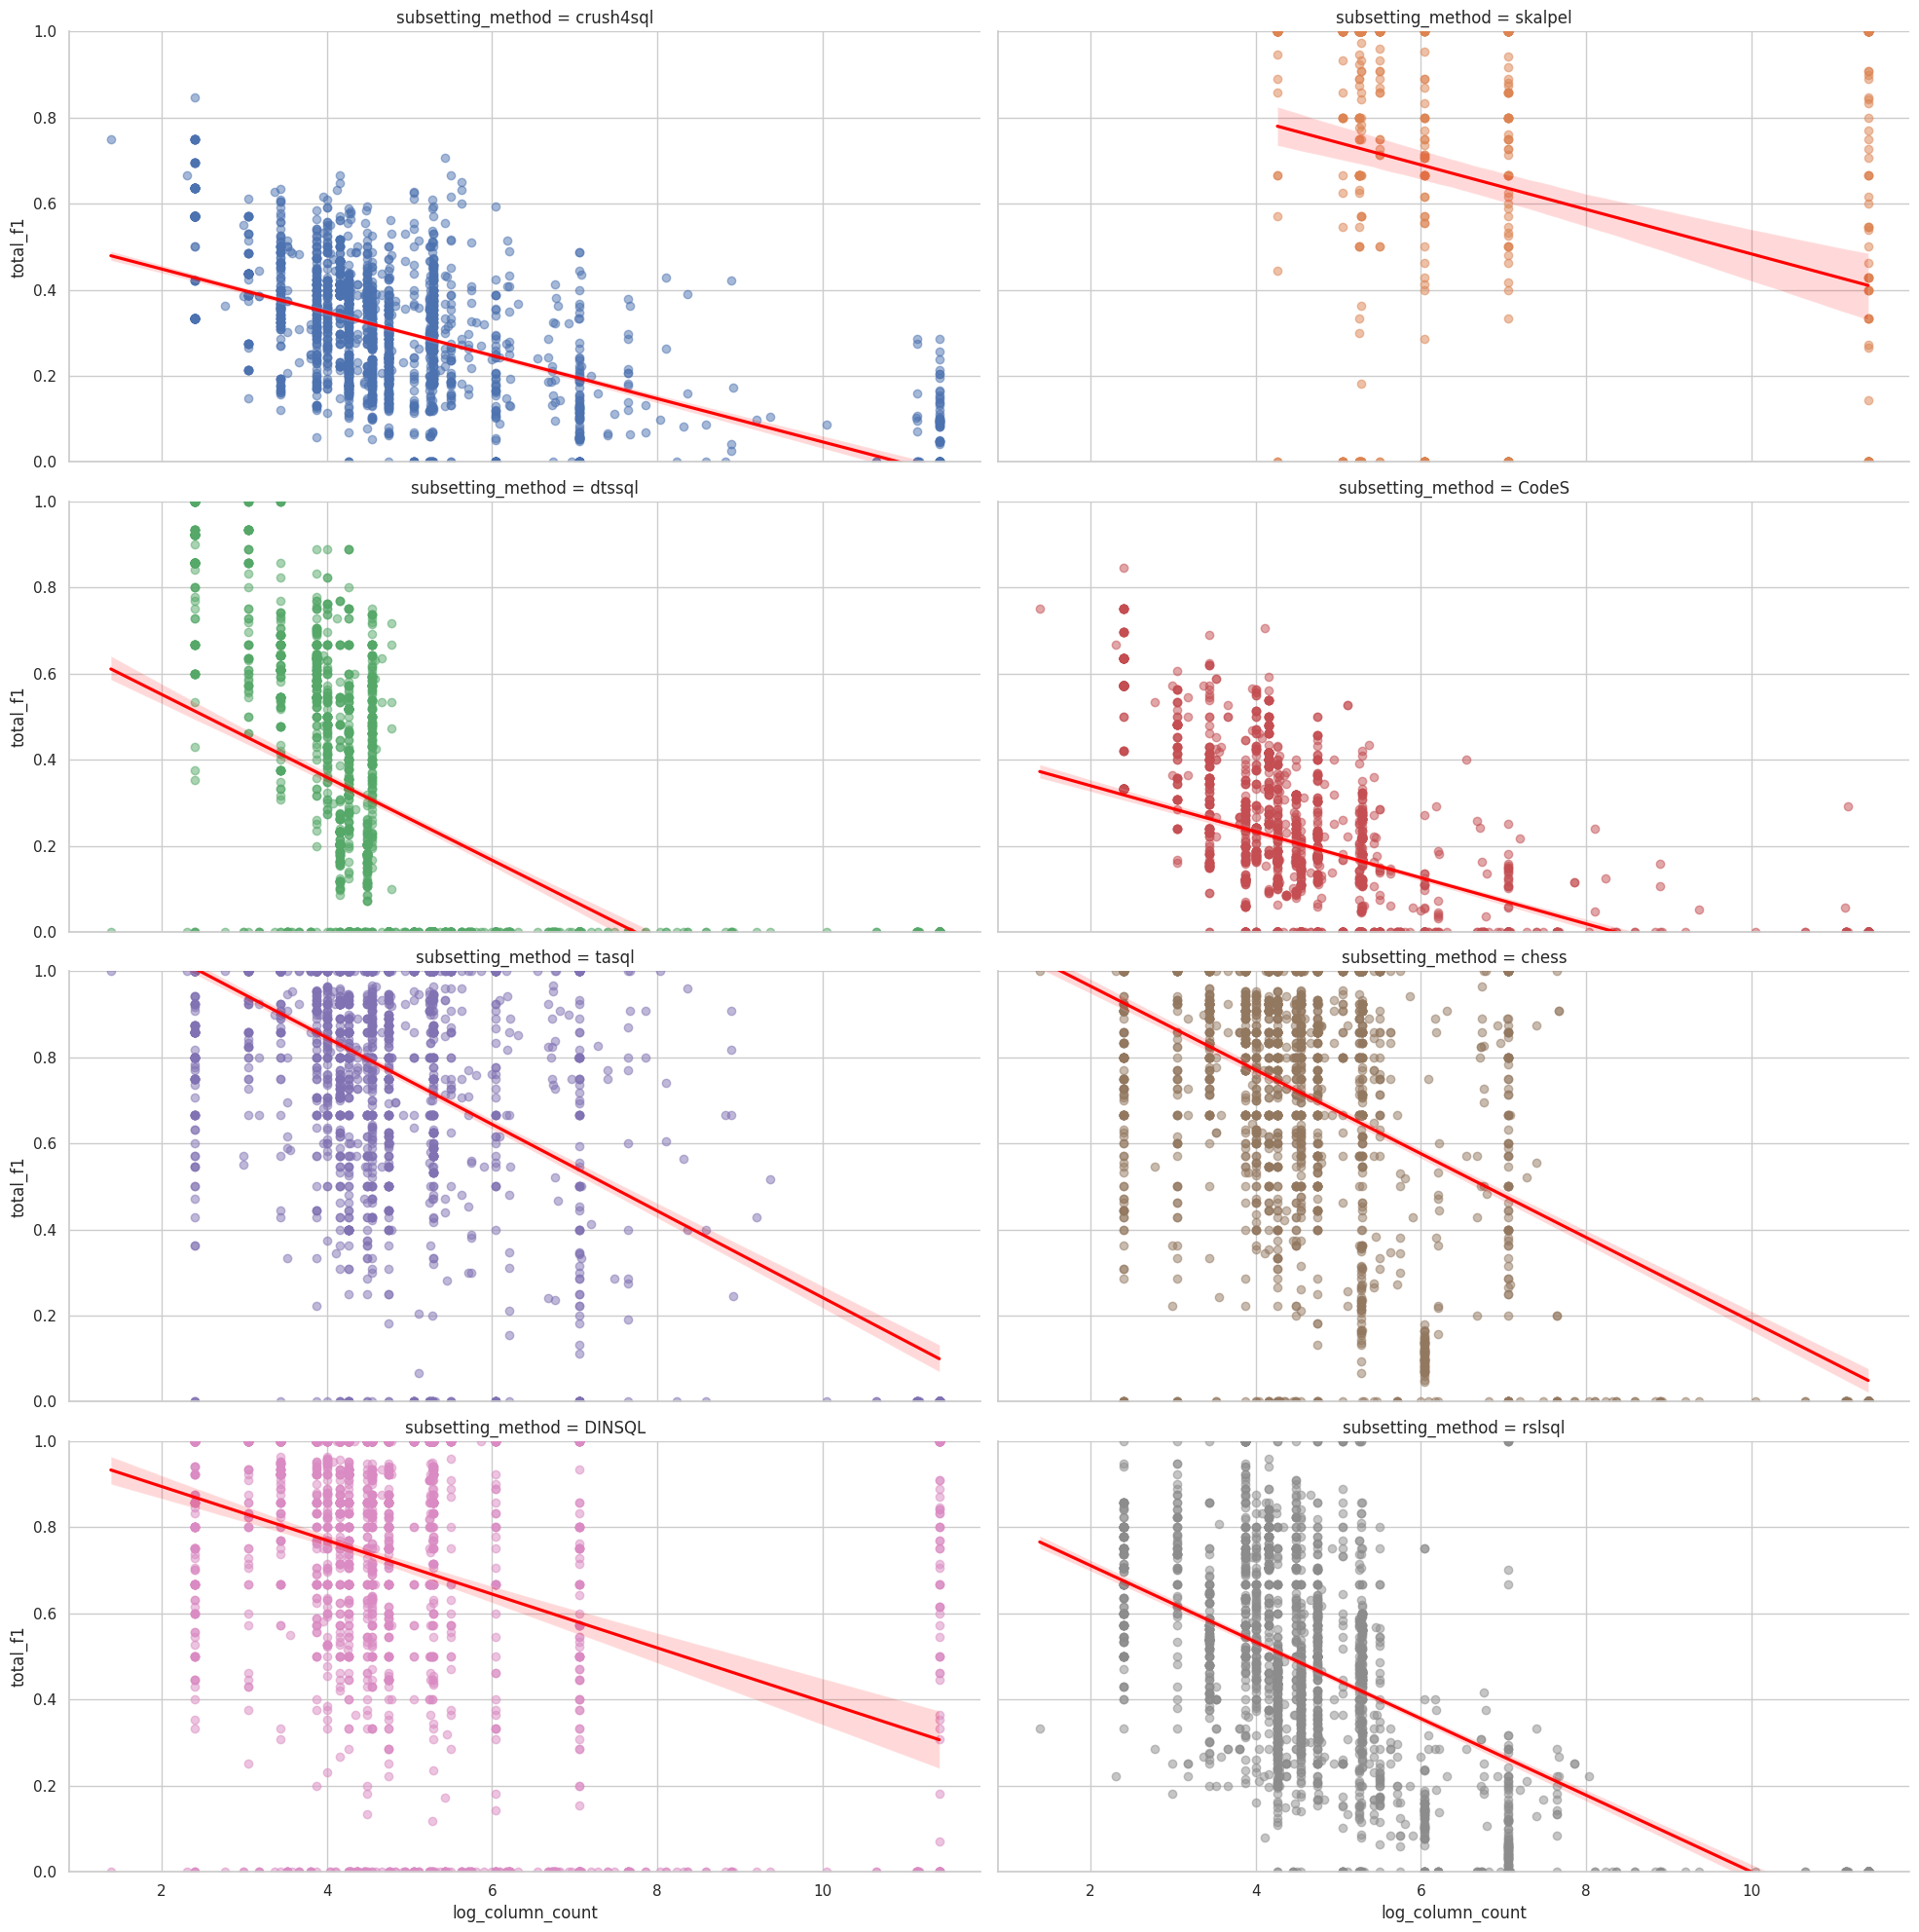

In [164]:
temp_data_df = performance_df.query(
    "eval_model"
    ).set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
)
temp_data_df["log_table_count"] = temp_data_df.table_count.apply(lambda x: np.log1p(x))
temp_data_df["log_column_count"] = temp_data_df.column_count.apply(lambda x: np.log(x))

sns.lmplot(
    data=temp_data_df,
    x="log_column_count",
    y="total_f1",
    hue="subsetting_method",
    col="subsetting_method",
    col_wrap=2,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
    aspect=2
)
plt.ylim(0.0, 1.0)

## Inference Time

### Inference Time by Subsetting Method

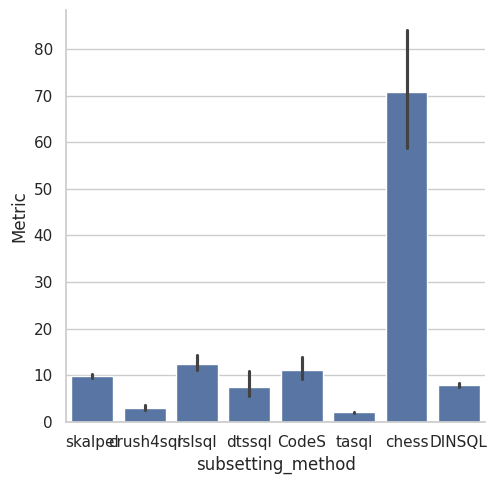

In [81]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["inference_time"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric > 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)

## Token Usage

### Prompt Tokens by Subsetting Method

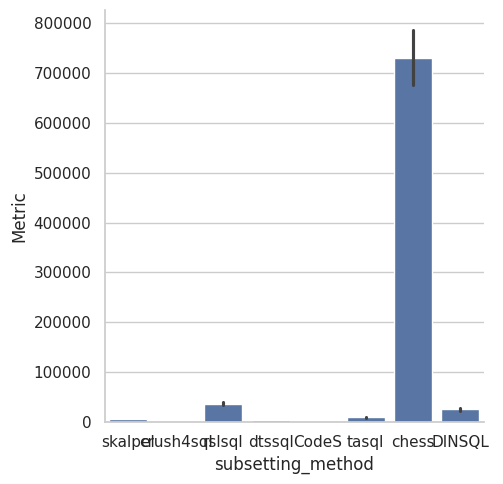

In [82]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["prompt_tokens"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric >= 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)

## Radar Charts

### Individual radars for each subsetting method by database size

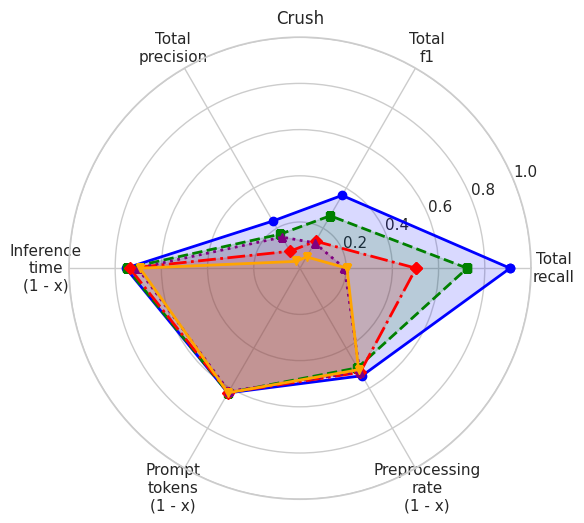

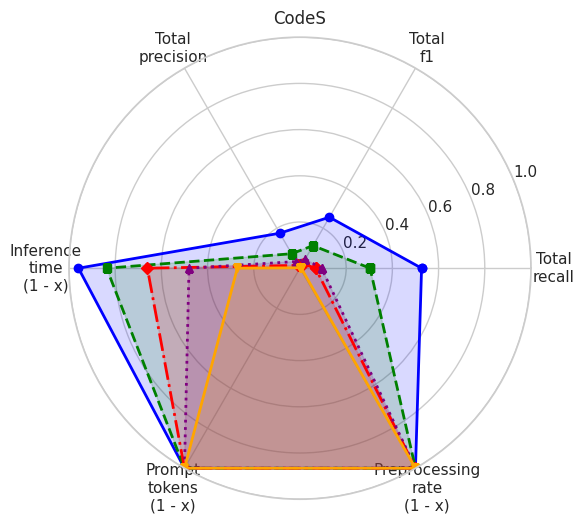

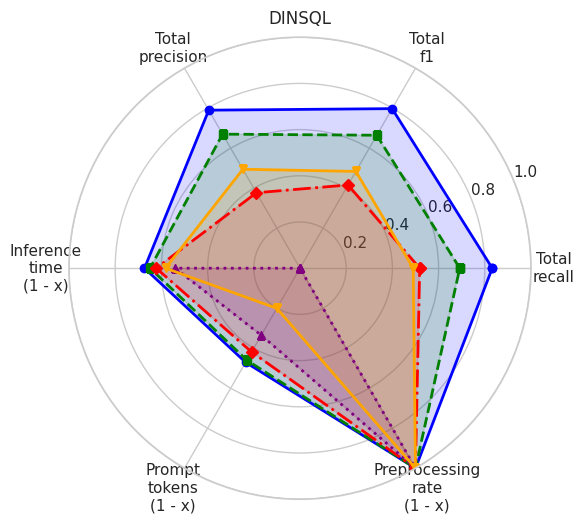

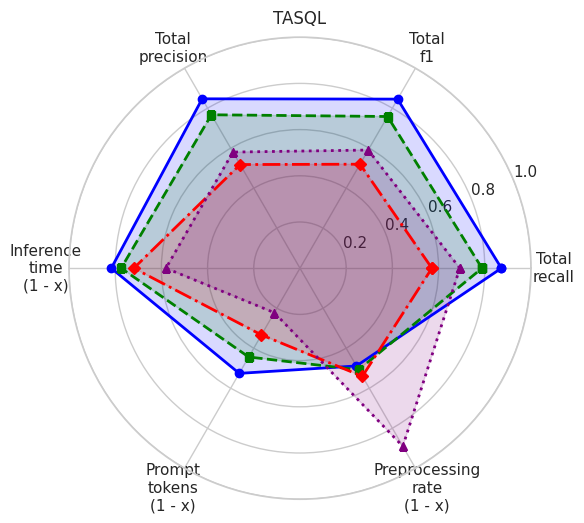

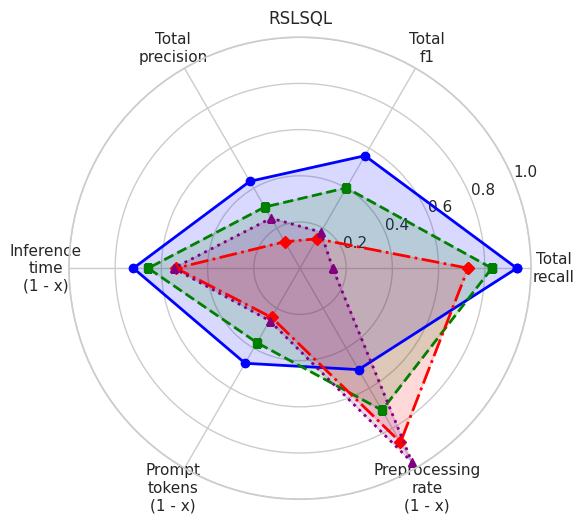

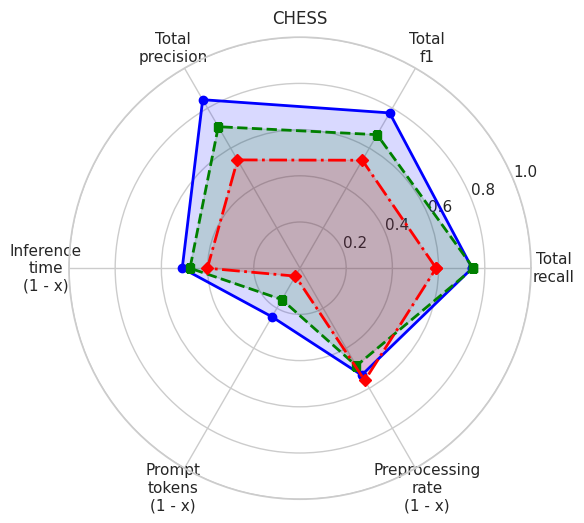

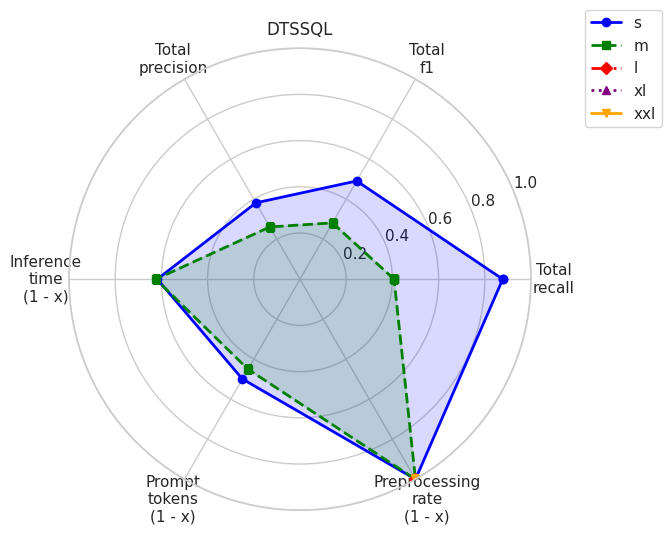

In [83]:
categories = ["total_recall", "total_f1", "total_precision", "inference_time", "prompt_tokens", "preprocessing_rate"]
temp_data_df = performance_df.query(f"eval_model and inference_time>0 and prompt_tokens>=0").copy()
temp_data_df["inference_time"] = np.log(temp_data_df.inference_time)
temp_data_df["inference_time"] = 1 - (
        (temp_data_df.inference_time - temp_data_df.inference_time.min()) 
        / (temp_data_df.inference_time.max() - temp_data_df.inference_time.min())
        )
temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["prompt_tokens"] = 1 - (
    (temp_data_df.prompt_tokens - temp_data_df.prompt_tokens.min()) 
    / (temp_data_df.prompt_tokens.max() - temp_data_df.prompt_tokens.min())
    )
temp_data_df = temp_data_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.set_index(["subsetting_method", "benchmark", "database", "comments"]).join(
    processing_time_df.set_index(["subsetting_method", "benchmark", "database", "comment"]), rsuffix="_pt"
).reset_index()
temp_data_df["preprocessing_rate"] = temp_data_df.seconds_per_column.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["preprocessing_rate"] = 1 - (
    (temp_data_df.preprocessing_rate - temp_data_df.preprocessing_rate.min()) 
    / (temp_data_df.preprocessing_rate.max() - temp_data_df.preprocessing_rate.min())
    )
temp_data_df = temp_data_df.sort_values(by="size_sort")

output_dir = f"{os.getcwd()}/figures/method_radar_charts"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, method in enumerate(temp_data_df.subsetting_method.unique()):
    # break
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    plot_styles = [
        {"color": "blue", "alpha": 0.15, "linestyle": "-", "marker": "o"},
        {"color": "green", "alpha": 0.15, "linestyle": "--", "marker": "s"},
        {"color": "red", "alpha": 0.15, "linestyle": "-.", "marker": "D"},
        {"color": "purple", "alpha": 0.15, "linestyle": ":", "marker": "^"},
        {"color": "orange", "alpha": 0.15, "linestyle": "-", "marker": "v"},
    ]
    for size_cat, plot_style in zip(temp_data_df.size_cat.unique(), plot_styles):
        values = []
        for cat in categories:
            if cat == "prompt_tokens" and method == "CodeS":
                values.append(1)
            elif cat == "preprocessing_rate" and method in ["CodeS", "dtssql", "DINSQL"]:
                values.append(1)
            else:
                values.append(temp_data_df.query(f"subsetting_method=='{method}' and size_cat=='{size_cat}'")[cat].mean())
        ax.plot(
            np.append(angles, angles[0]),
            np.append(values, values[0]),
            label=size_cat,
            color=plot_style["color"],
            linestyle=plot_style["linestyle"],
            marker=plot_style["marker"],
            linewidth=2,
        )
        ax.fill(
            np.append(angles, angles[0]),
            np.append(values, values[0]),
            alpha=plot_style["alpha"],
            color=plot_style["color"],
        )
    axis_labels = [c.replace("_", "\n").capitalize() for c in categories]
    axis_labels = [al + "\n(1 - x)" if al in ["Inference\ntime", "Prompt\ntokens", "Preprocessing\nrate"] else al for al in axis_labels]
    ax.set_thetagrids(angles * 180/np.pi, axis_labels)
    ax.set_ylim(0, 1)
    ax.set_title(f"{subsetting_display_names[method]}")
    if i == len(temp_data_df.subsetting_method.unique()) - 1:
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()
    fig.savefig(f"{output_dir}/{method}_radar.pdf", bbox_inches="tight", format="pdf")
    plt.close(fig)


### Single radar for all subsetting methods

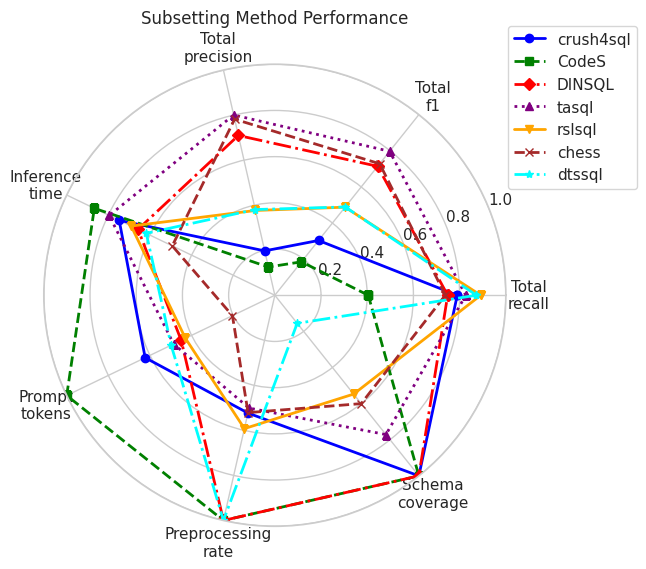

In [84]:
categories = ["total_recall", "total_f1", "total_precision", "inference_time", "prompt_tokens", "preprocessing_rate", "schema_coverage"]
temp_data_df = performance_df.query(f"eval_model and inference_time>=0 and prompt_tokens>=0").copy()
temp_data_df["inference_time"] = np.log(temp_data_df.inference_time)
temp_data_df["inference_time"] = 1 - (
        (temp_data_df.inference_time - temp_data_df.inference_time.min()) 
        / (temp_data_df.inference_time.max() - temp_data_df.inference_time.min())
        )
temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["prompt_tokens"] = 1 - (
    (temp_data_df.prompt_tokens - temp_data_df.prompt_tokens.min()) 
    / (temp_data_df.prompt_tokens.max() - temp_data_df.prompt_tokens.min())
    )
temp_data_df = temp_data_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.set_index(["subsetting_method", "benchmark", "database", "comments"]).join(
    processing_time_df.set_index(["subsetting_method", "benchmark", "database", "comment"]), rsuffix="_pt"
).reset_index()
temp_data_df["preprocessing_rate"] = temp_data_df.seconds_per_column.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["preprocessing_rate"] = 1 - (
    (temp_data_df.preprocessing_rate - temp_data_df.preprocessing_rate.min()) 
    / (temp_data_df.preprocessing_rate.max() - temp_data_df.preprocessing_rate.min())
    )
temp_data_df = temp_data_df.sort_values(by="size_sort")
# break
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)
plot_styles = [
    {"color": "blue", "alpha": 0.15, "linestyle": "-", "marker": "o"},
    {"color": "green", "alpha": 0.15, "linestyle": "--", "marker": "s"},
    {"color": "red", "alpha": 0.15, "linestyle": "-.", "marker": "D"},
    {"color": "purple", "alpha": 0.15, "linestyle": ":", "marker": "^"},
    {"color": "orange", "alpha": 0.15, "linestyle": "-", "marker": "v"},
    {"color": "brown", "alpha": 0.15, "linestyle": "--", "marker": "x"},
    {"color": "cyan", "alpha": 0.15, "linestyle": "-.", "marker": "*"}
]
for method, plot_style in zip(temp_data_df.subsetting_method.unique(), plot_styles):
    values = []
    for cat in categories:
        if cat not in temp_data_df.columns:
            continue
        if cat == "prompt_tokens" and method == "CodeS":
            values.append(1)
        elif cat == "preprocessing_rate" and method in ["CodeS", "dtssql", "DINSQL"]:
            values.append(1)
        else:
            values.append(temp_data_df.query(f"subsetting_method=='{method}'")[cat].mean())
        
    values.append(get_schema_coverage(method, performance_df, schema_stat_df))
    ax.plot(
        np.append(angles, angles[0]),
        np.append(values, values[0]),
        label=method,
        color=plot_style["color"],
        linestyle=plot_style["linestyle"],
        marker=plot_style["marker"],
        linewidth=2,
    )
    # ax.fill(
    #     np.append(angles, angles[0]),
    #     np.append(values, values[0]),
    #     alpha=plot_style["alpha"],
    #     color=plot_style["color"],
    # )
ax.set_thetagrids(angles * 180/np.pi, [c.replace("_", "\n").capitalize() for c in categories])
ax.set_ylim(0, 1)
ax.set_title("Subsetting Method Performance")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
fig.savefig("figures/subsetting_method_performance_radar.pdf", bbox_inches="tight", dpi=300)

### Individual radars for each database size subsetting method

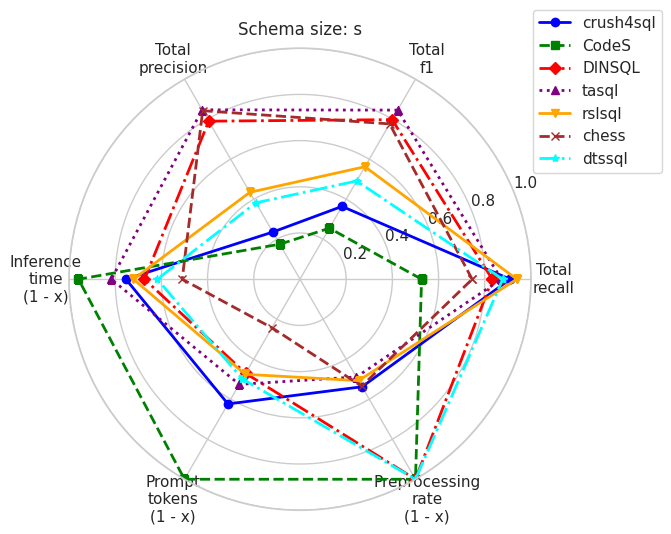

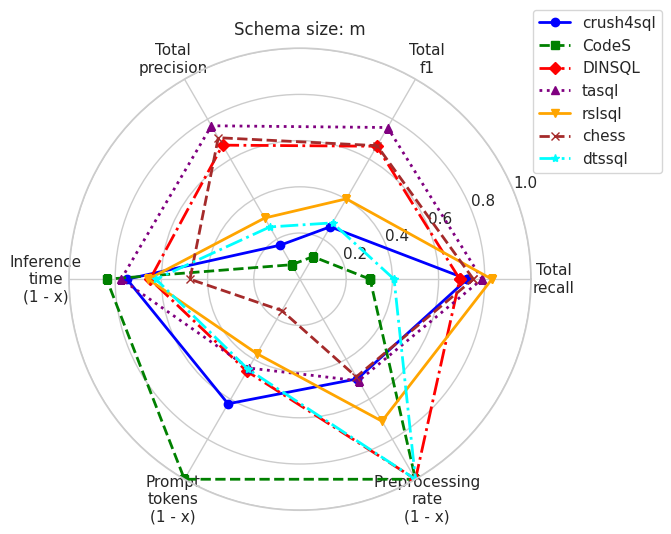

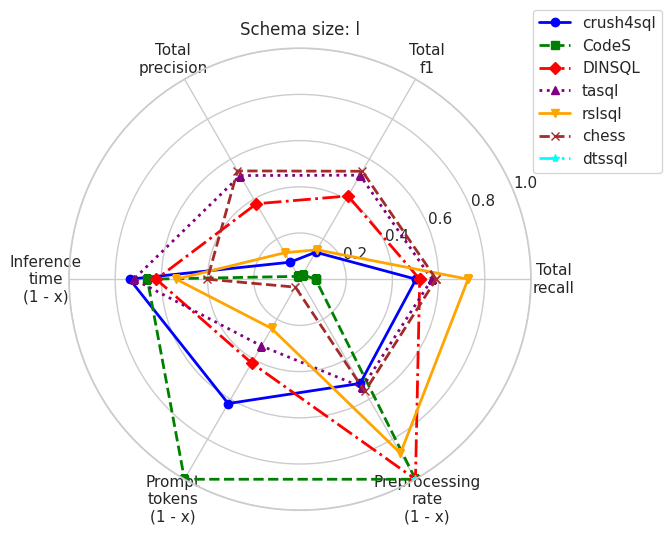

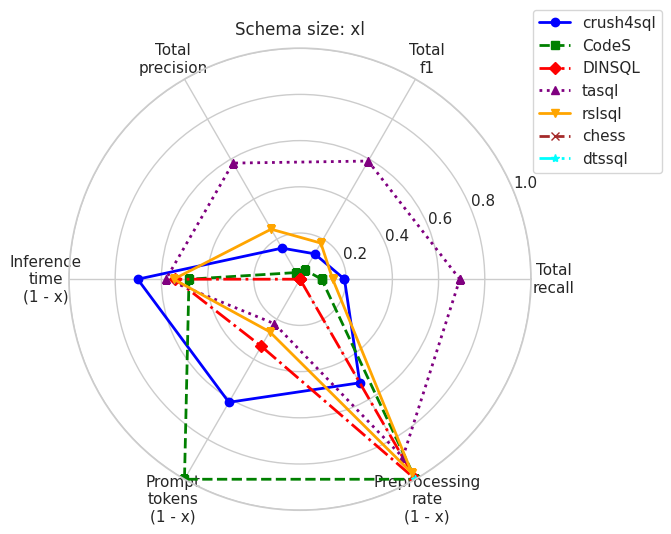

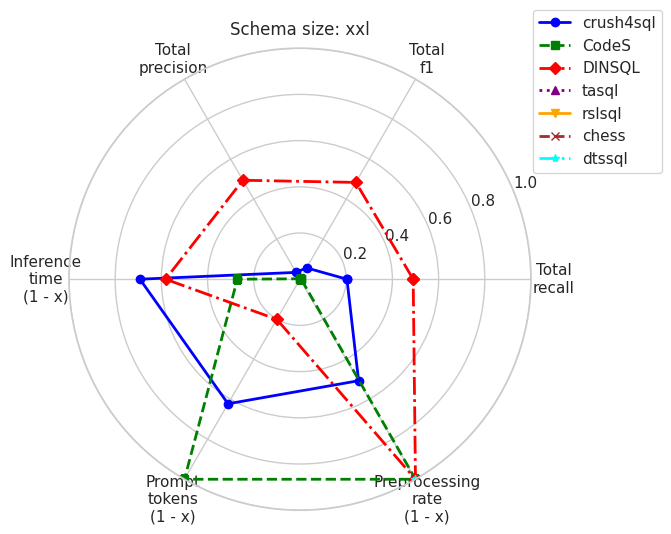

In [85]:
categories = ["total_recall", "total_f1", "total_precision", "inference_time", "prompt_tokens", "preprocessing_rate"]
temp_data_df = performance_df.query(f"eval_model and inference_time>0 and prompt_tokens>=0").copy()
temp_data_df["inference_time"] = np.log(temp_data_df.inference_time)
temp_data_df["inference_time"] = 1 - (
        (temp_data_df.inference_time - temp_data_df.inference_time.min()) 
        / (temp_data_df.inference_time.max() - temp_data_df.inference_time.min())
        )
temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["prompt_tokens"] = 1 - (
    (temp_data_df.prompt_tokens - temp_data_df.prompt_tokens.min()) 
    / (temp_data_df.prompt_tokens.max() - temp_data_df.prompt_tokens.min())
    )
temp_data_df = temp_data_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.set_index(["subsetting_method", "benchmark", "database", "comments"]).join(
    processing_time_df.set_index(["subsetting_method", "benchmark", "database", "comment"]), rsuffix="_pt"
).reset_index()
temp_data_df["preprocessing_rate"] = temp_data_df.seconds_per_column.apply(lambda x: np.log(x) if x > 0 else x)
temp_data_df["preprocessing_rate"] = 1 - (
    (temp_data_df.preprocessing_rate - temp_data_df.preprocessing_rate.min()) 
    / (temp_data_df.preprocessing_rate.max() - temp_data_df.preprocessing_rate.min())
    )
temp_data_df = temp_data_df.sort_values(by="size_sort")
for size_cat in temp_data_df.size_cat.unique():
    # break
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    plot_styles = [
        {"color": "blue", "alpha": 0.15, "linestyle": "-", "marker": "o"},
        {"color": "green", "alpha": 0.15, "linestyle": "--", "marker": "s"},
        {"color": "red", "alpha": 0.15, "linestyle": "-.", "marker": "D"},
        {"color": "purple", "alpha": 0.15, "linestyle": ":", "marker": "^"},
        {"color": "orange", "alpha": 0.15, "linestyle": "-", "marker": "v"},
        {"color": "brown", "alpha": 0.15, "linestyle": "--", "marker": "x"},
        {"color": "cyan", "alpha": 0.15, "linestyle": "-.", "marker": "*"},
    ]
    for method, plot_style in zip(temp_data_df.subsetting_method.unique(), plot_styles):
        values = []
        for cat in categories:
            if cat == "prompt_tokens" and method == "CodeS":
                values.append(1)
            elif cat == "preprocessing_rate" and method in ["CodeS", "dtssql", "DINSQL"]:
                values.append(1)
            else:
                values.append(temp_data_df.query(f"subsetting_method=='{method}' and size_cat=='{size_cat}'")[cat].mean())
        ax.plot(
            np.append(angles, angles[0]),
            np.append(values, values[0]),
            label=method, 
            color=plot_style["color"],
            linestyle=plot_style["linestyle"],
            marker=plot_style["marker"],
            linewidth=2,
        )
        # ax.fill(
        #     np.append(angles, angles[0]),
        #     np.append(values, values[0]),
        #     alpha=plot_style["alpha"],
        #     color=plot_style["color"],
        # )
    axis_labels = [c.replace("_", "\n").capitalize() for c in categories]
    axis_labels = [al + "\n(1 - x)" if al in ["Inference\ntime", "Prompt\ntokens", "Preprocessing\nrate"] else al for al in axis_labels]
    ax.set_thetagrids(angles * 180/np.pi, axis_labels)
    ax.set_ylim(0, 1)
    ax.set_title(f"Schema size: {size_cat}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Pareto

## average total recall x average total precision for each method

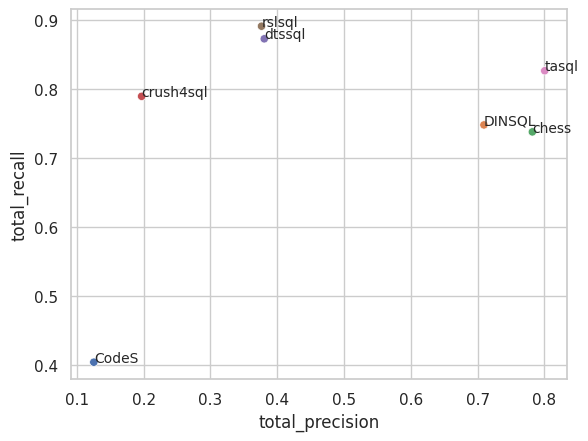

In [86]:
temp_data_df = performance_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "total_recall", "total_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="total_precision",
    y="total_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.total_precision, line.total_recall, line.Index, fontsize="small")

## average table recall x average table precision for each method

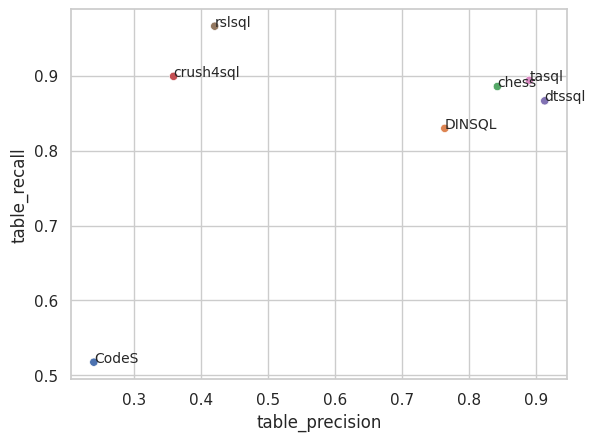

In [87]:
temp_data_df = performance_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "table_recall", "table_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="table_precision",
    y="table_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.table_precision, line.table_recall, line.Index, fontsize="small")

## average column recall x average column precision for each method

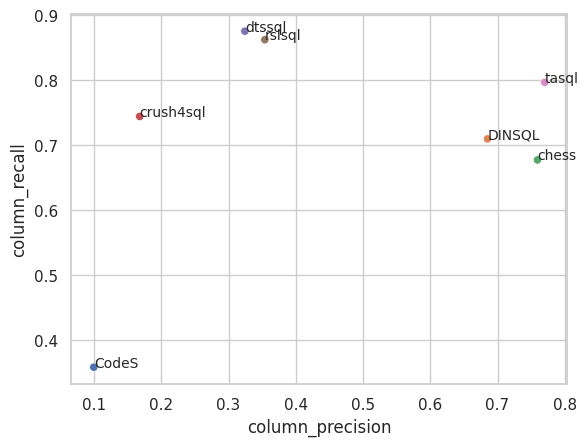

In [88]:
temp_data_df = performance_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "column_recall", "column_precision"]].groupby(
    by=["subsetting_method"]
).mean()

sns.scatterplot(
    data=temp_data_df,
    x="column_precision",
    y="column_recall",
    hue="subsetting_method",
    legend=False
)
for line in temp_data_df.itertuples():
    plt.text(line.column_precision, line.column_recall, line.Index, fontsize="small")

## average total recall x average total precision for each method and benchmark

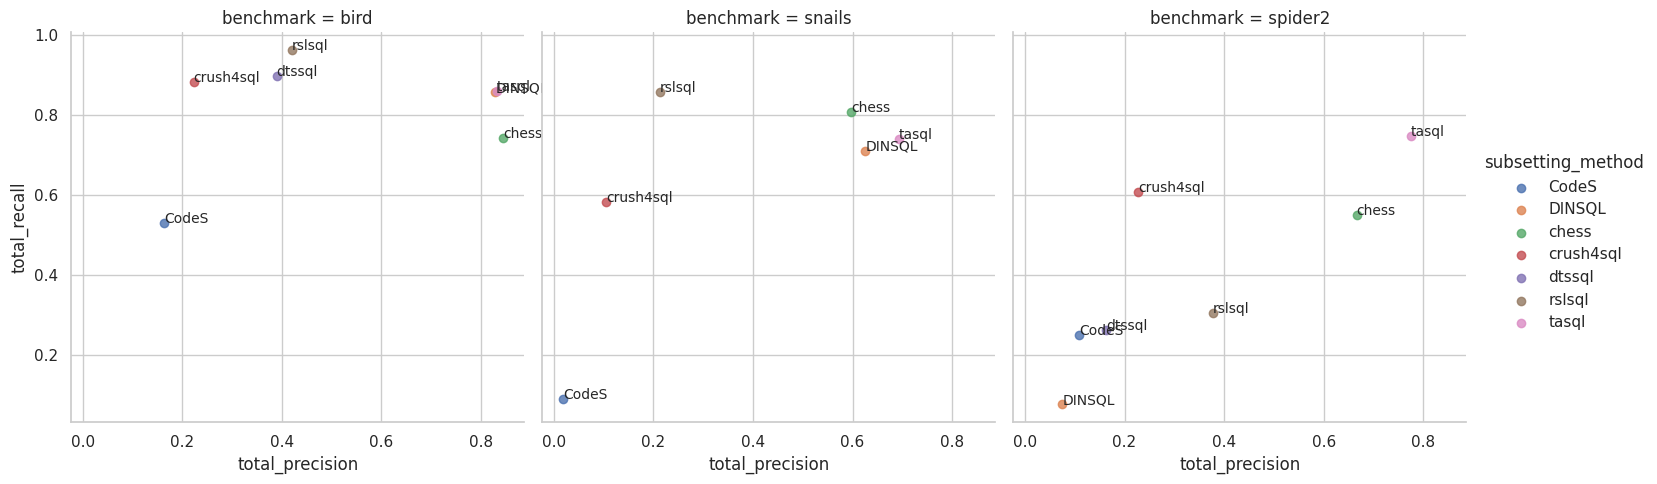

In [89]:
temp_data_df = performance_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "benchmark", "total_recall", "total_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="total_precision",
    y="total_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.total_precision, line.total_recall, line.subsetting_method, fontsize="small"
        )


## Average total recall and average total precision for each method by database size

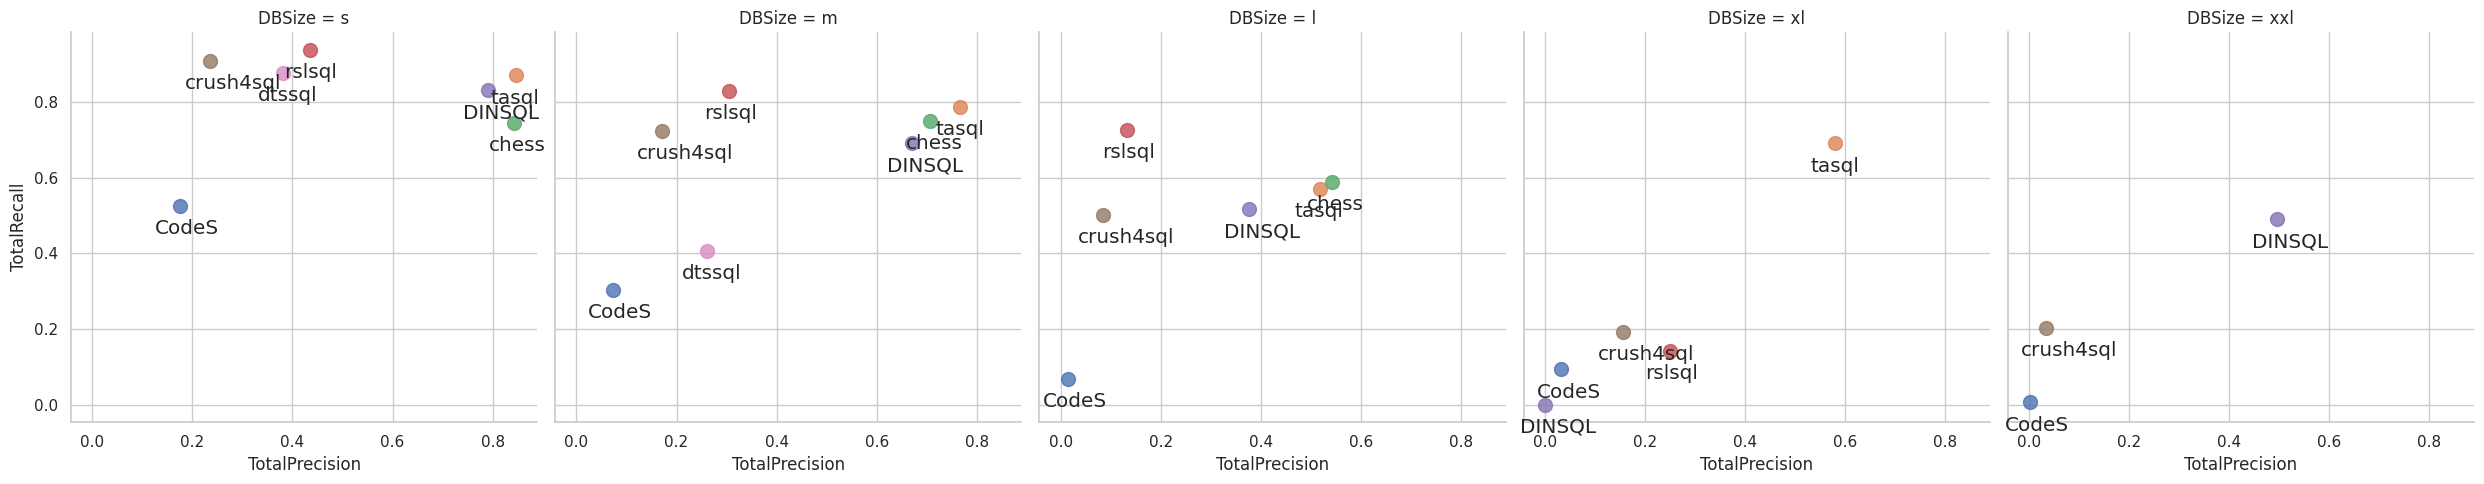

In [90]:
temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "size_cat", "size_sort", "total_recall", "total_precision"]].groupby(
    by=["subsetting_method", "size_cat", "size_sort"]
).mean().reset_index()
temp_data_df = temp_data_df.rename(columns={
    "size_cat": "DBSize",
    "total_recall": "TotalRecall",
    "total_precision": "TotalPrecision",
    "subsetting_method": "SubsettingMethod"
})
g = sns.lmplot(
    data=temp_data_df.sort_values(by="size_sort"),
    x="TotalPrecision",
    y="TotalRecall",
    hue="SubsettingMethod",
    col="DBSize",
    legend=False,
    scatter_kws={"s": 100},
    
)

for line in temp_data_df.itertuples():
    g.axes[0, {"s":0, "m":1, "l":2, "xl":3, "xxl":4}[line.DBSize]].text(
        line.TotalPrecision - 0.05, line.TotalRecall - 0.075, line.SubsettingMethod, fontsize="large"
    )
    
fig = g.figure
fig.savefig("figures/pareto_total_recall_precision_by_dbsize.pdf", bbox_inches="tight", dpi=300)

## average table recall x average table precision for each method and benchmark

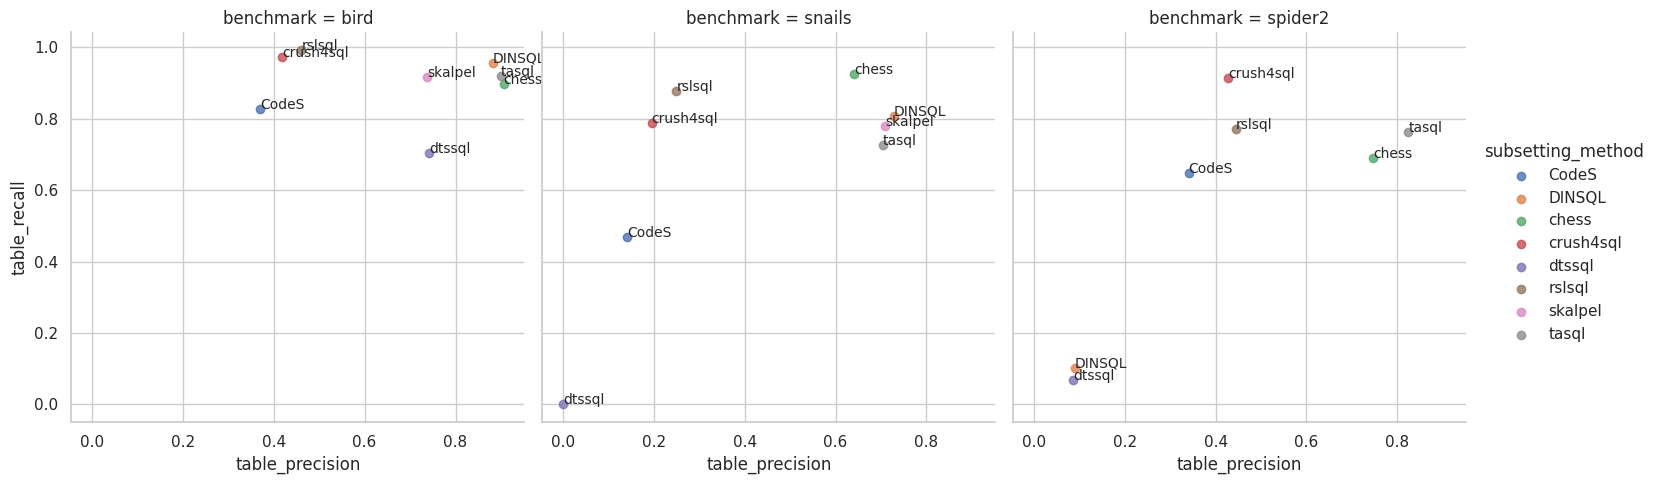

In [91]:
temp_data_df = performance_df.query(
    "all_models_compatible==True"
)[["subsetting_method", "benchmark", "table_recall", "table_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="table_precision",
    y="table_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.table_precision, line.table_recall, line.subsetting_method, fontsize="small"
        )


## average column recall x average column precision for each method and benchmark

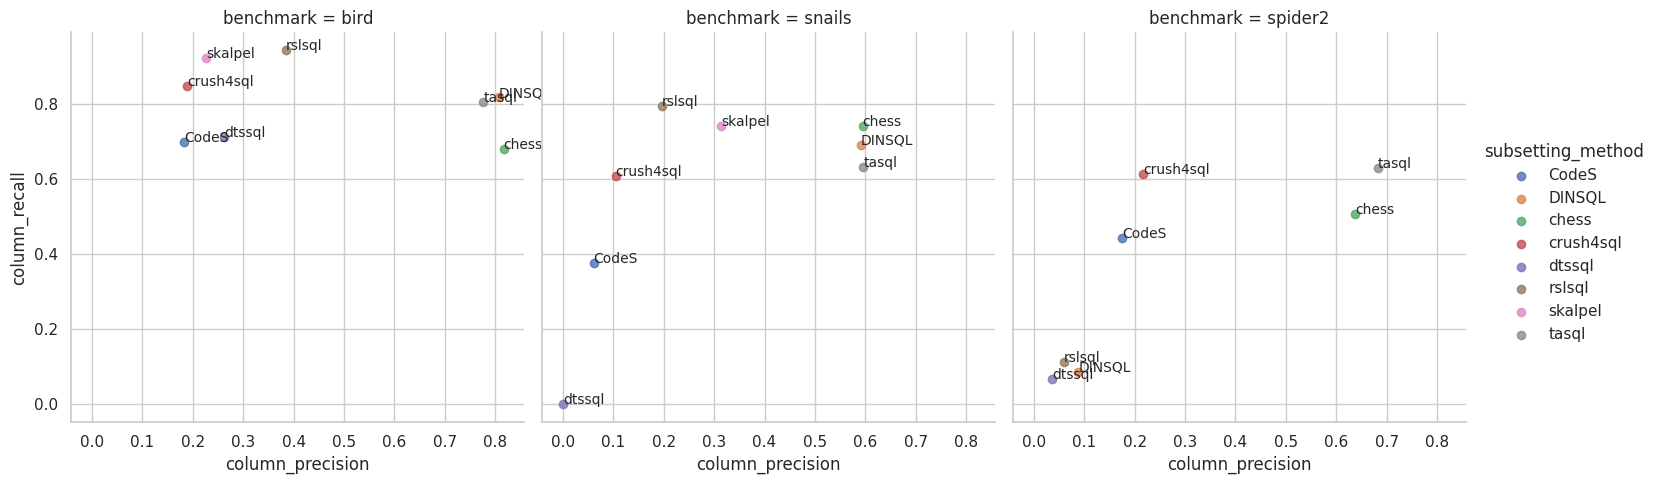

In [92]:
temp_data_df = performance_df.query(
    "all_models_compatible==True"
)[["subsetting_method", "benchmark", "column_recall", "column_precision"]].groupby(
    by=["subsetting_method", "benchmark"]
).mean().reset_index()

g = sns.lmplot(
    data=temp_data_df,
    x="column_precision",
    y="column_recall",
    hue="subsetting_method",
    col="benchmark",
    legend=True
)

for line in temp_data_df.itertuples():
    g.axes[0, {"bird":0, "snails":1, "spider2":2}[line.benchmark]].text(
        line.column_precision, line.column_recall, line.subsetting_method, fontsize="small"
        )


## Average f1 x inference time by database size and subsetting method

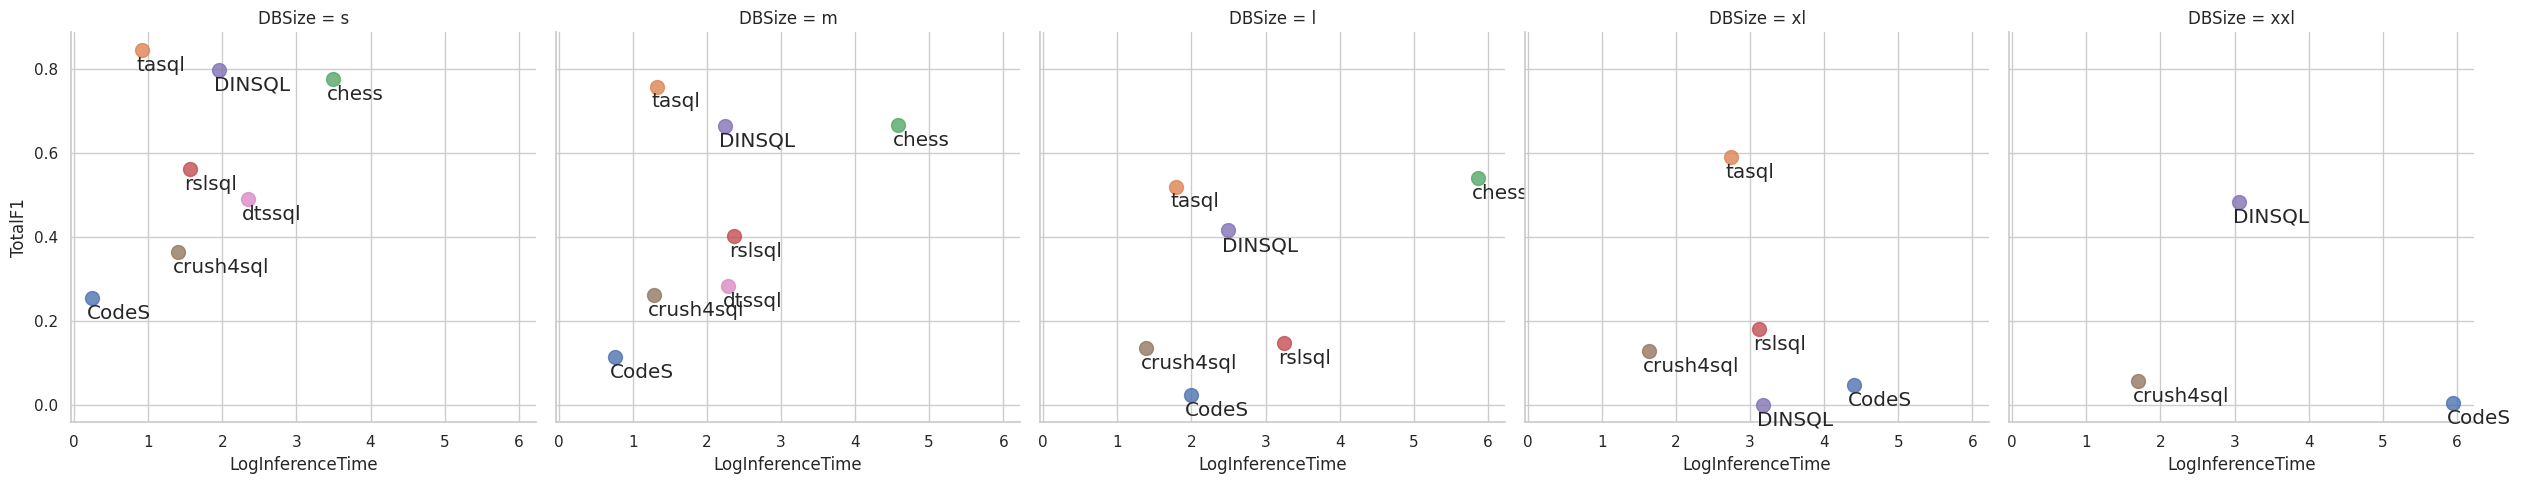

In [93]:
temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "size_cat", "size_sort", "total_f1", "inference_time"]].groupby(
    by=["subsetting_method", "size_cat", "size_sort"]
).mean().reset_index()
temp_data_df["LogInferenceTime"] = temp_data_df.inference_time.apply(lambda x: np.log1p(x))
temp_data_df = temp_data_df.rename(columns={
    "size_cat": "DBSize",
    "total_f1": "TotalF1",
    "inference_time": "InferenceTime",
    "subsetting_method": "SubsettingMethod"
})
g = sns.lmplot(
    data=temp_data_df.sort_values(by="size_sort"),
    x="LogInferenceTime",
    y="TotalF1",
    hue="SubsettingMethod",
    col="DBSize",
    legend=False,
    scatter_kws={"s": 100}
)

for line in temp_data_df.itertuples():
    g.axes[0, {"s":0, "m":1, "l":2, "xl":3, "xxl":4}[line.DBSize]].text(
       line.LogInferenceTime - 0.075, line.TotalF1 - 0.05,  line.SubsettingMethod, fontsize="large"
    )
    
fig = g.figure
fig.savefig("figures/pareto_total_f1_inference_by_dbsize.pdf", bbox_inches="tight", dpi=300)

## Average total f1 x token count by database size and subsetting method

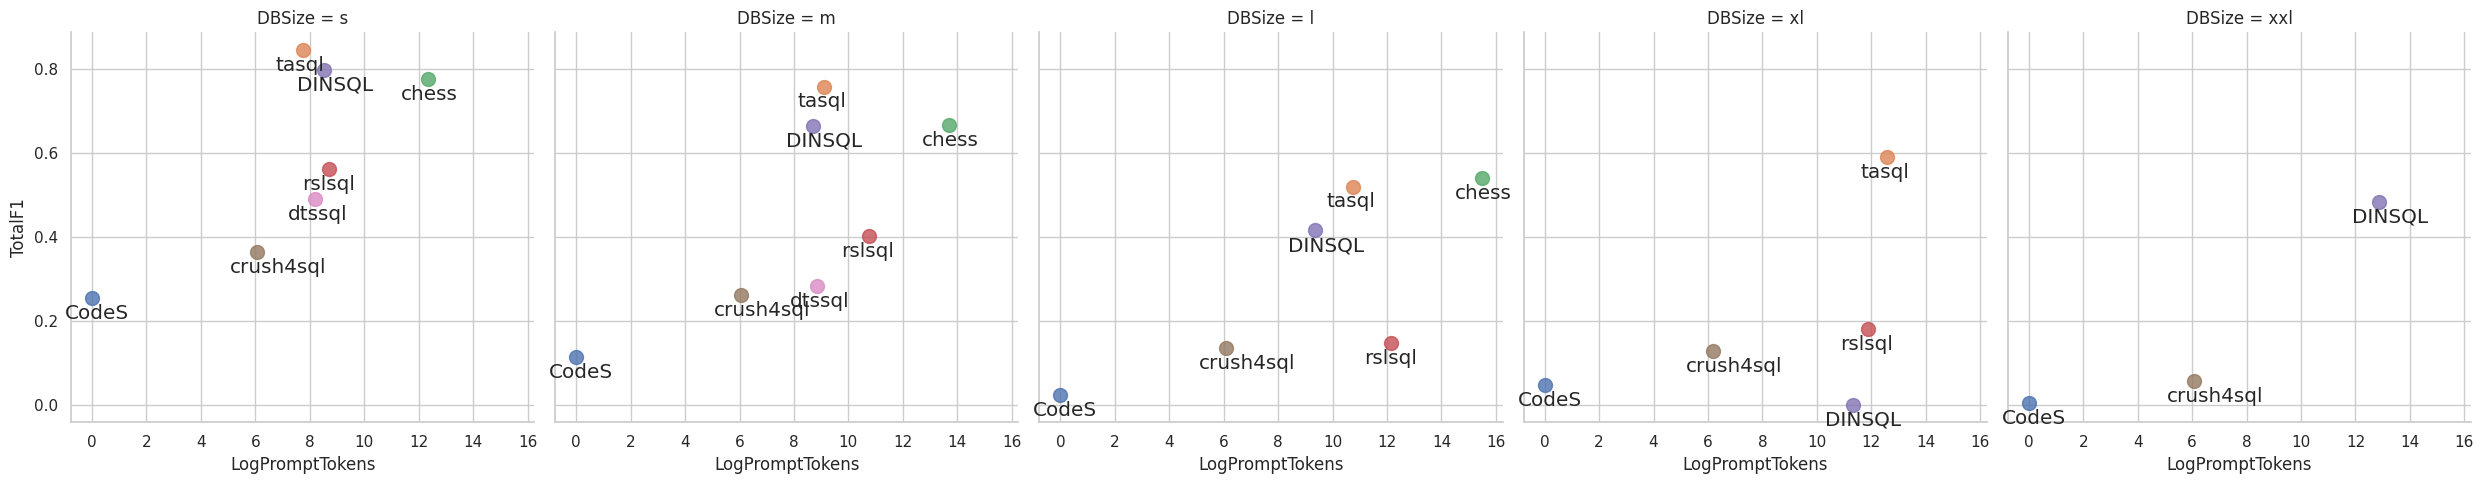

In [94]:
temp_data_df = performance_df.set_index(["benchmark", "database"]).join(
    schema_stat_df.set_index(["benchmark", "database"])
).reset_index()
temp_data_df = temp_data_df.query(
    "eval_model and prompt_tokens>=0 and inference_time>0"
)[["subsetting_method", "size_cat", "size_sort", "total_f1", "prompt_tokens"]].groupby(
    by=["subsetting_method", "size_cat", "size_sort"]
).mean().reset_index()
temp_data_df["LogPromptTokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log1p(x))
temp_data_df = temp_data_df.rename(columns={
    "size_cat": "DBSize",
    "total_f1": "TotalF1",
    "prompt_tokens": "PromptTokens",
    "subsetting_method": "SubsettingMethod"
})
g = sns.lmplot(
    data=temp_data_df.sort_values(by="size_sort"),
    x="LogPromptTokens",
    y="TotalF1",
    hue="SubsettingMethod",
    col="DBSize",
    legend=False,
    scatter_kws={"s": 100}
)

for line in temp_data_df.itertuples():
    g.axes[0, {"s":0, "m":1, "l":2, "xl":3, "xxl":4}[line.DBSize]].text(
       line.LogPromptTokens - 1, line.TotalF1 - 0.05,  line.SubsettingMethod, fontsize="large"
    )
    
fig = g.figure
fig.savefig("figures/pareto_total_f1_tokens_by_dbsize.pdf", bbox_inches="tight", dpi=300)